In [1]:
from astropy.table import Table
from astropy.io import fits
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from minisom import MiniSom
import pickle
import os

In [2]:
df_L3_info = Table.read('../dataset/L3_COSMOS2020_Richard_RefCat_2023DEC4_info.fits')
df_L3_info = df_L3_info.to_pandas().sort_values(by = "cosmos_id")

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/Noiseless_phot_cosmos_nolines_refcat30k.txt'
data_noiseless = np.loadtxt(fname)[:,3:]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/NoisySphx_shallow_nolines_refcat30k.txt'
data_all = np.loadtxt(fname)[:,3:]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/NoisySphx_deep_nolines_refcat30k.txt'
data_deep = np.loadtxt(fname)[:,3:]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/SPHEREx_1sigma_noise.txt'
data_1sig  = np.loadtxt(fname, skiprows=1)
wl = data_1sig[:,0]
sigma_all = data_1sig[:,1]
sigma_deep = data_1sig[:,2]

In [3]:
def basic_som(data, err, info_data, dim, preproc, distance, data_type, iteration = 1, sigma = 1, rate = 1, b_scale = 1.042, save = False, save_record = True):
    lupmag = -np.arcsinh(data / (2 * b_scale  * err))
    proc_err = np.absolute(-1 / (2 * b_scale  * err) / np.sqrt((data / (2 * b_scale * err)) ** 2 + 1) * err)
    
    proc_data = (lupmag- np.mean(lupmag, axis=0)) / np.std(lupmag, ddof = 1, axis=0)
    proc_err = proc_err / np.std(lupmag, ddof = 1, axis=0)
    
    print(f"Data shape: {proc_data.shape}")

    som = MiniSom(dim, dim, proc_data.shape[1], sigma = sigma, learning_rate = rate, activation_distance = distance)
    som.random_weights_init(proc_data)
    som.train(proc_data, proc_err, num_iteration = iteration, use_epochs = True)

    print("Start making diagrams...")

    density_map = np.zeros(dim ** 2).reshape(dim, dim)
    magnitude_map = np.zeros(dim ** 2).reshape(dim, dim)
    magnitude_map.fill(np.nan)
    z_map = np.zeros(dim ** 2).reshape(dim, dim)
    z_map.fill(np.nan)
    z_std = np.zeros(dim ** 2).reshape(dim, dim)
    z_std.fill(np.nan)

    labels_map = som.labels_map(proc_data, proc_err, tuple(map(tuple, np.concatenate((np.expand_dims(info_data["HSC_i_MAG"].values, axis = 1), np.expand_dims(info_data["z_true"].values, axis = 1)), axis = -1))))
    
    for i in labels_map.keys():
        properties = np.array(list(labels_map[i].keys()))
        means = np.mean(properties, axis = 0)
        stds = np.nanstd(properties, axis = 0, ddof = 1)
        density_map[int(list(i)[0]), int(list(i)[1])] = len(properties)
        magnitude_map[int(list(i)[0]), int(list(i)[1])] = means[0]
        z_map[int(list(i)[0]), int(list(i)[1])] = means[1]
        z_std[int(list(i)[0]), int(list(i)[1])] = stds[1]

    print([dim, sigma, rate])
    print(np.sum(density_map))
    print(f"Topological error: {som.topographic_error(proc_data)}")
    print(f"Quantization error: {som.quantization_error(proc_data)}")
    print(f"Average redshift std: {np.nanmean(z_std / (1 + z_map))}")

    %matplotlib inline
    plt.close()
    plt.figure(figsize = (30, 20))
    plt.title(f"mean std: {round(np.nanmean(z_std / (1 + z_map)), 3)}")
    
    plt.subplot(221)
    plt.pcolor(som.distance_map().T, cmap='YlGn') 
    plt.colorbar()
    plt.title("Distance map (U-matrix)")

    plt.subplot(222)
    plt.pcolor(density_map.T, cmap='YlGn')
    plt.colorbar()
    plt.title("Density Map")

    plt.subplot(223)
    plt.pcolor(magnitude_map.T, cmap="plasma" + "_r")
    plt.colorbar()
    plt.title("HSC I Magnitude Map")

    plt.subplot(224)
    plt.pcolor(z_map.T, cmap="plasma")
    plt.colorbar()
    plt.title("True Redshift Map")
    plt.subplots_adjust(hspace = 0.07, wspace = 0)
    if save:
        plt.savefig(f"D:/SPHEREx_SOM/record/5th_exploration/diagram/{data_type}_{len(proc_data[0])}_{dim}_{sigma}_{rate}_{iteration}_{b_scale}.jpg", bbox_inches = "tight")
    
    plt.show()

    if save_record:
    
        map_record = {}
        map_record["dim"] = dim
        map_record["sigma"] = sigma
        map_record["rate"] = rate
        map_record["band_cut"] = len(proc_data[0])
        map_record["mag_cut"] = len(proc_data)
        map_record["preproc"] = preproc
        map_record["som"] = som
        map_record["topo_err"] = som.topographic_error(proc_data)
        map_record["quan_err"] = som.quantization_error(proc_data)
        map_record["type"] = data_type
        map_record["distance"] = distance
        map_record["iter"] = iteration
        map_record["b_scale"] = b_scale
        map_record["prop_map"] = labels_map
        map_record["mean_std"] = (np.nanquantile(z_std / (1 + z_map), 0.25), np.nanquantile(z_std / (1 + z_map), 0.5), np.nanquantile(z_std / (1 + z_map), 0.75))
        map_record["z_scatter"] = z_std / (1 + z_map)
        
        try:
            with open(f"D:/SPHEREx_SOM/record/5th_exploration/SOM/{data_type}_{dim}_{sigma}_{rate}_{b_scale}_{iteration}.pkl",'wb') as handle:
                pickle.dump(map_record, handle, protocol=pickle.HIGHEST_PROTOCOL)
        except KeyboardInterrupt:
            print('KeyboardInterrupt caught, data saved.')
    
    return som

In [4]:
data = pd.DataFrame(data_deep[:, 0::2]).dropna().to_numpy()
info = df_L3_info[-pd.DataFrame(data_deep[:, 0::2]).isna()[0]]
err = np.tile(data_deep[0, 1::2],  (data.shape[0], 1))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\312116301.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  info = df_L3_info[-pd.DataFrame(data_deep[:, 0::2]).isna()[0]]


Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[50, 20, 0.001]
29683.0
Topological error: 0.01064582420914328
Quantization error: 2.4634082427110067
Average redshift std: 0.09762649943064747


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


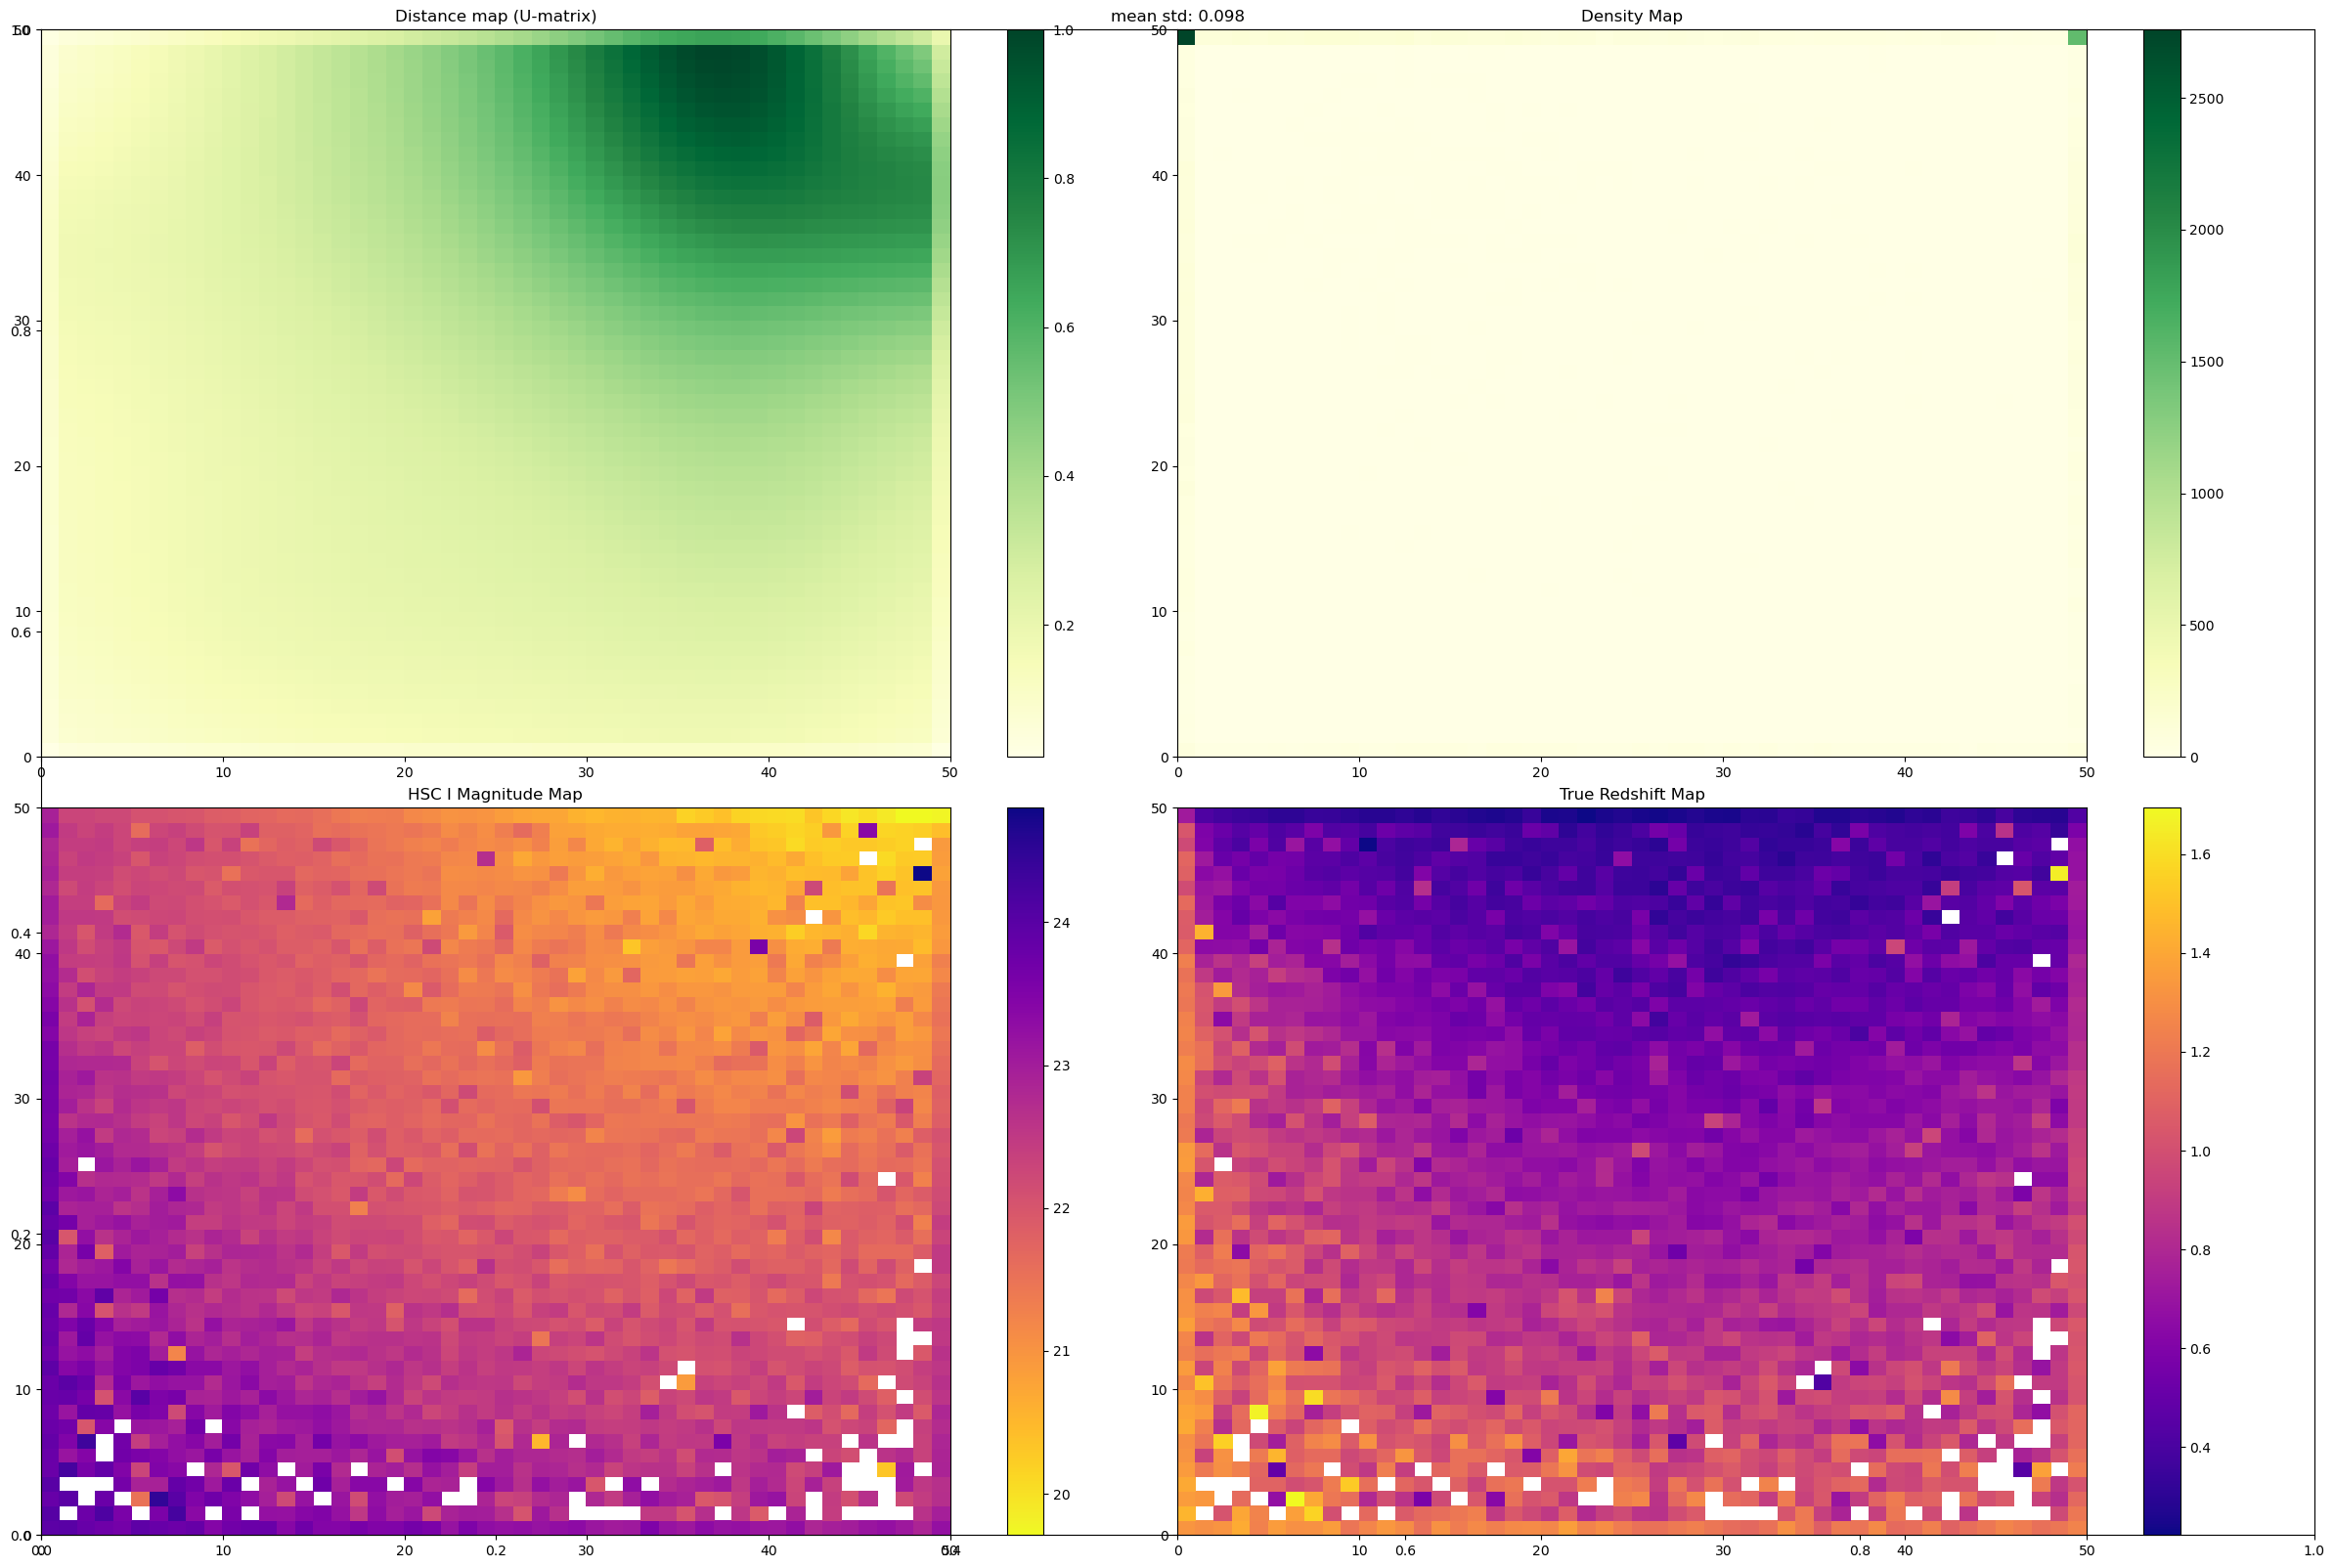

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[50, 20, 0.002]
29683.0
Topological error: 0.008557086547855674
Quantization error: 2.3194139314713893
Average redshift std: 0.09613917062642918


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


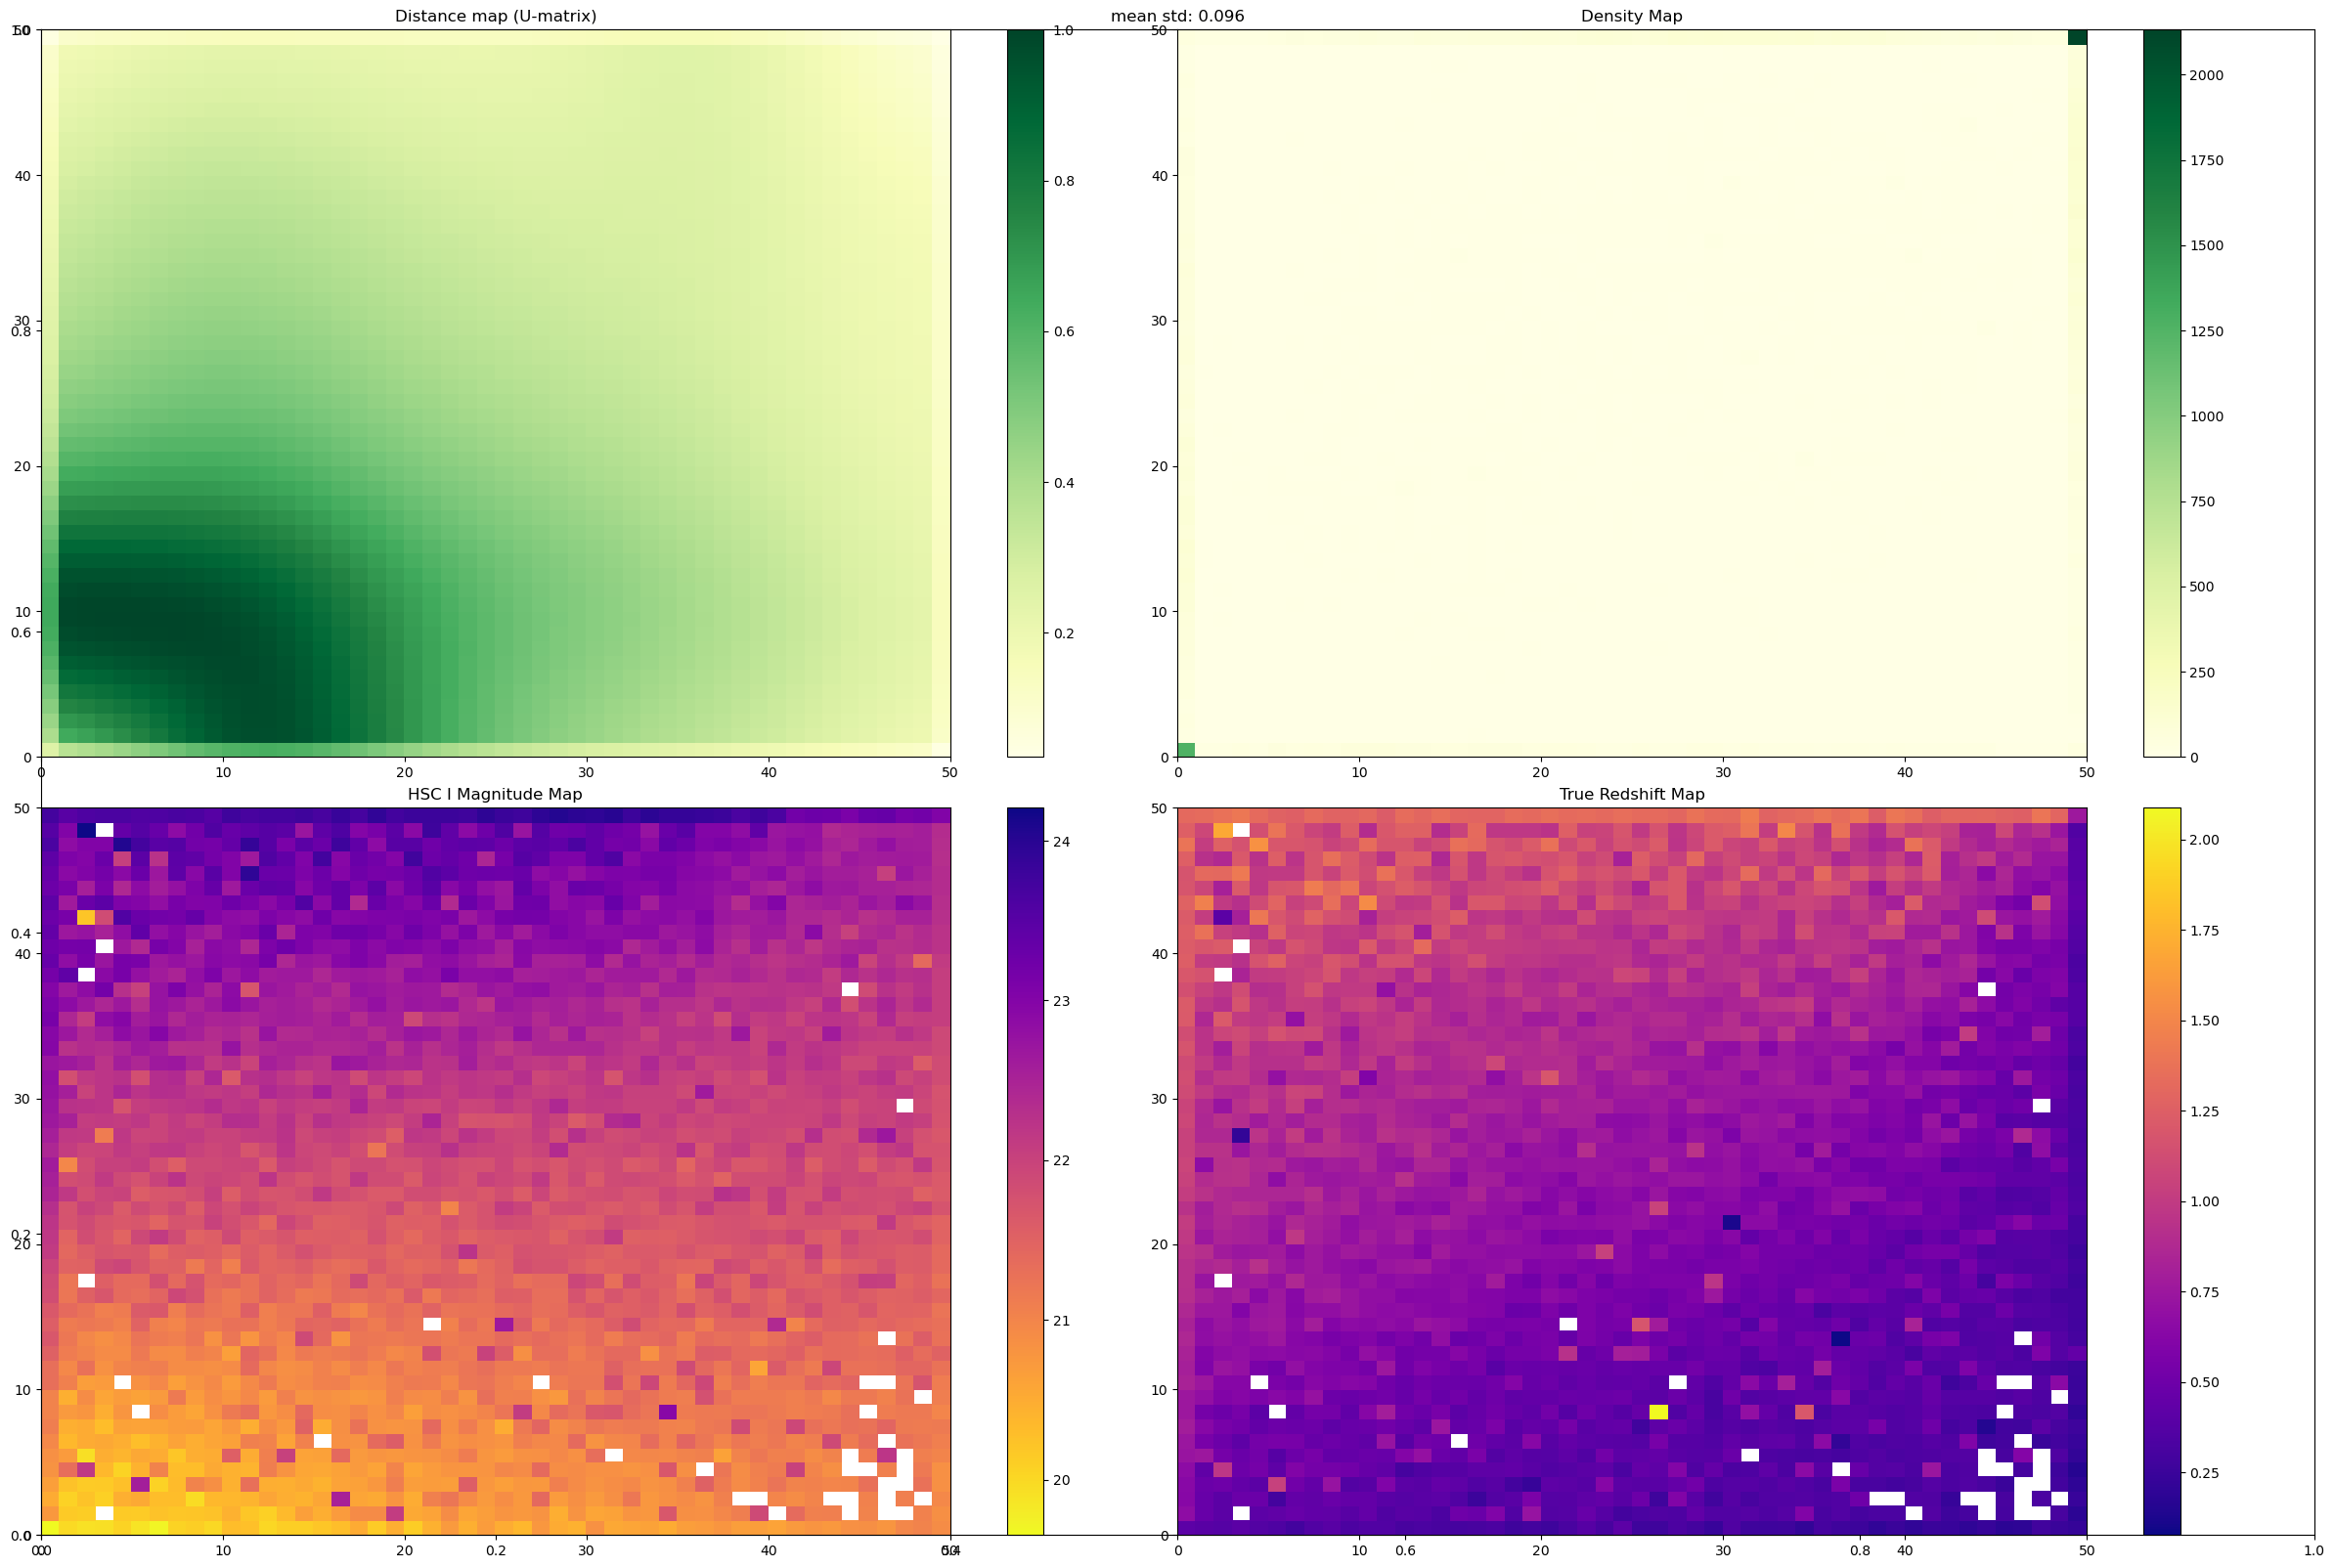

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[50, 20, 0.003]
29683.0
Topological error: 0.00714213522891891
Quantization error: 2.2964724161115115
Average redshift std: 0.0974258520622349


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


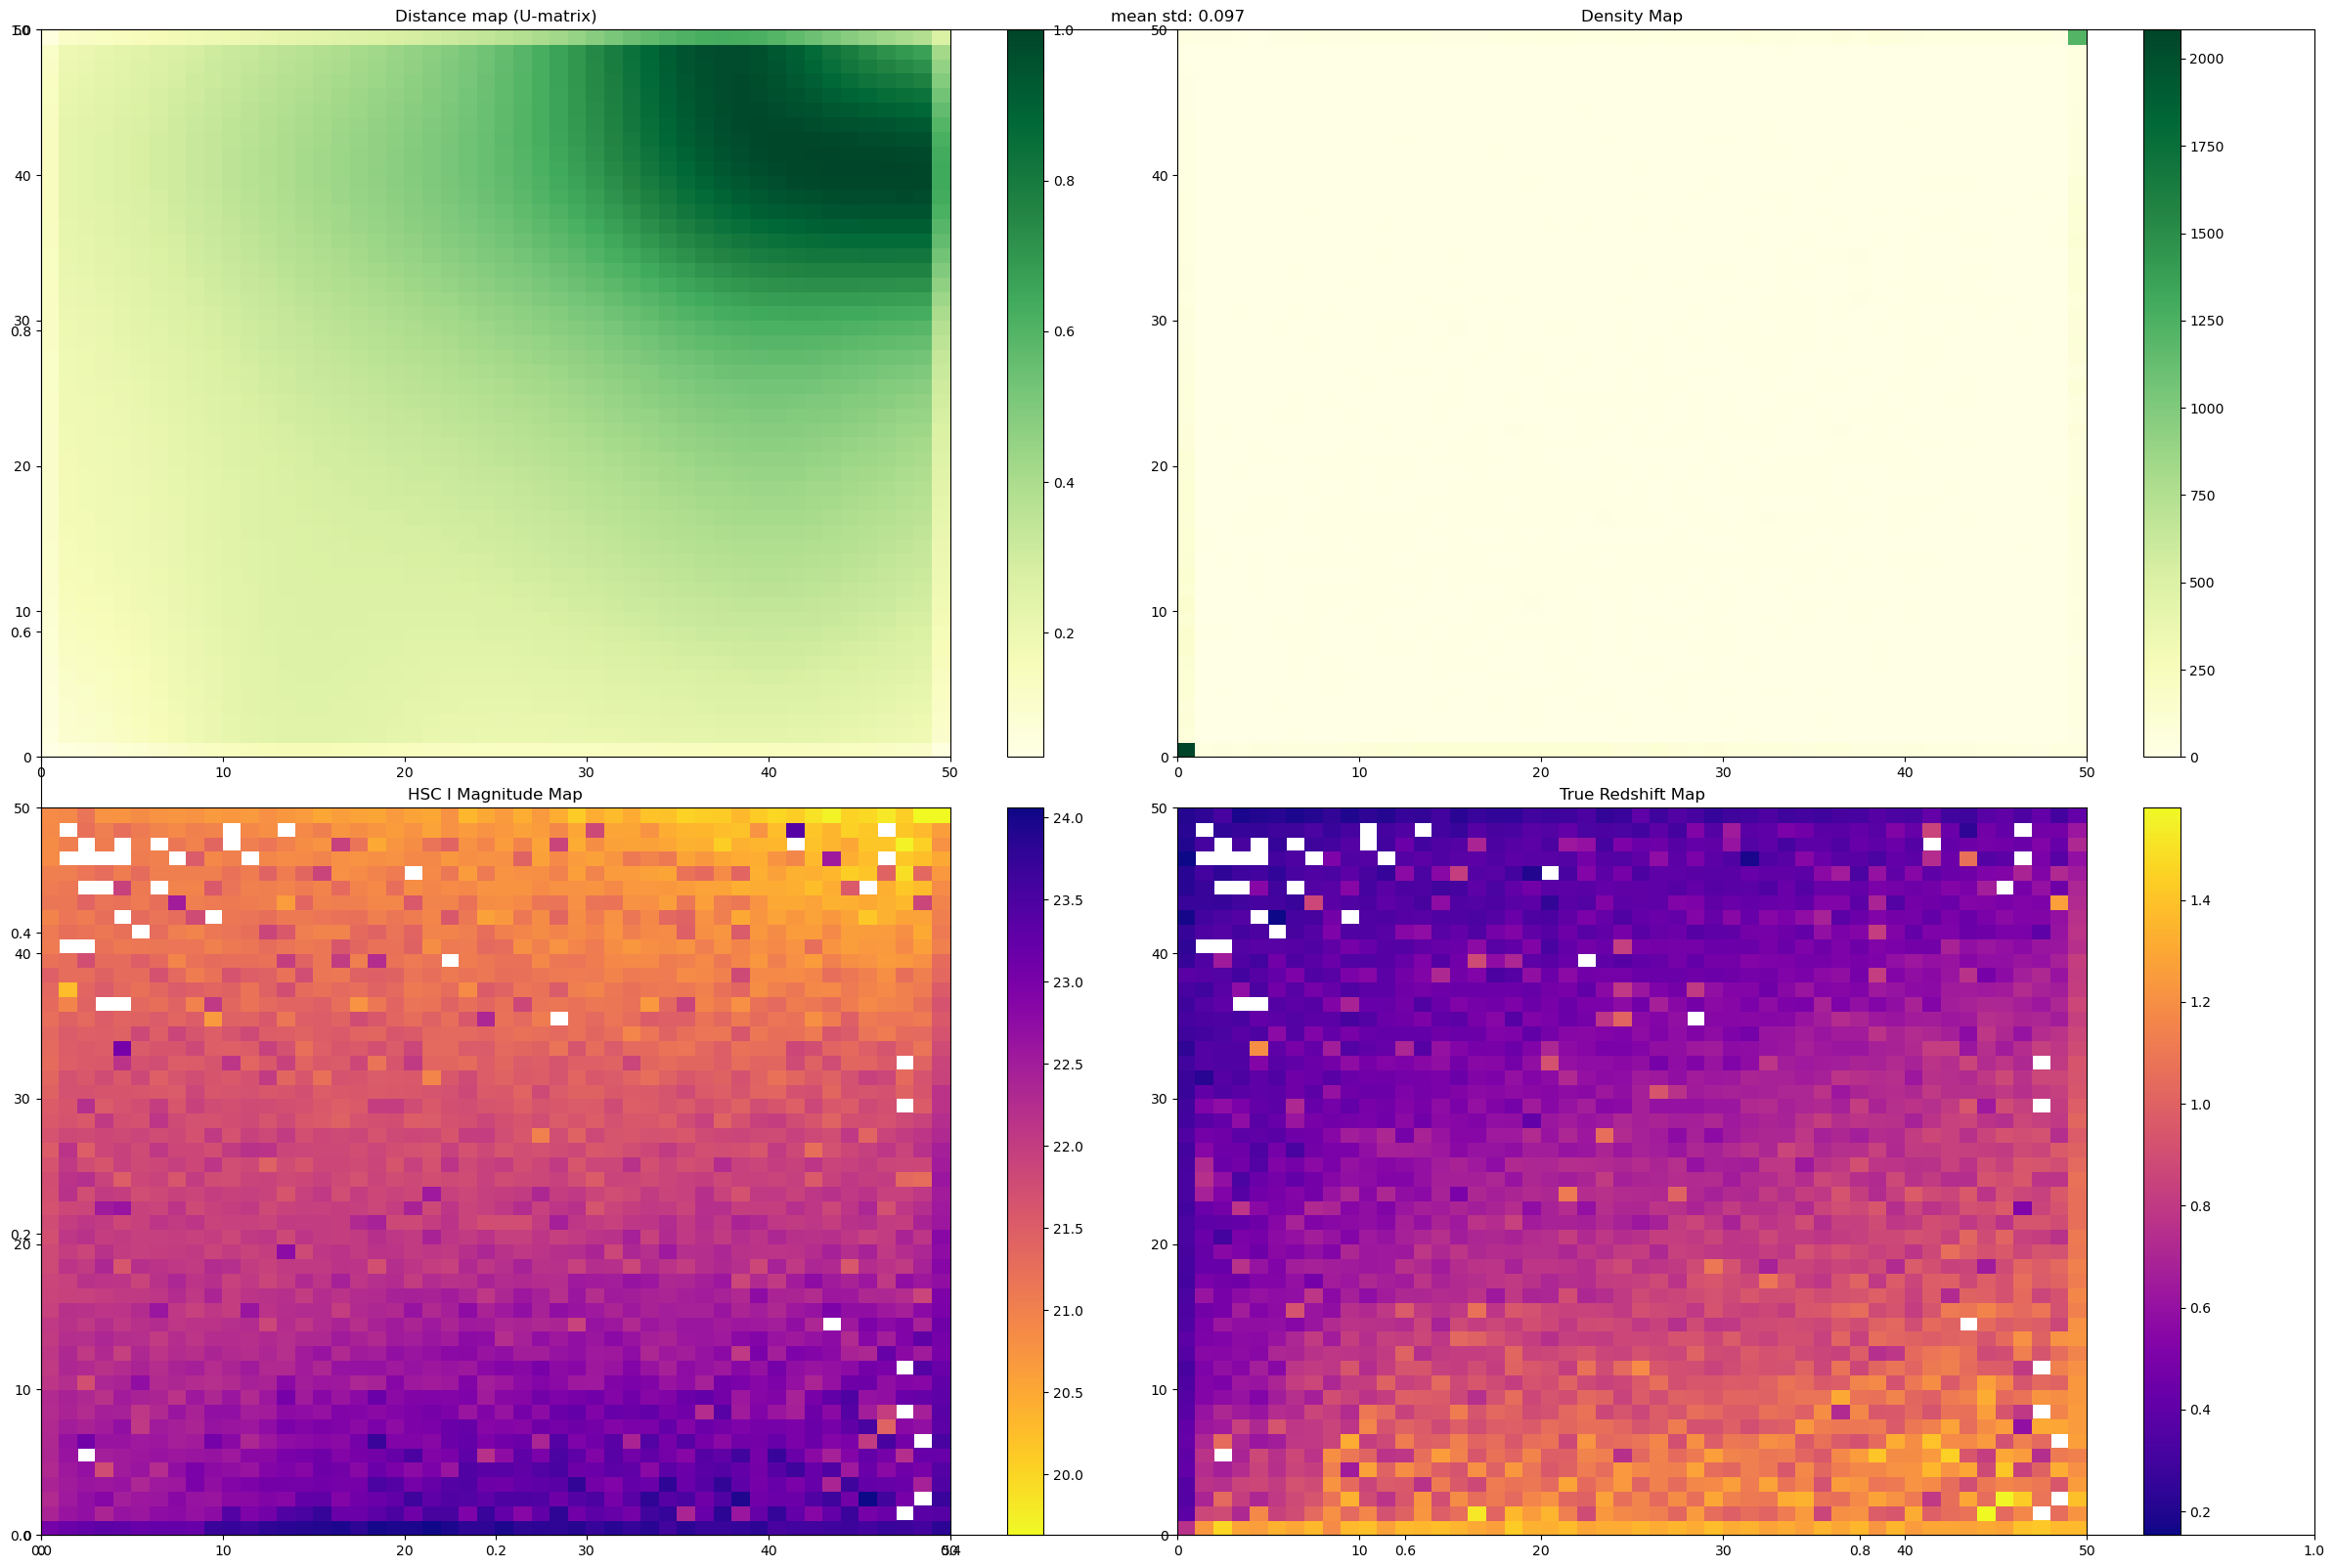

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[50, 20, 0.004]
29683.0
Topological error: 0.0074790284000943305
Quantization error: 2.286918795414849
Average redshift std: 0.0971092268083004


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


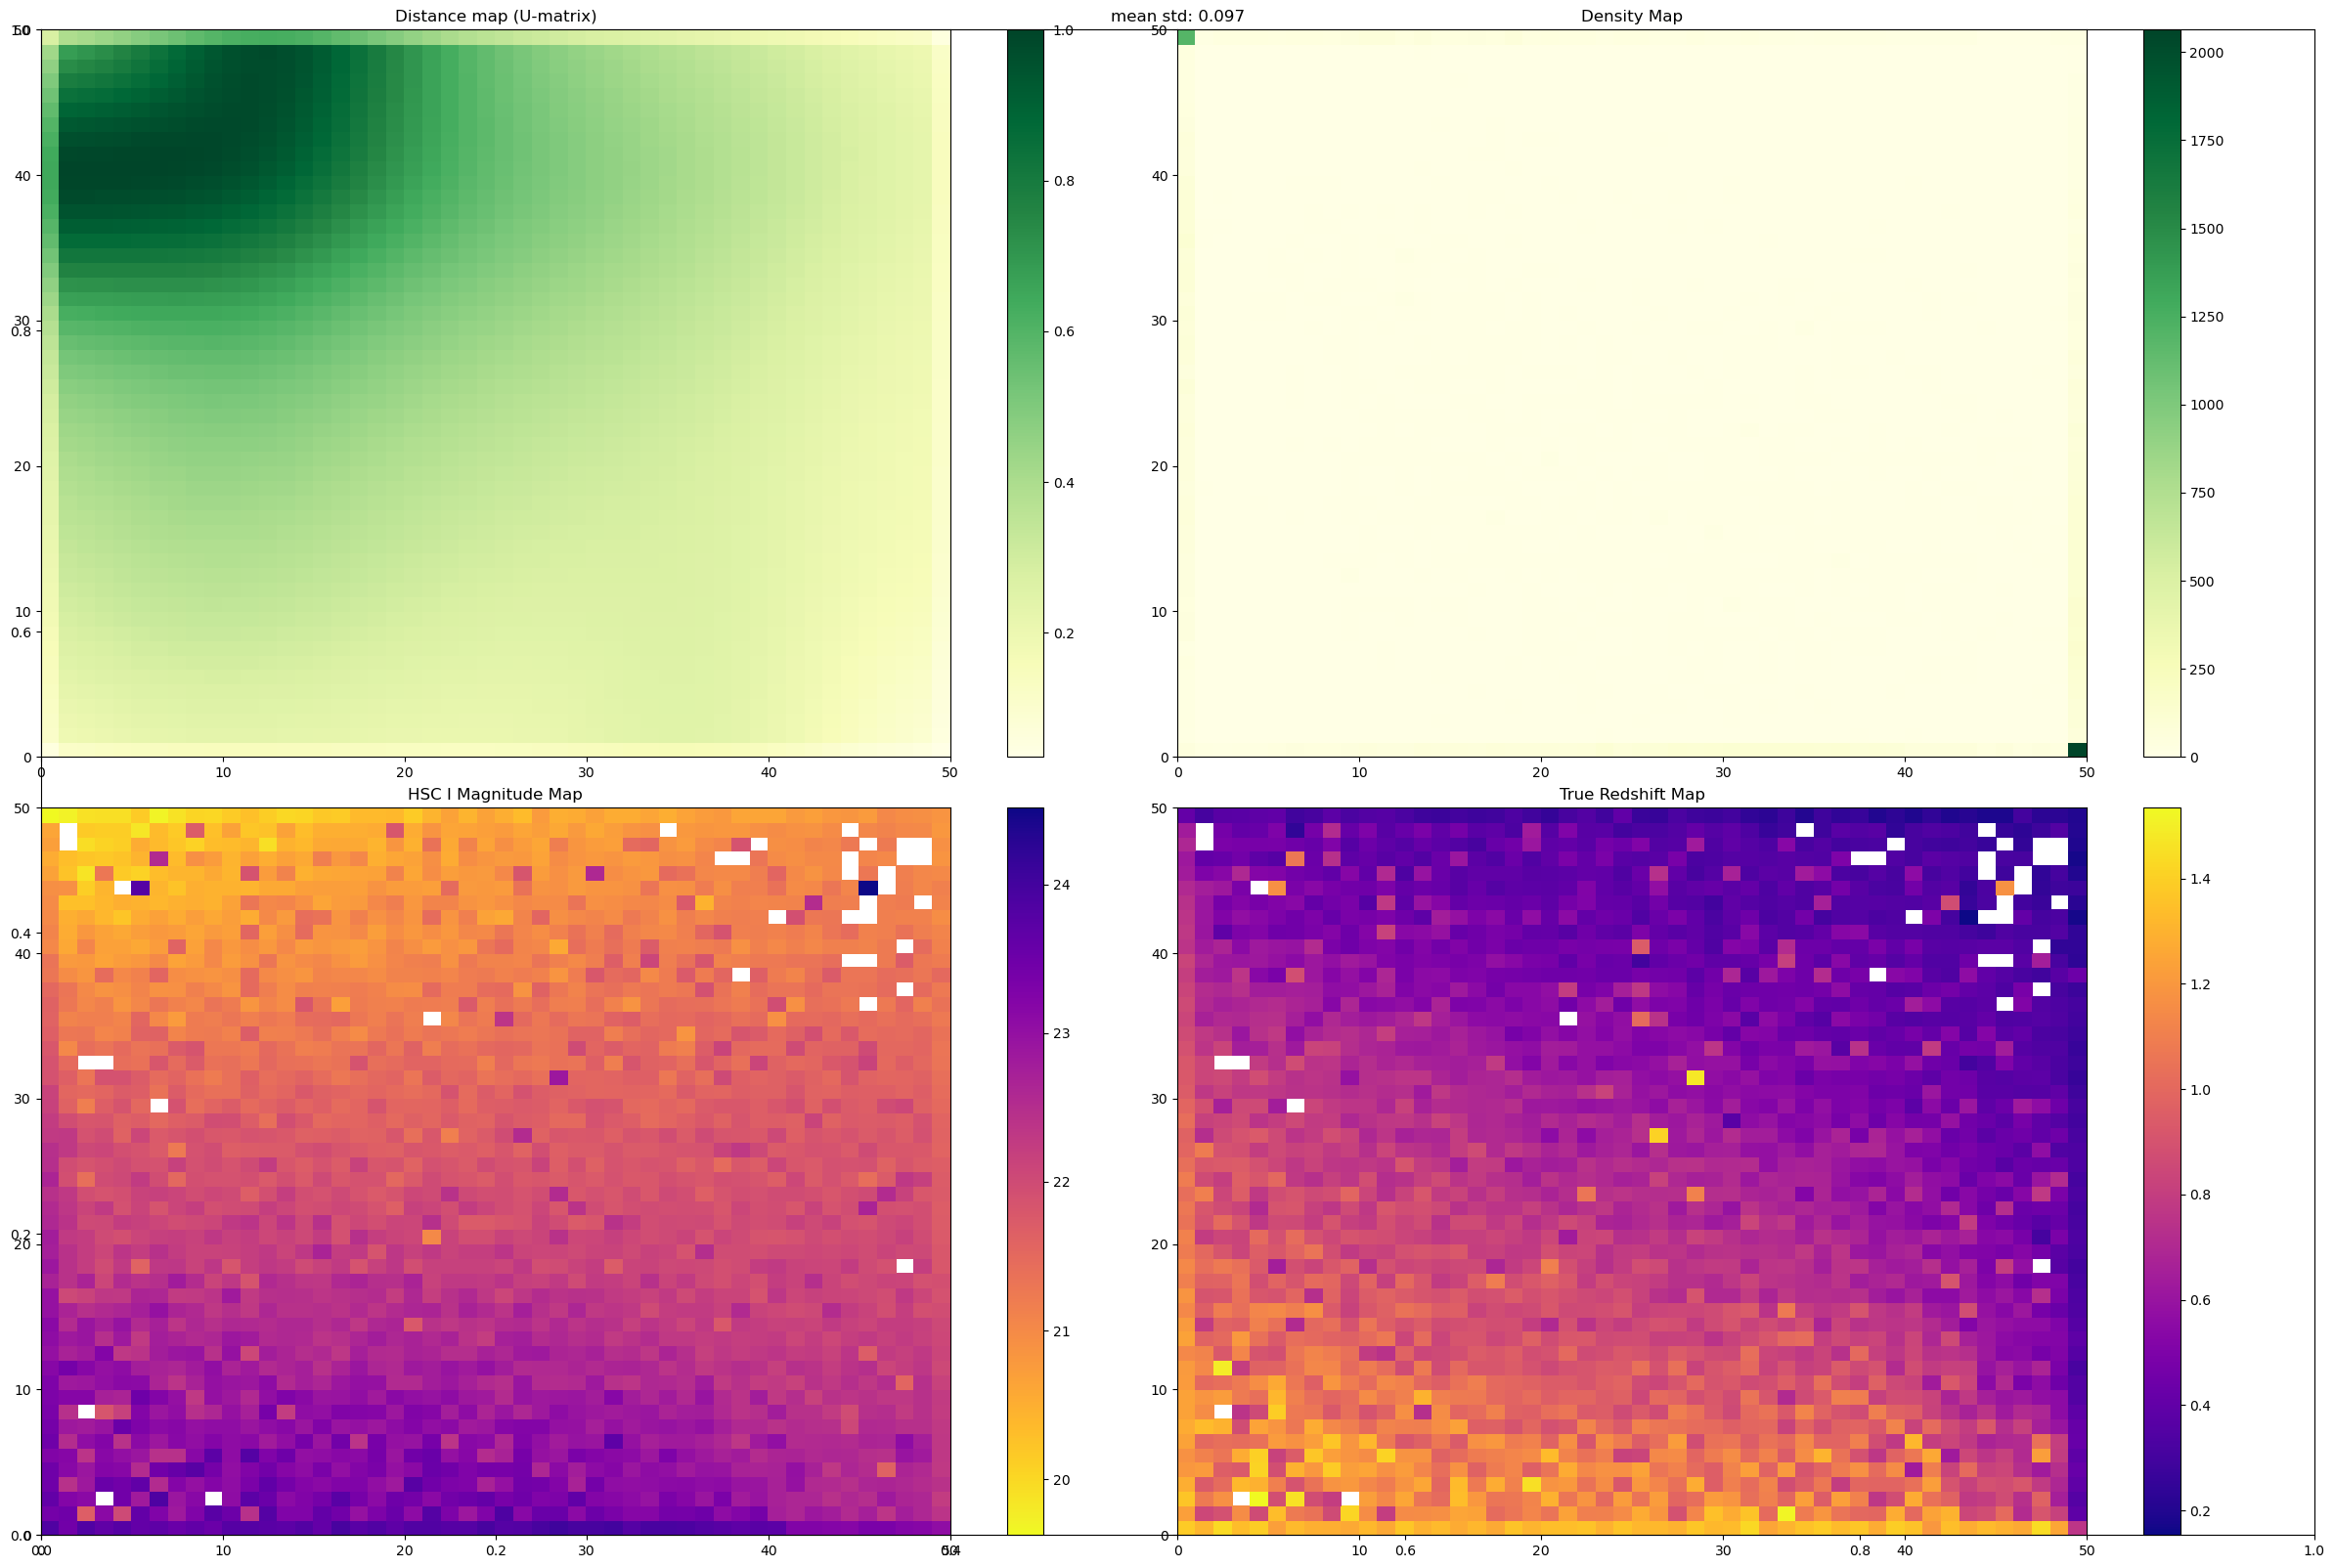

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[50, 20, 0.005]
29683.0
Topological error: 0.010881649428966075
Quantization error: 2.351478308978402
Average redshift std: 0.09864563141914952


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


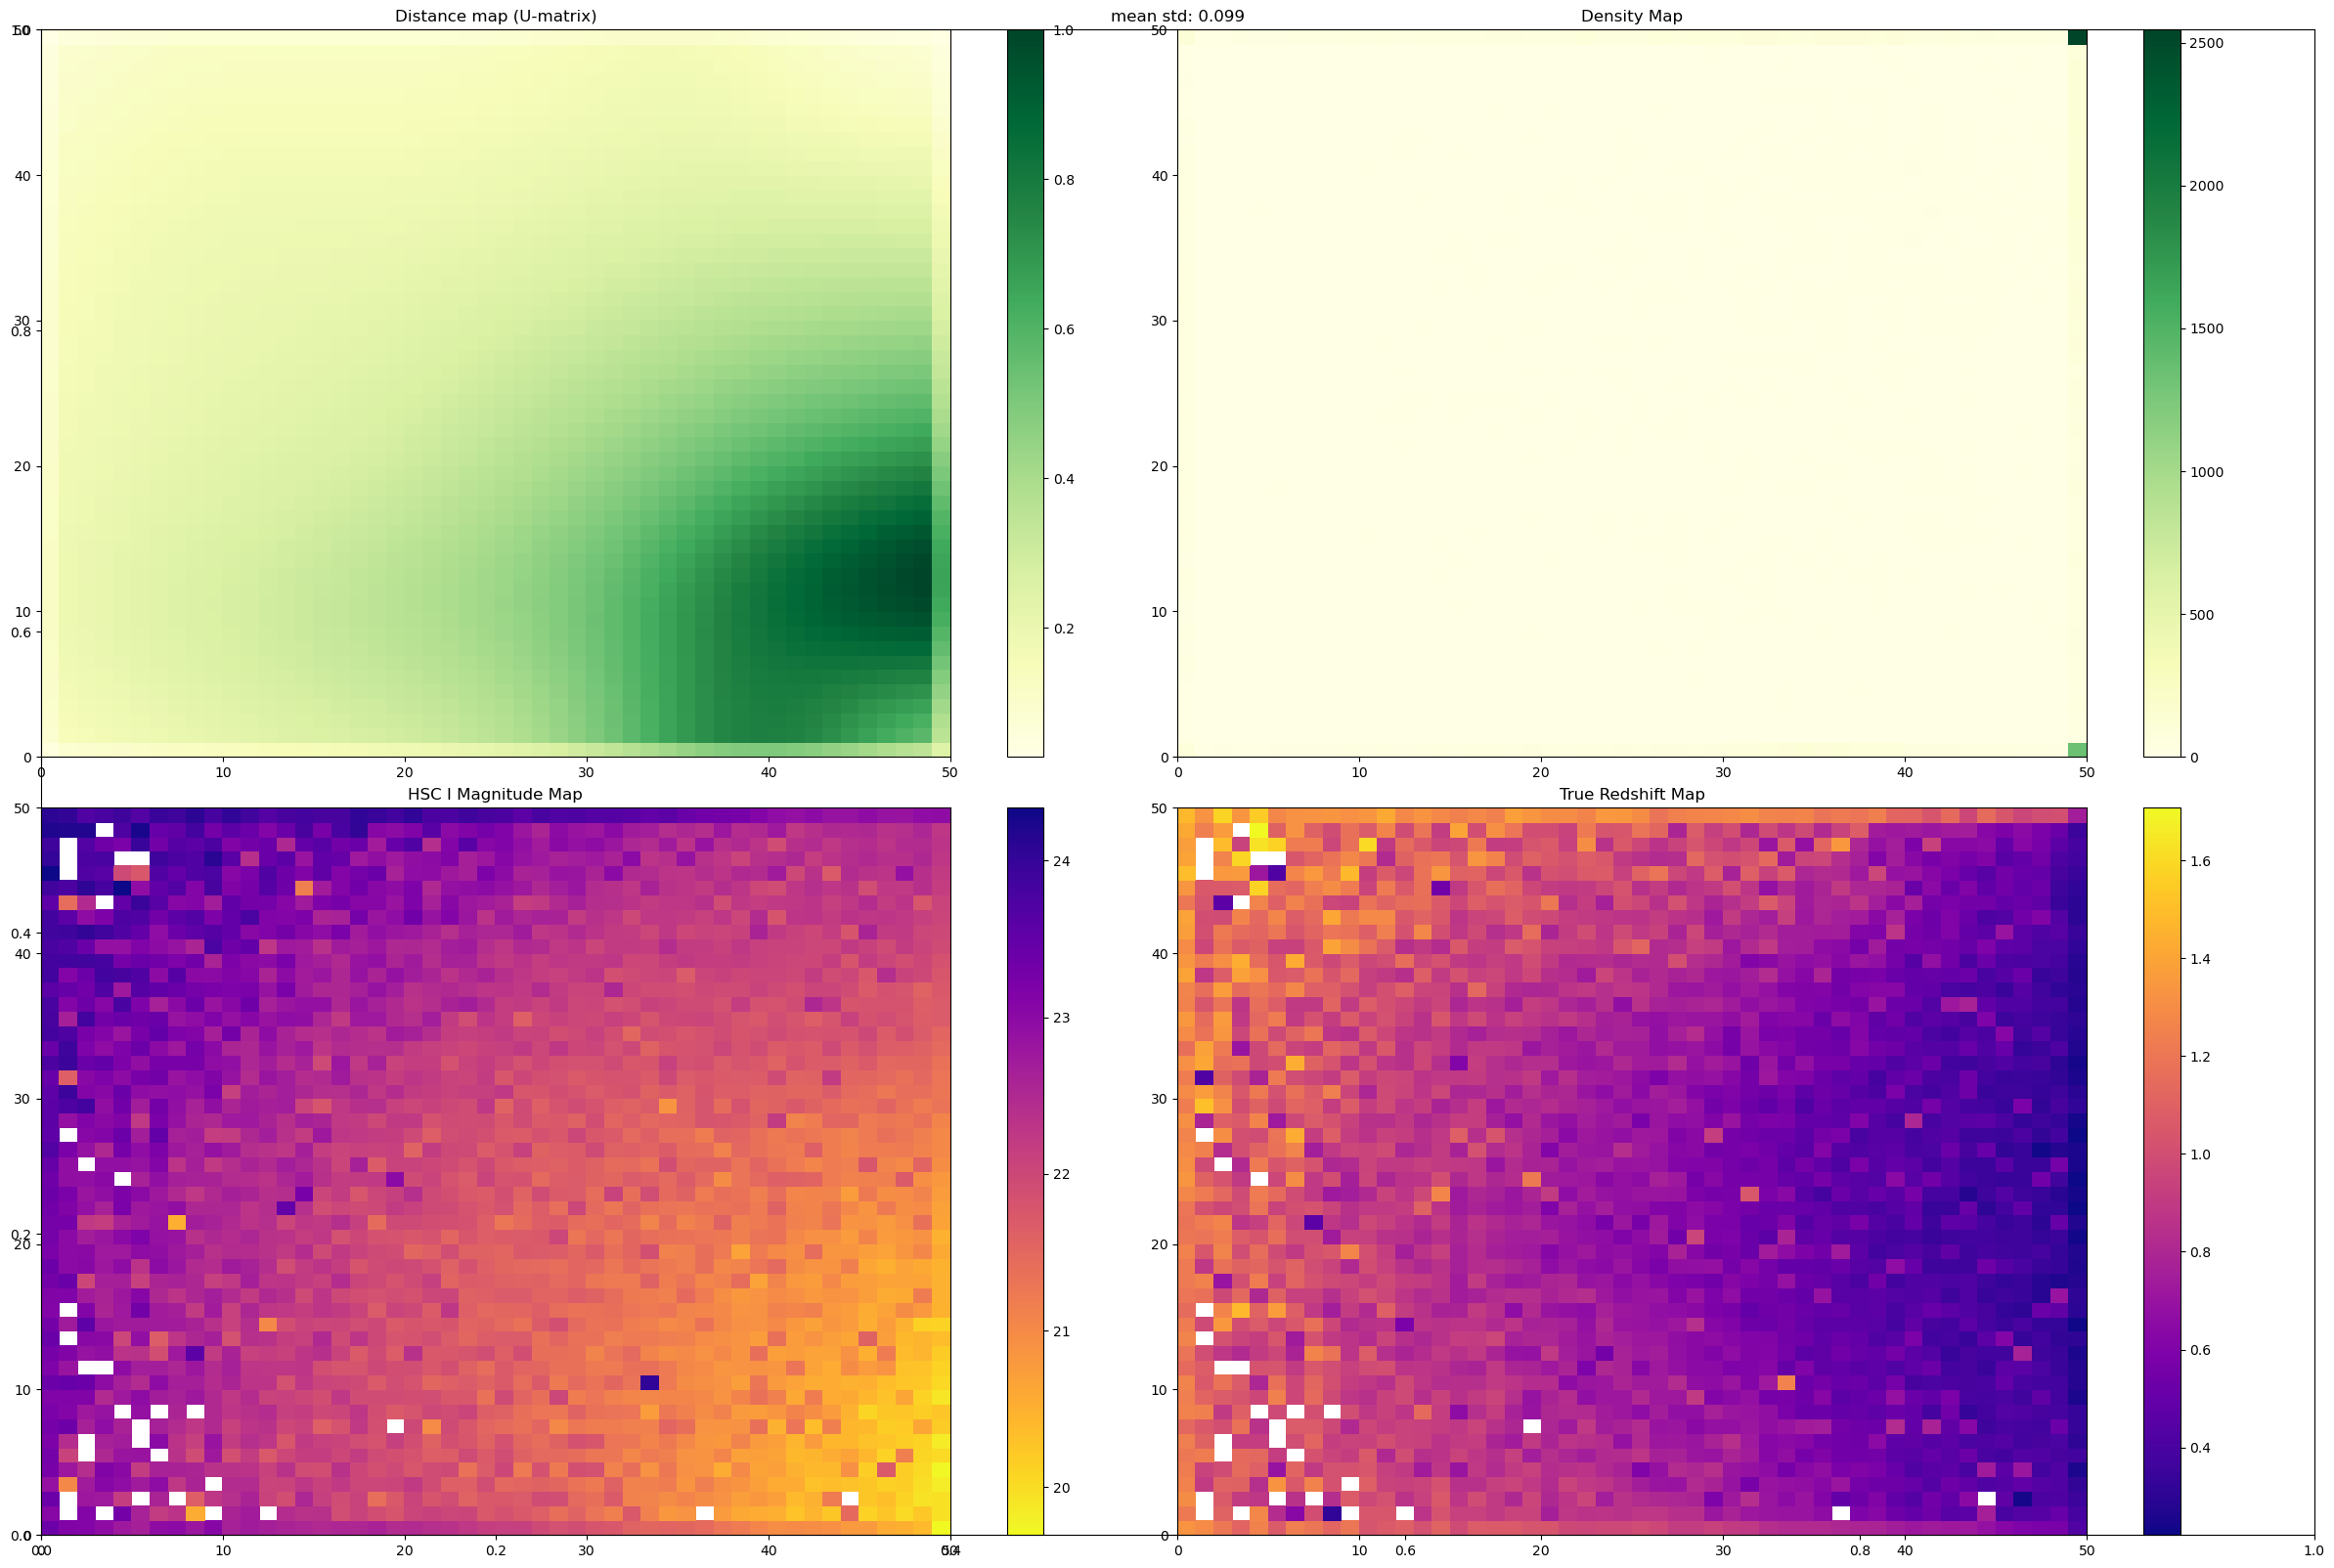

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[50, 20, 0.006]
29683.0
Topological error: 0.01115116396590641
Quantization error: 2.349697514737836
Average redshift std: 0.0987389077576329


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


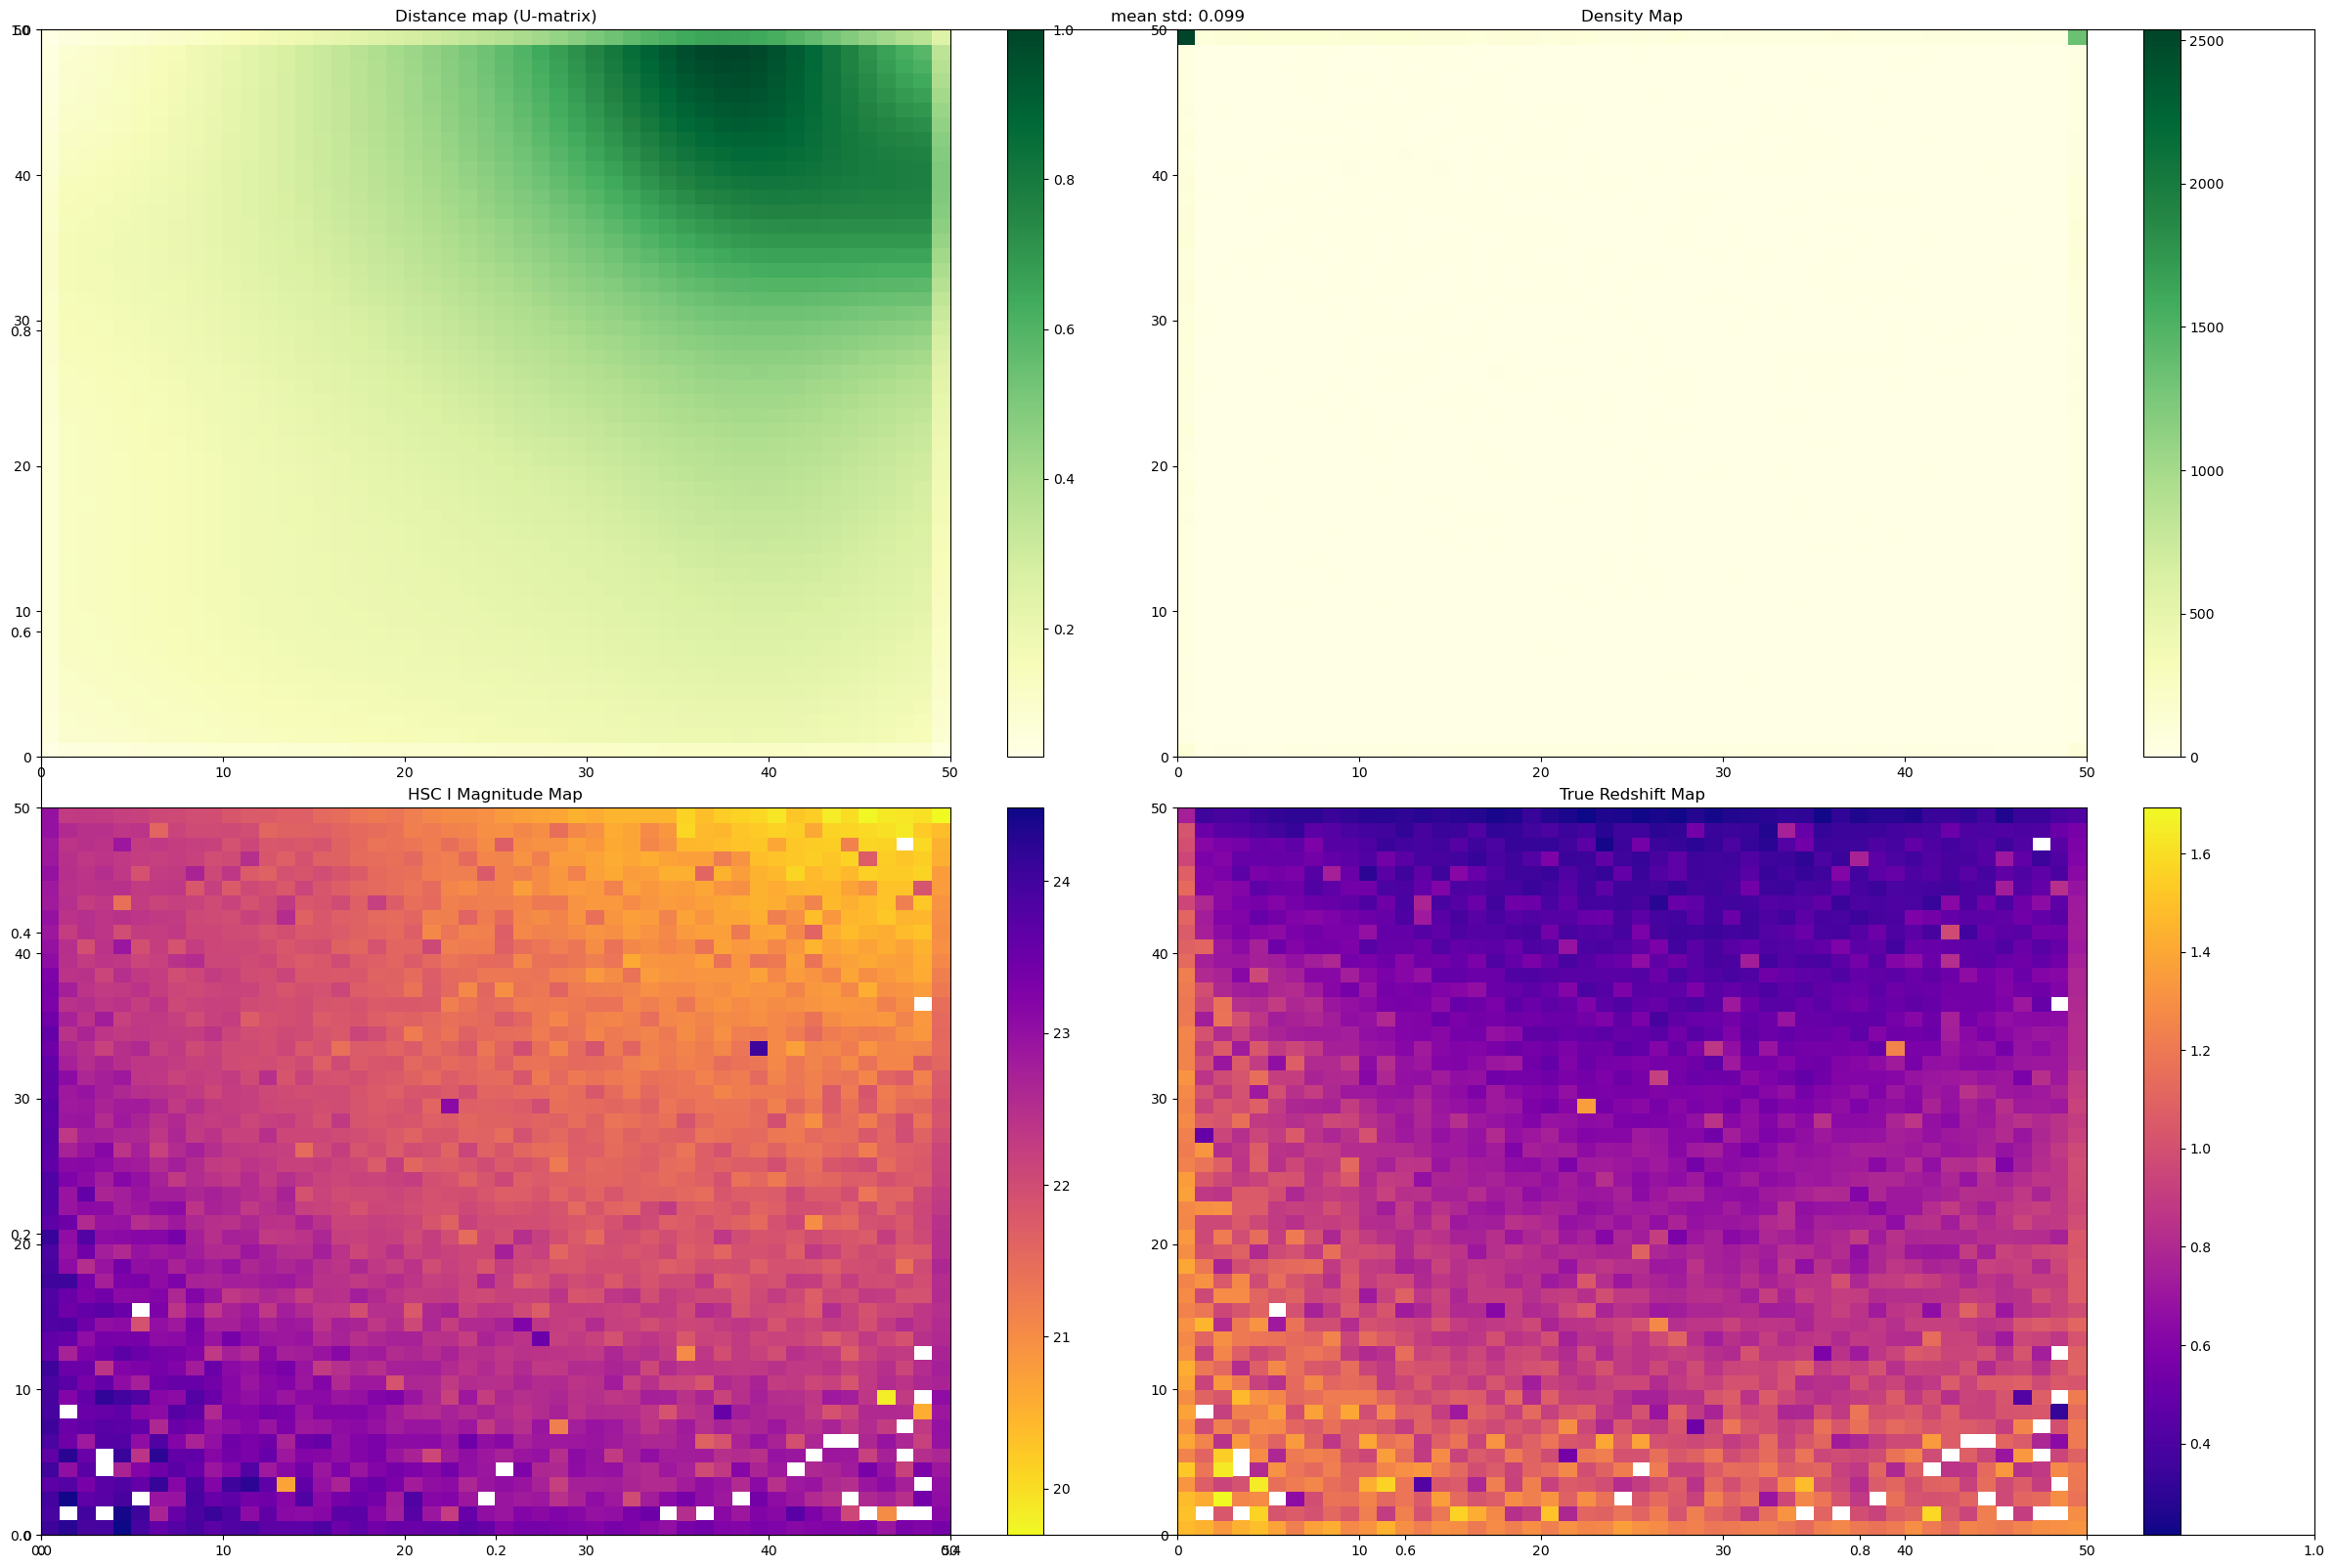

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[50, 20, 0.007]
29683.0
Topological error: 0.007074756594683825
Quantization error: 2.280193430955007
Average redshift std: 0.09742748833520157


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


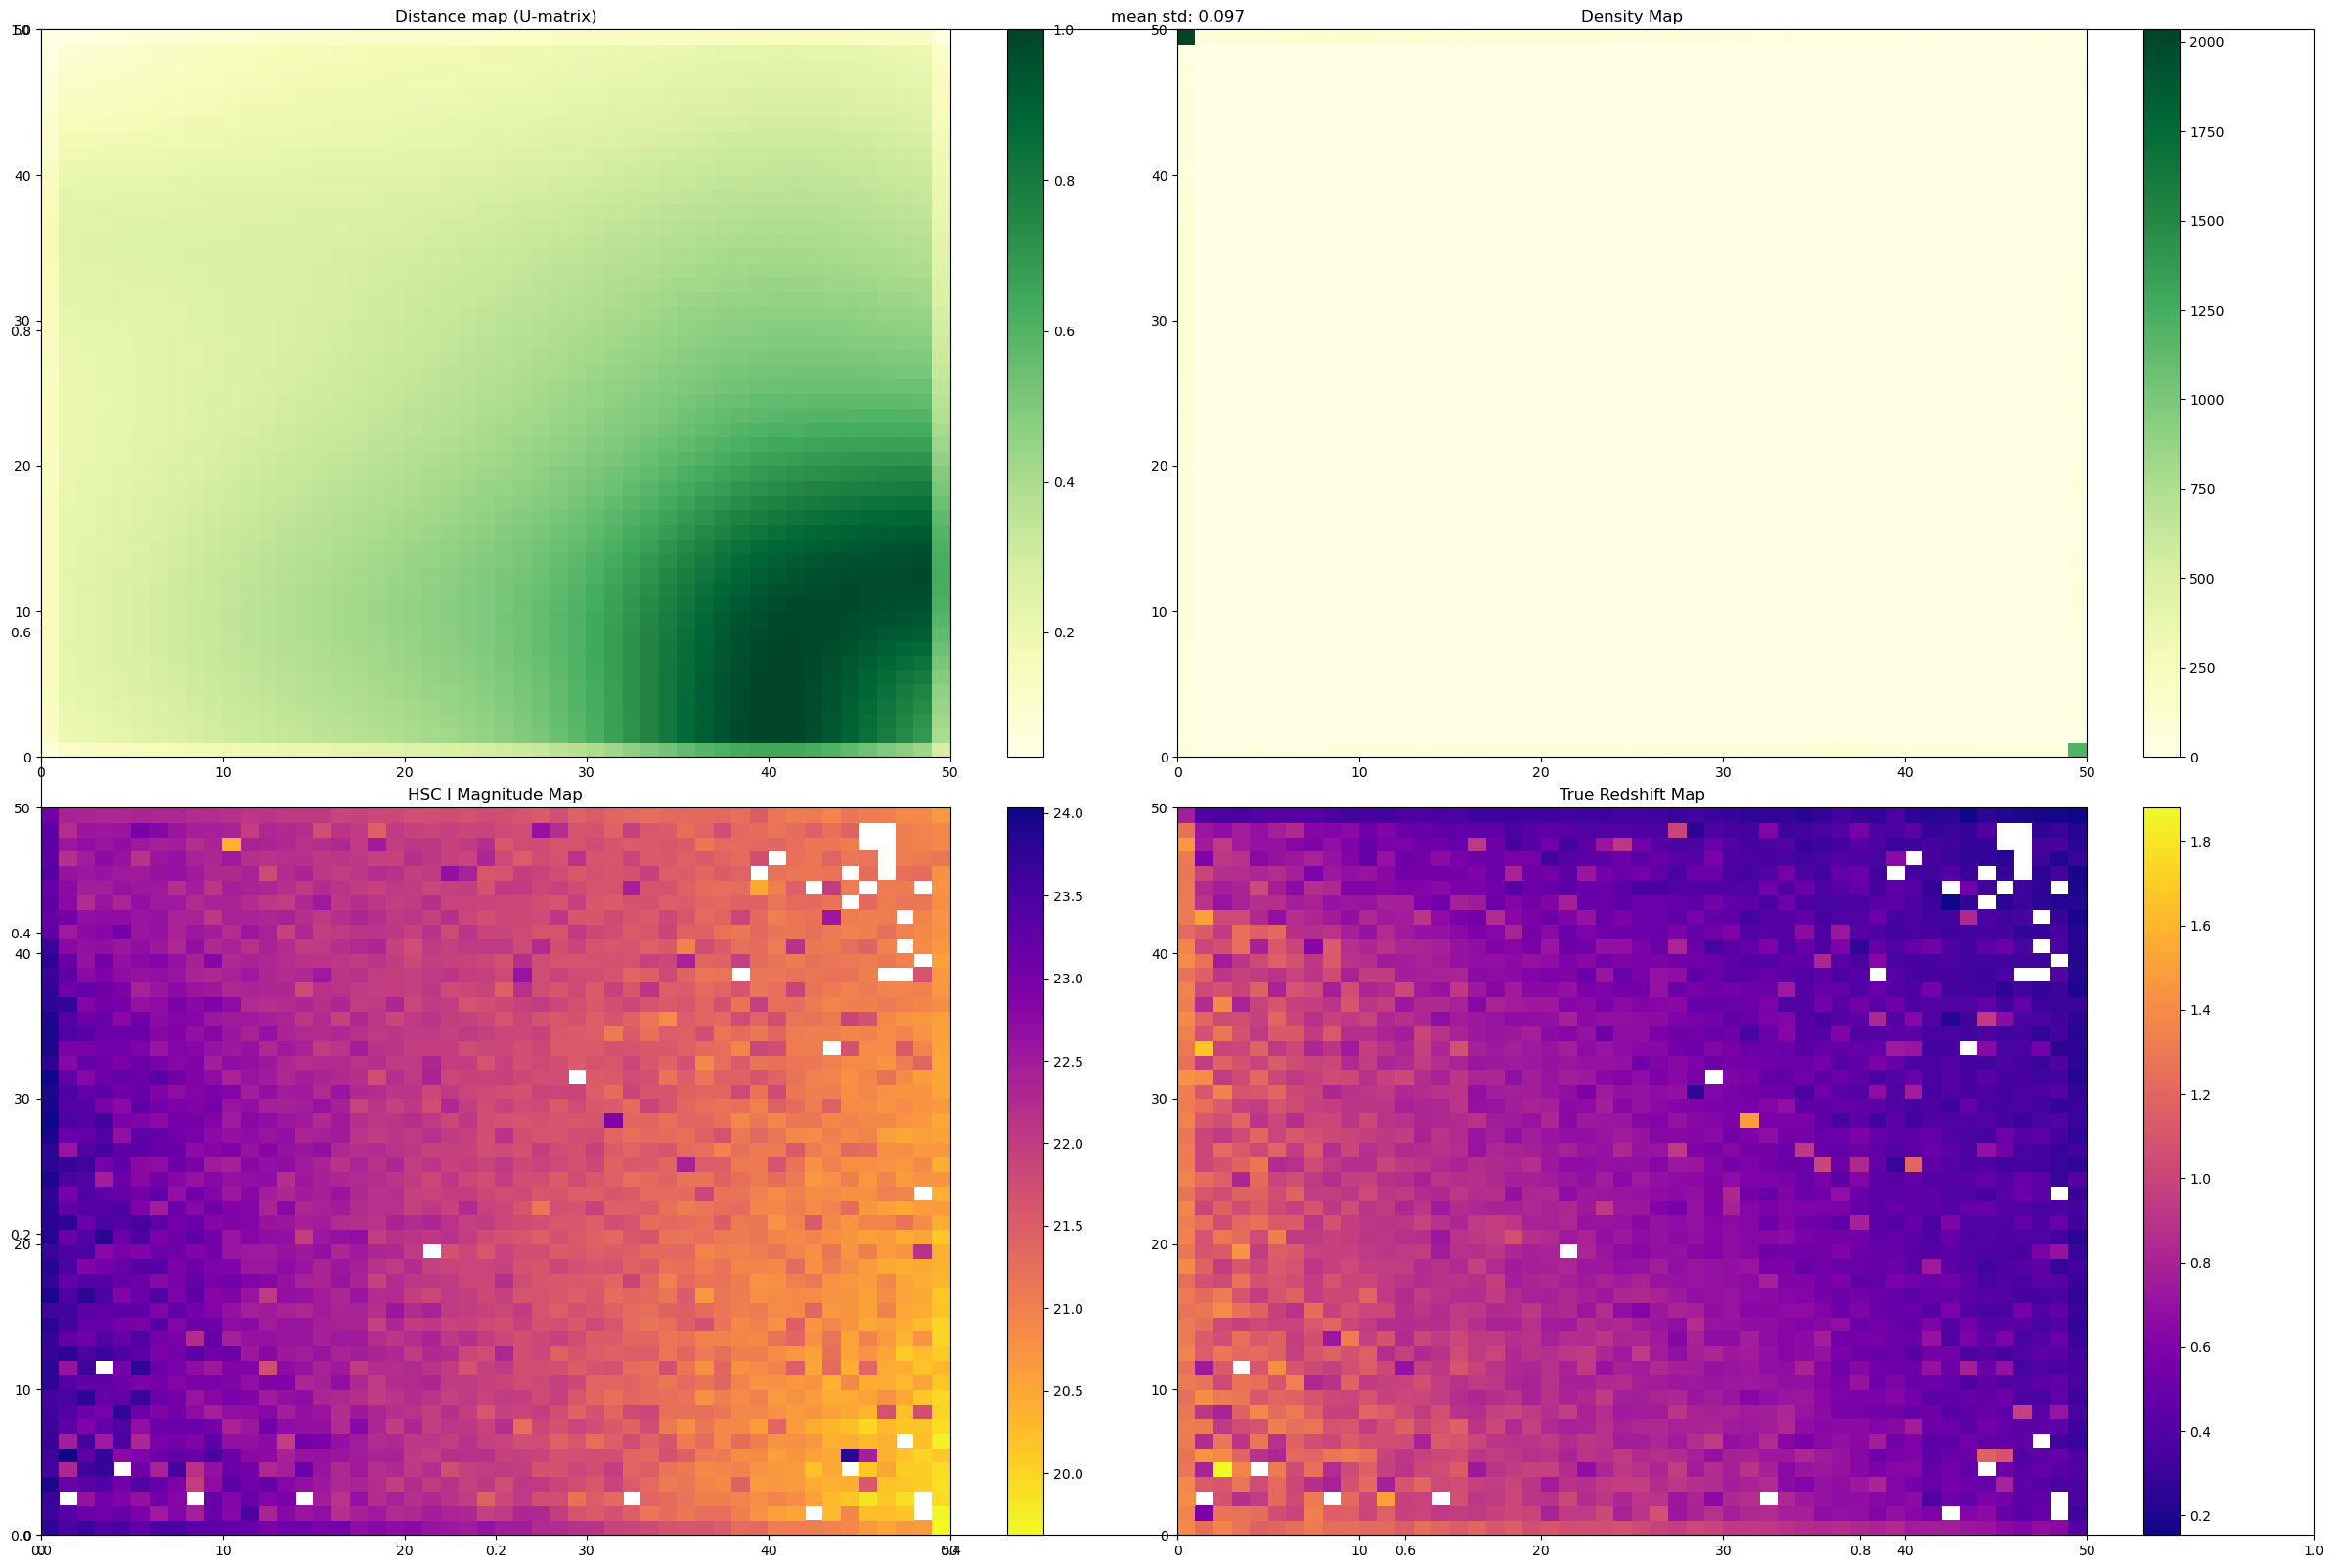

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[50, 20, 0.008]
29683.0
Topological error: 0.0069736886433311995
Quantization error: 2.2800614792015708
Average redshift std: 0.0971415196909578


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


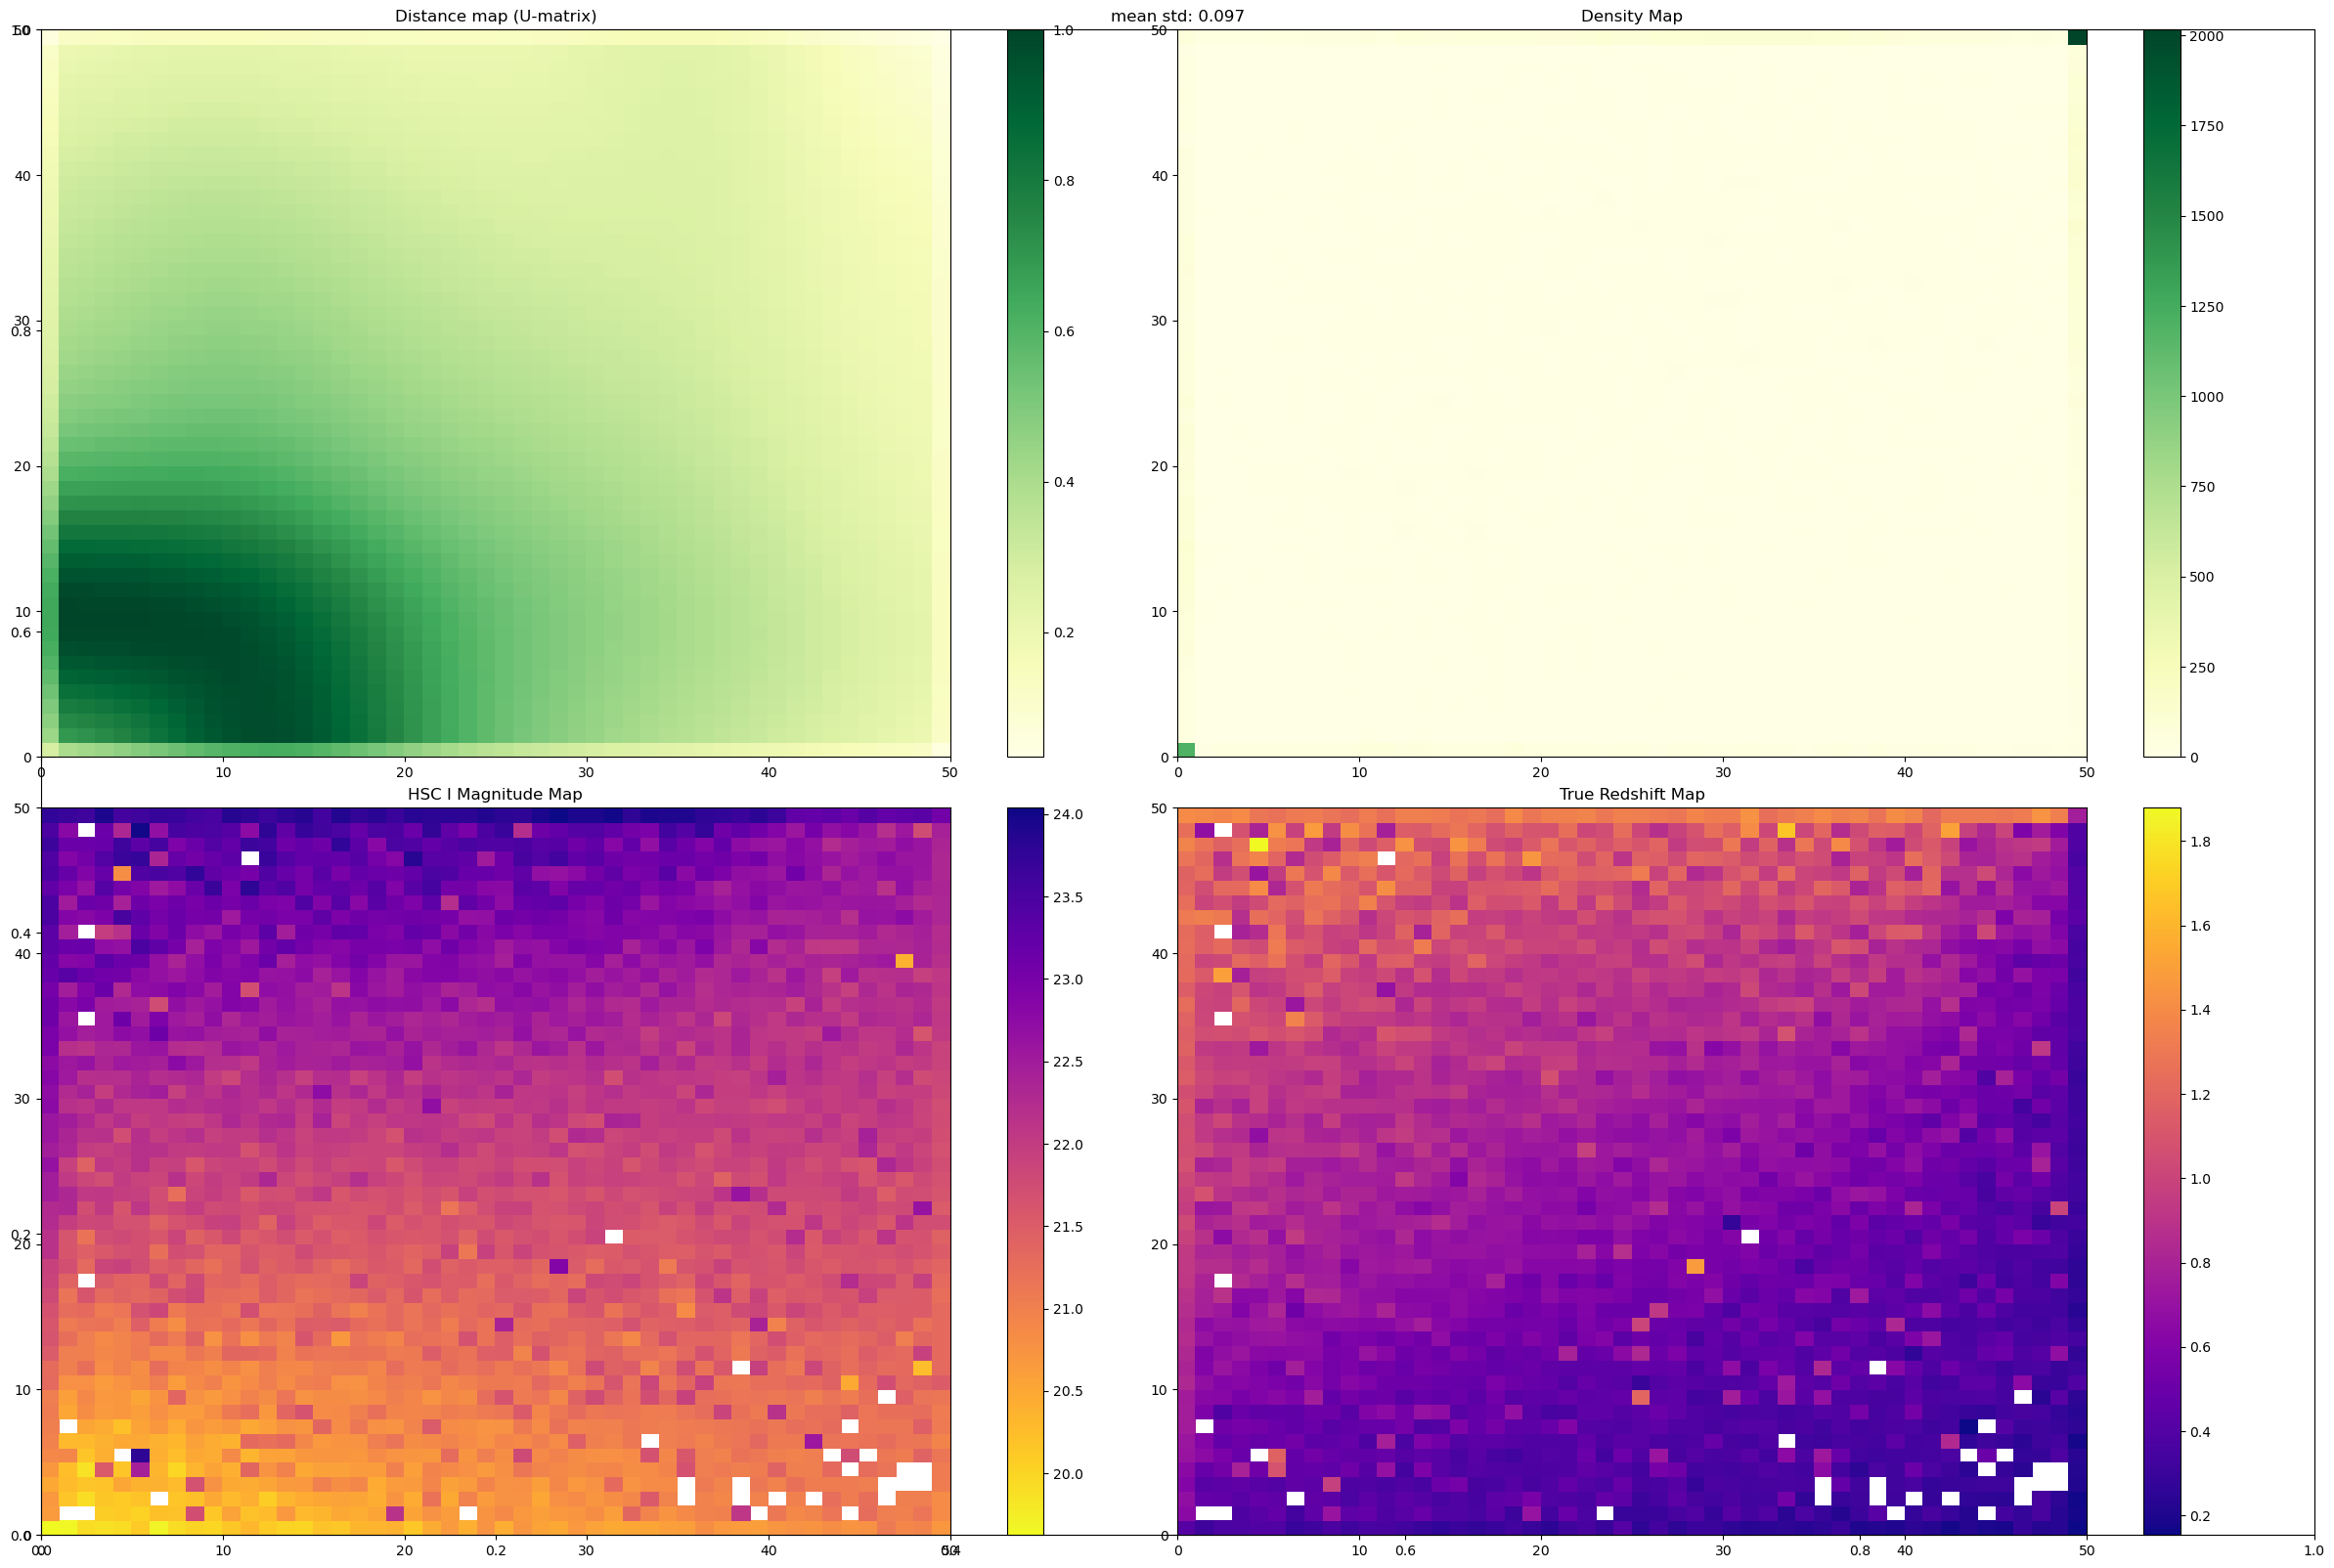

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[50, 20, 0.009]
29683.0
Topological error: 0.011824950308257252
Quantization error: 2.3491956388915165
Average redshift std: 0.09857748816502504


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


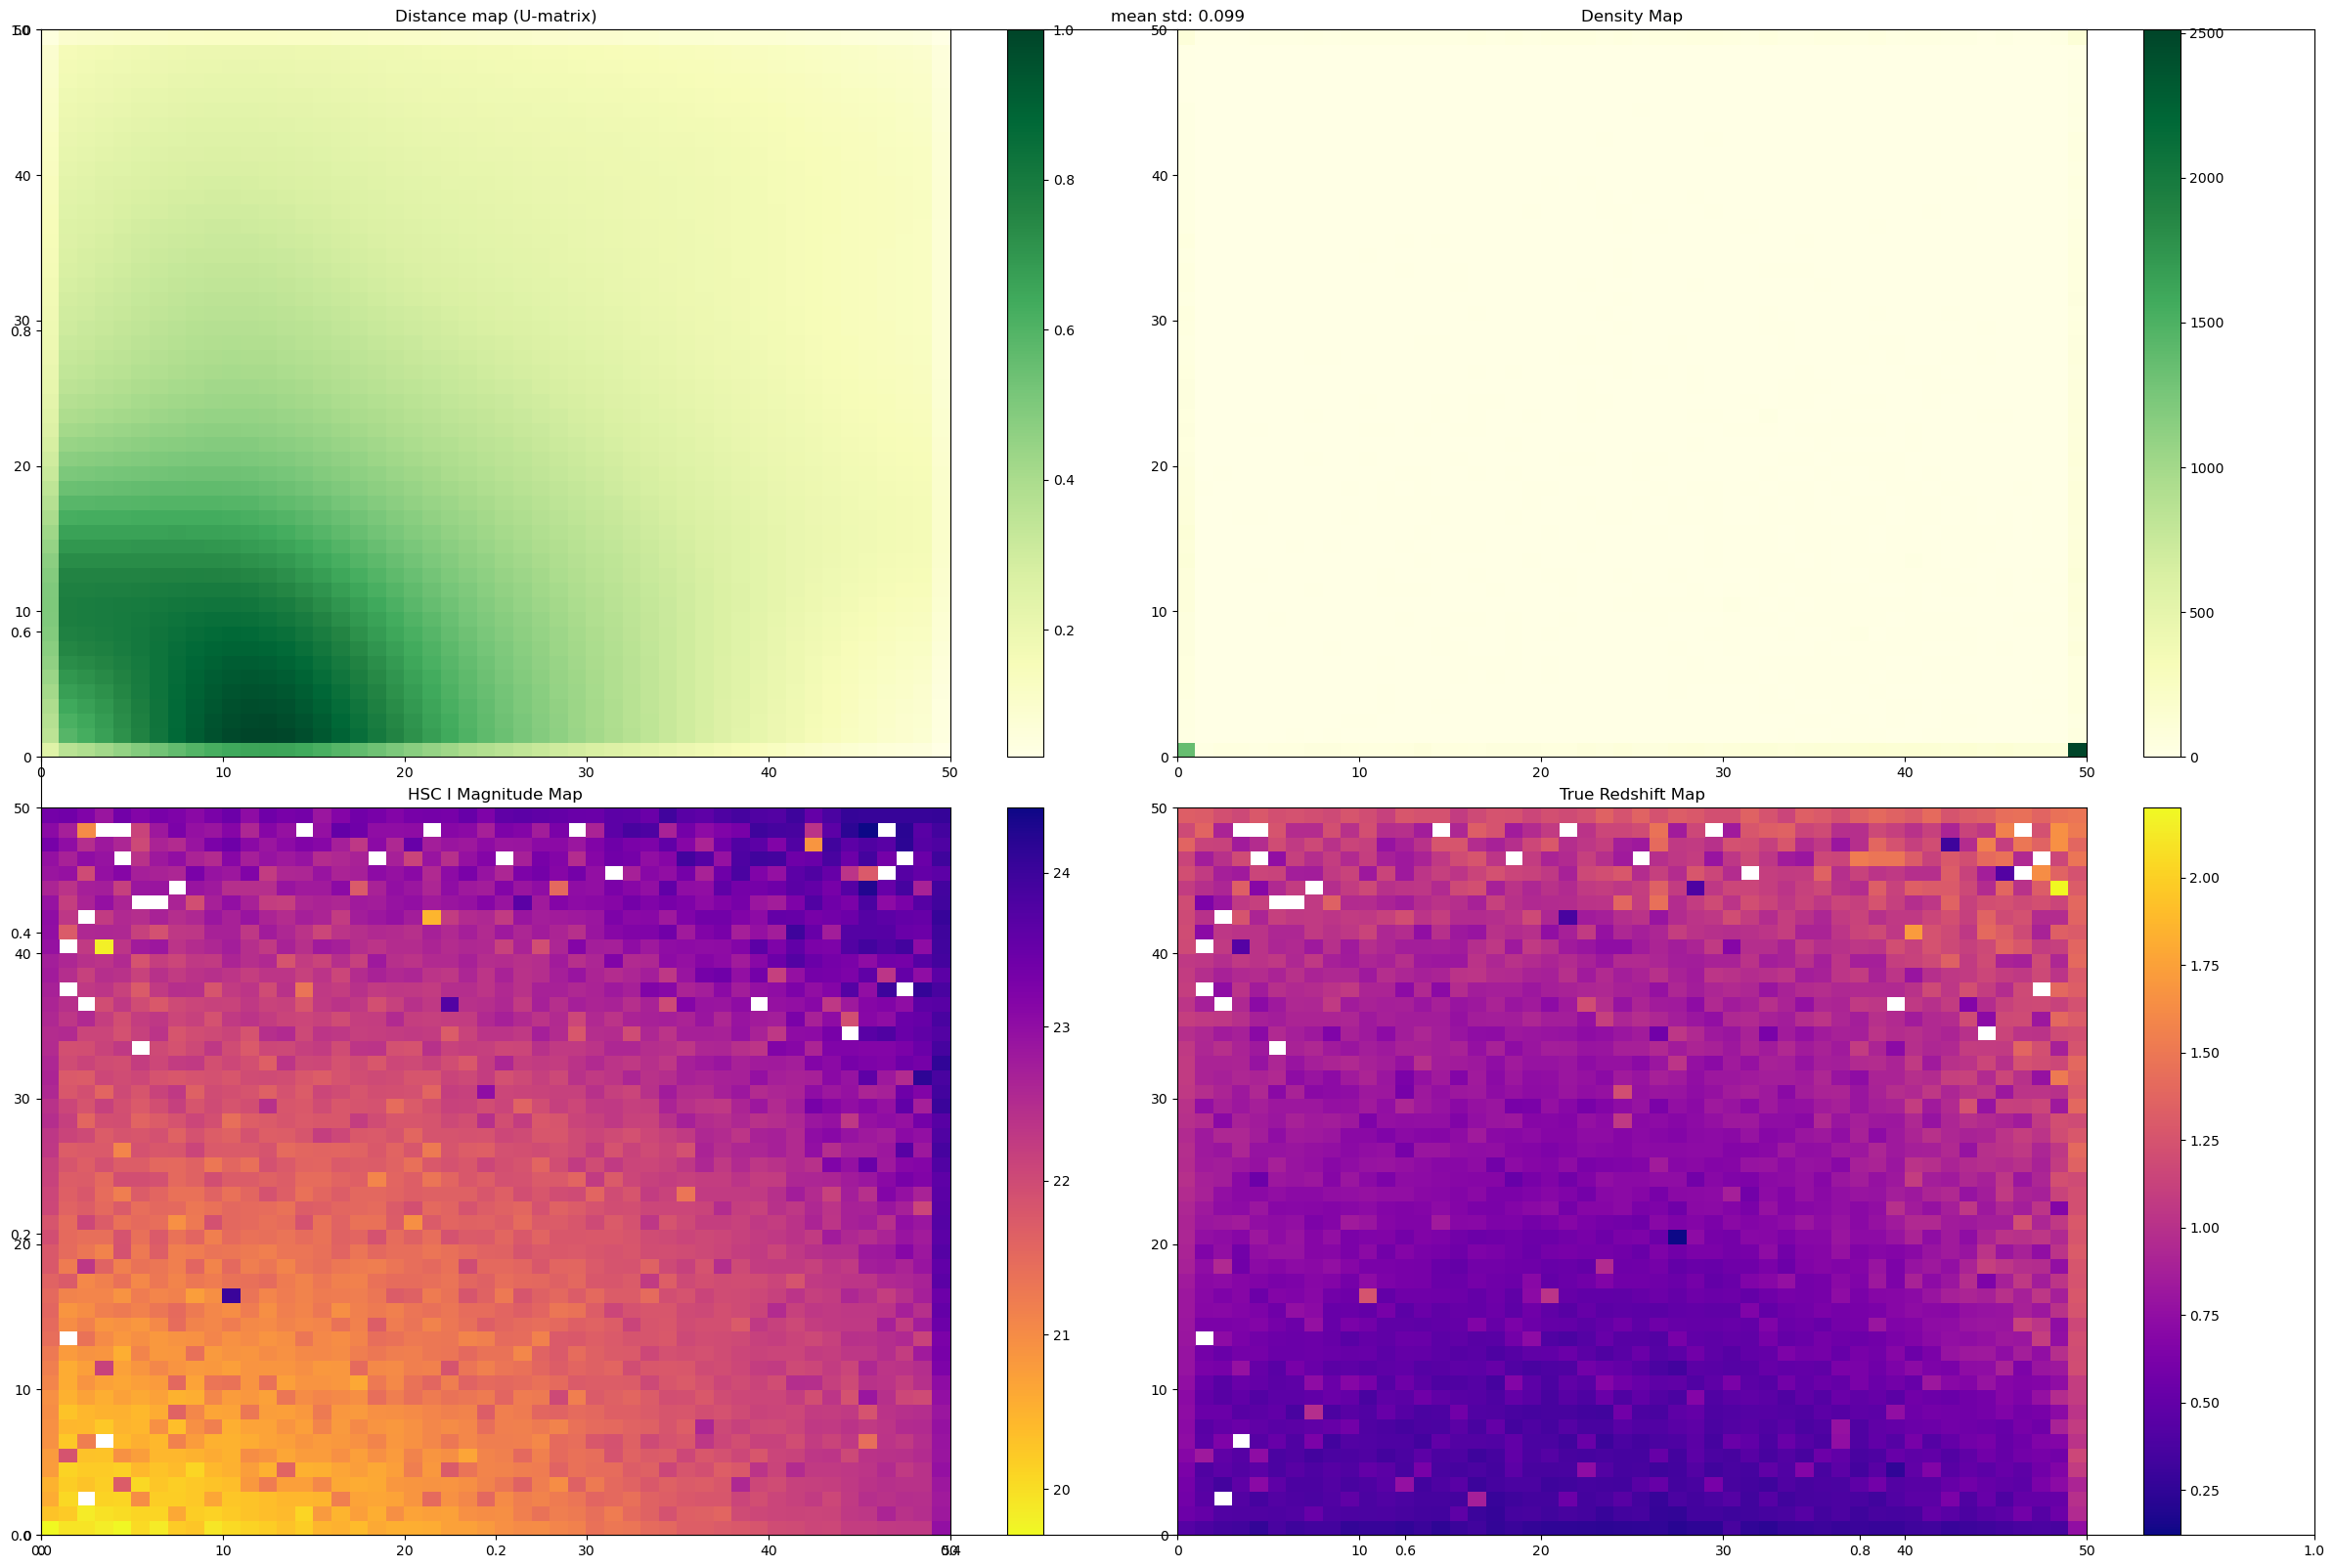

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[50, 20, 0.01]
29683.0
Topological error: 0.0069736886433311995
Quantization error: 2.2806472083833325
Average redshift std: 0.0971314086203148


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


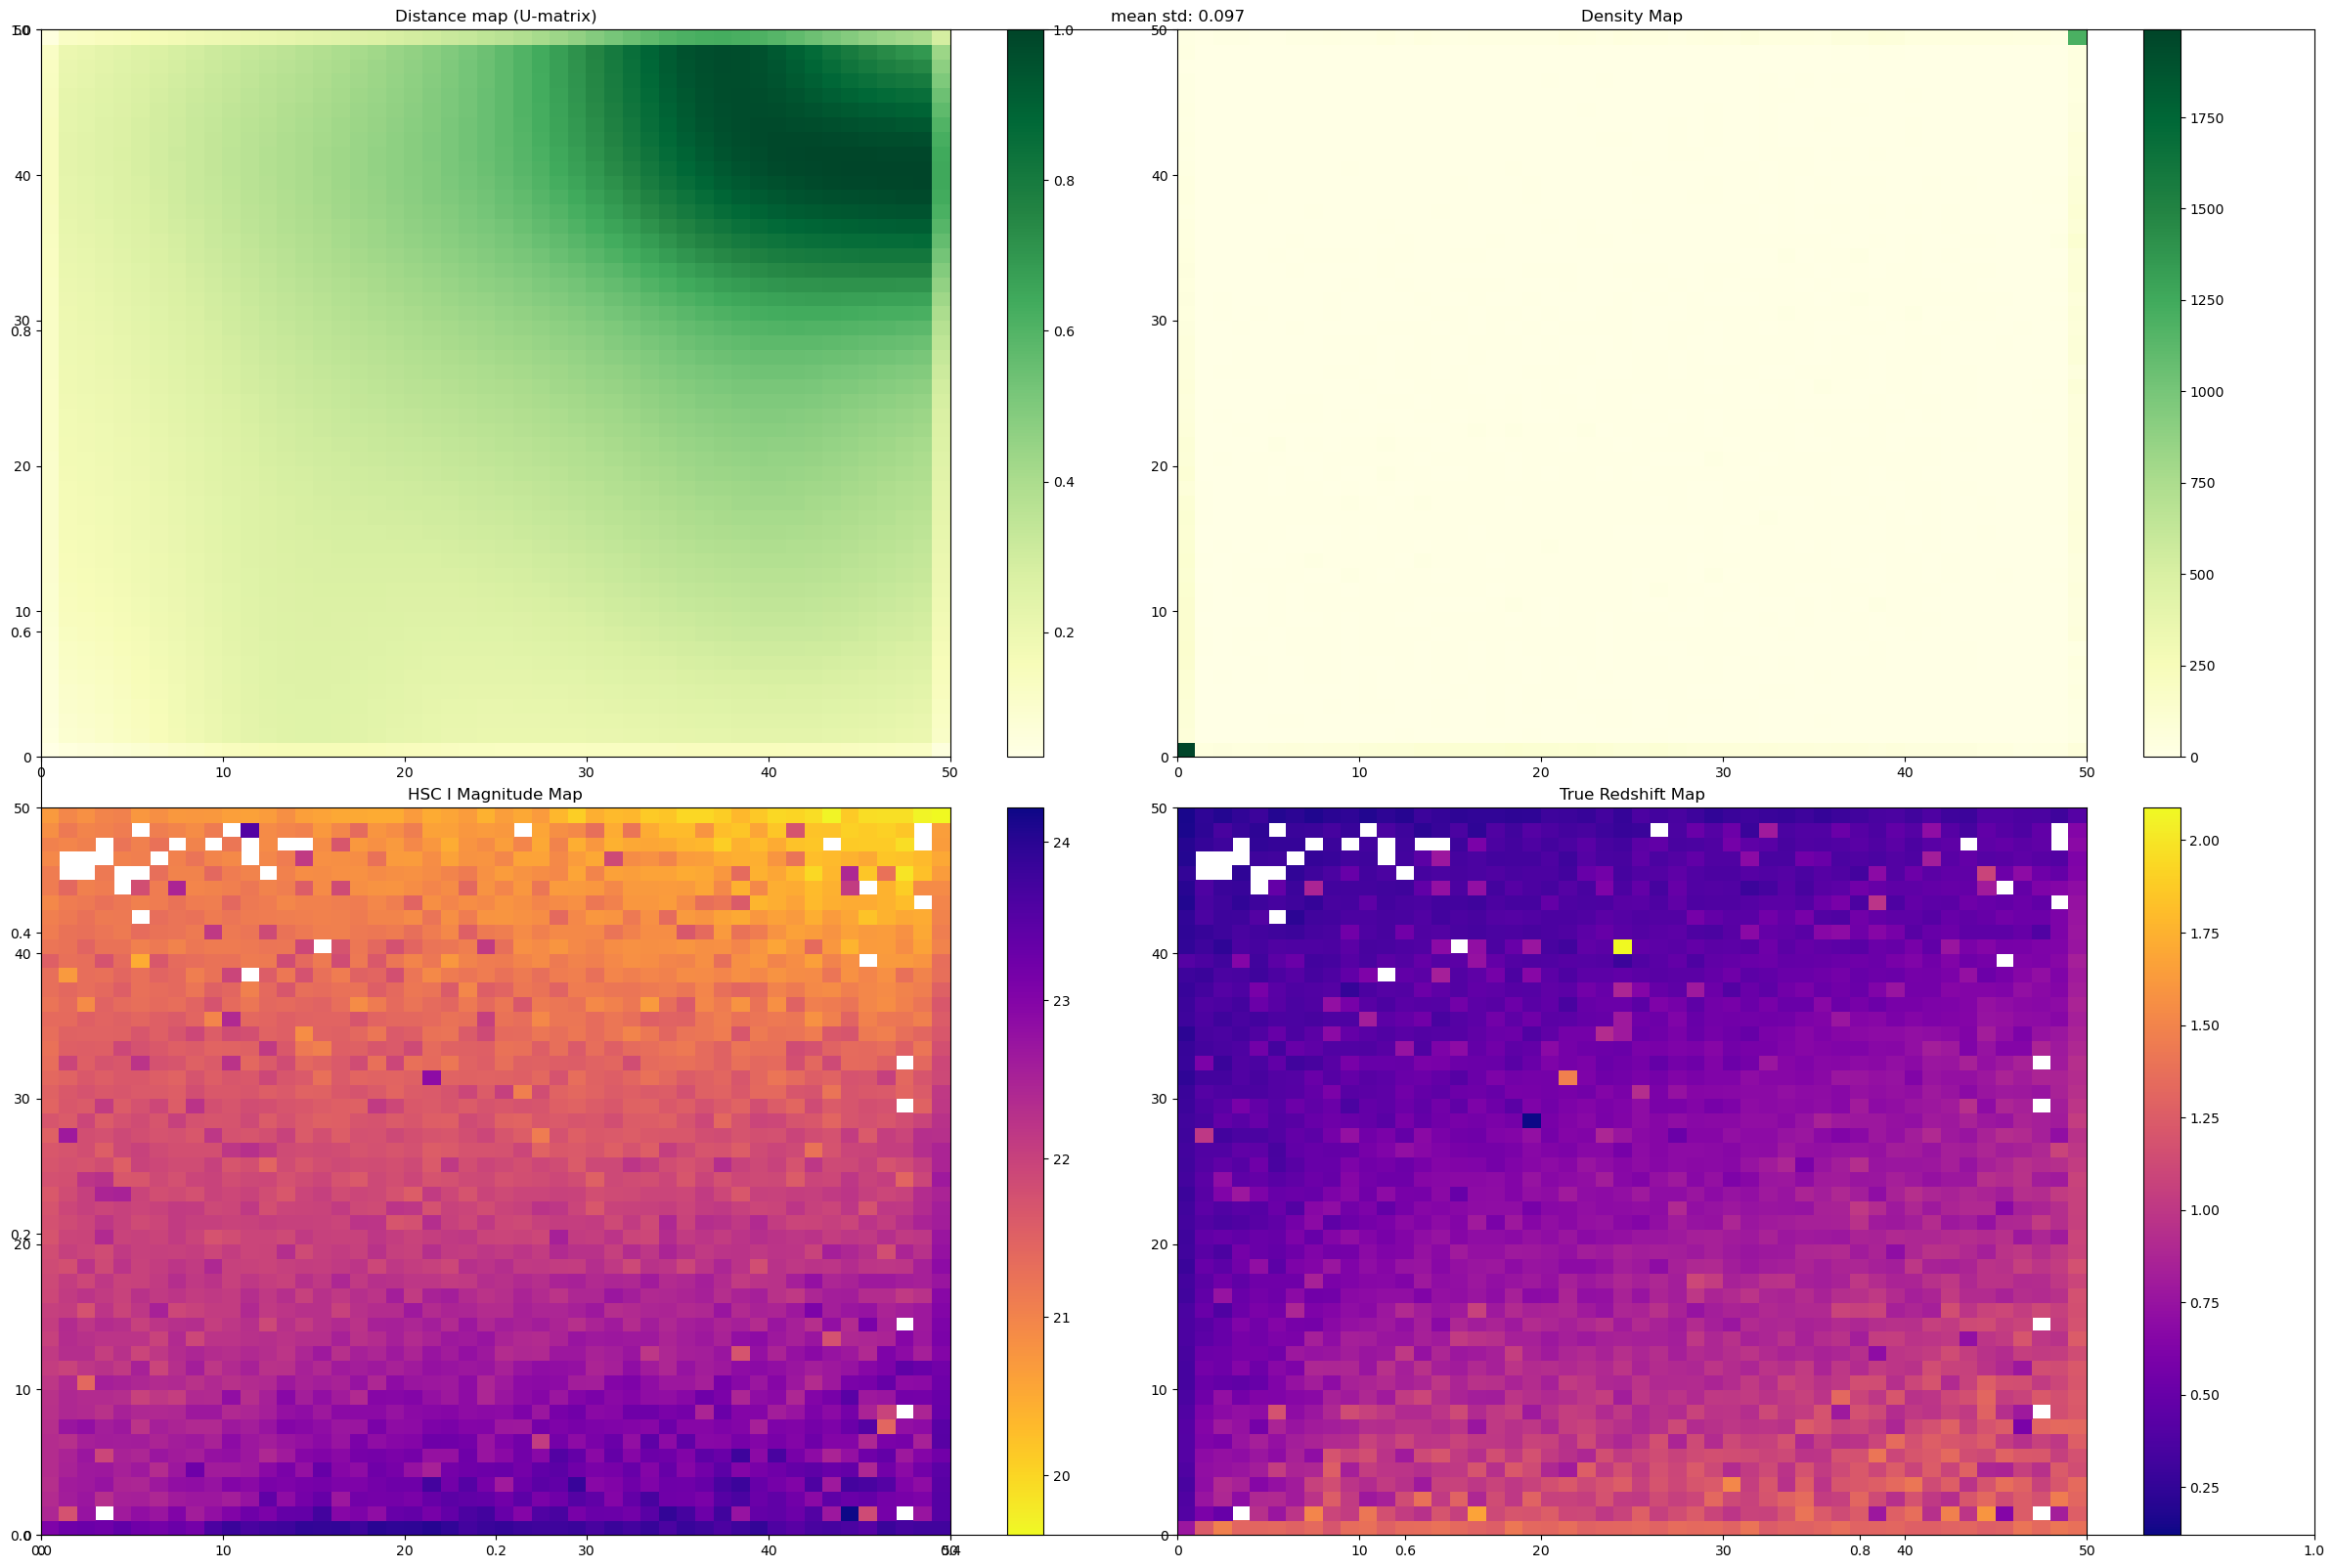

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[50, 20, 0.02]
29683.0
Topological error: 0.006367280935215443
Quantization error: 2.2877216226465693
Average redshift std: 0.09622920436107893


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


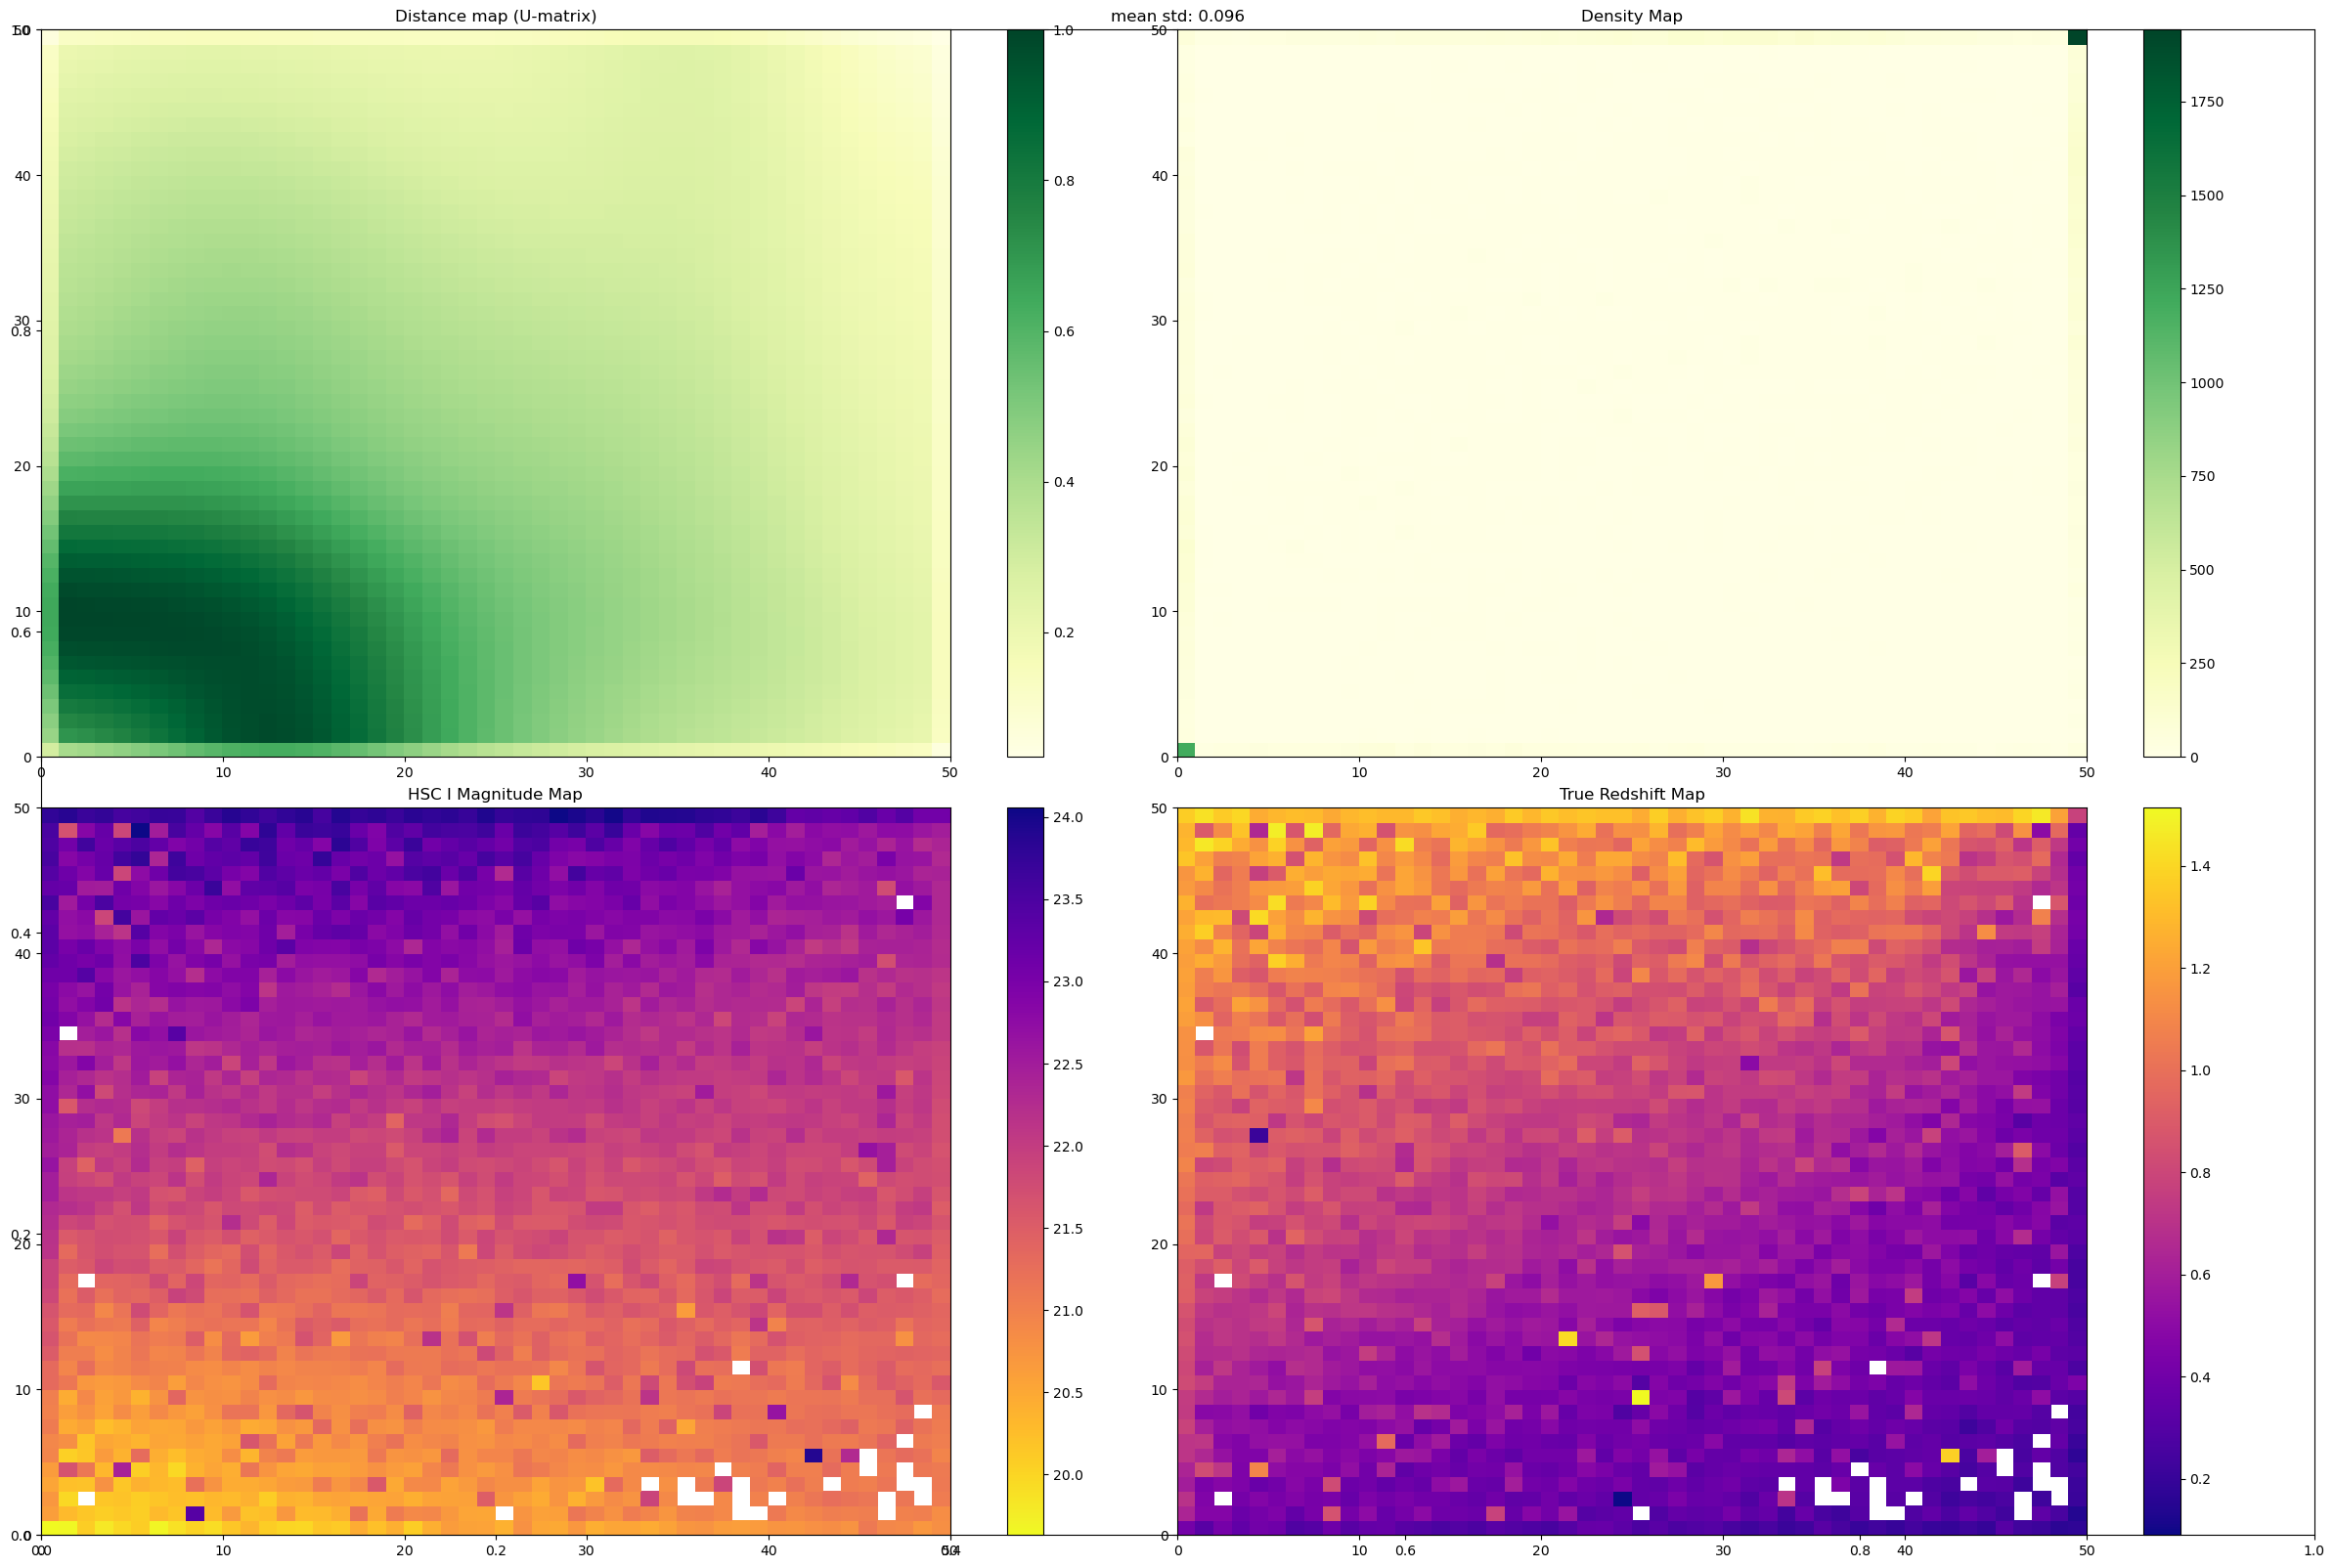

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[50, 20, 0.03]
29683.0
Topological error: 0.011083785331671326
Quantization error: 2.3591104846775566
Average redshift std: 0.09802836494880202


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


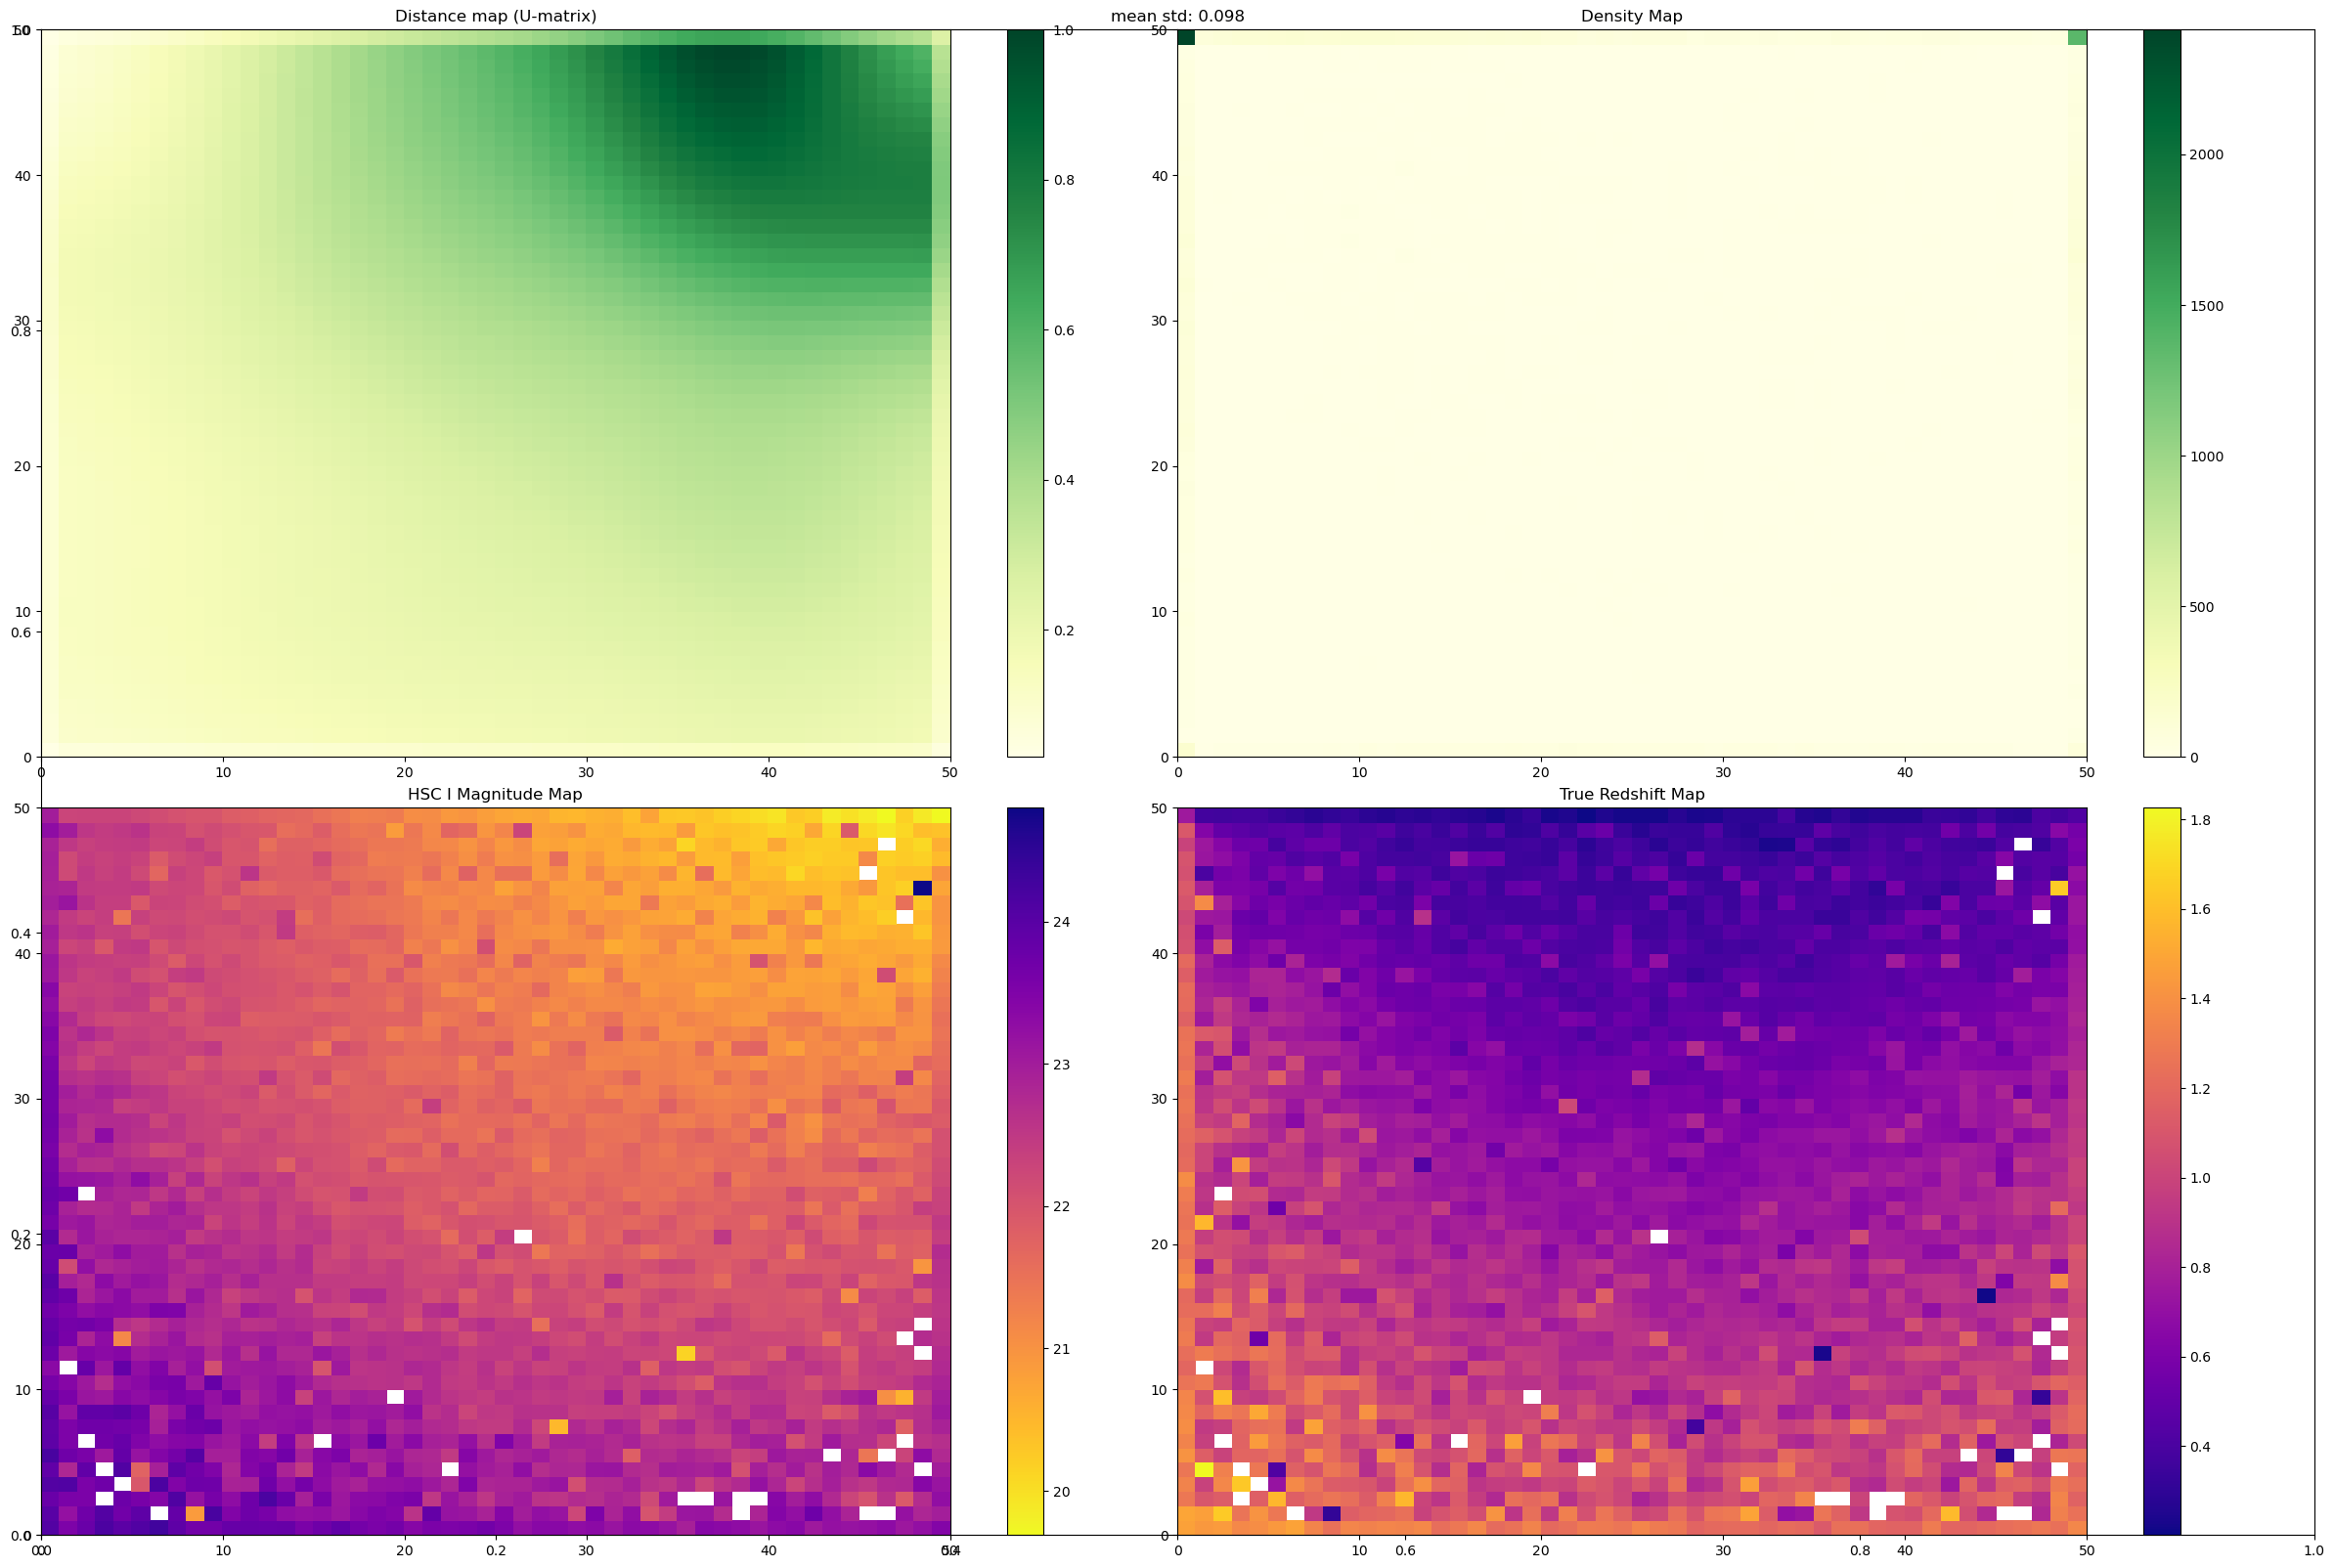

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[50, 20, 0.04]
29683.0
Topological error: 0.010376309672202945
Quantization error: 2.3615441688872374
Average redshift std: 0.09796572705083388


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


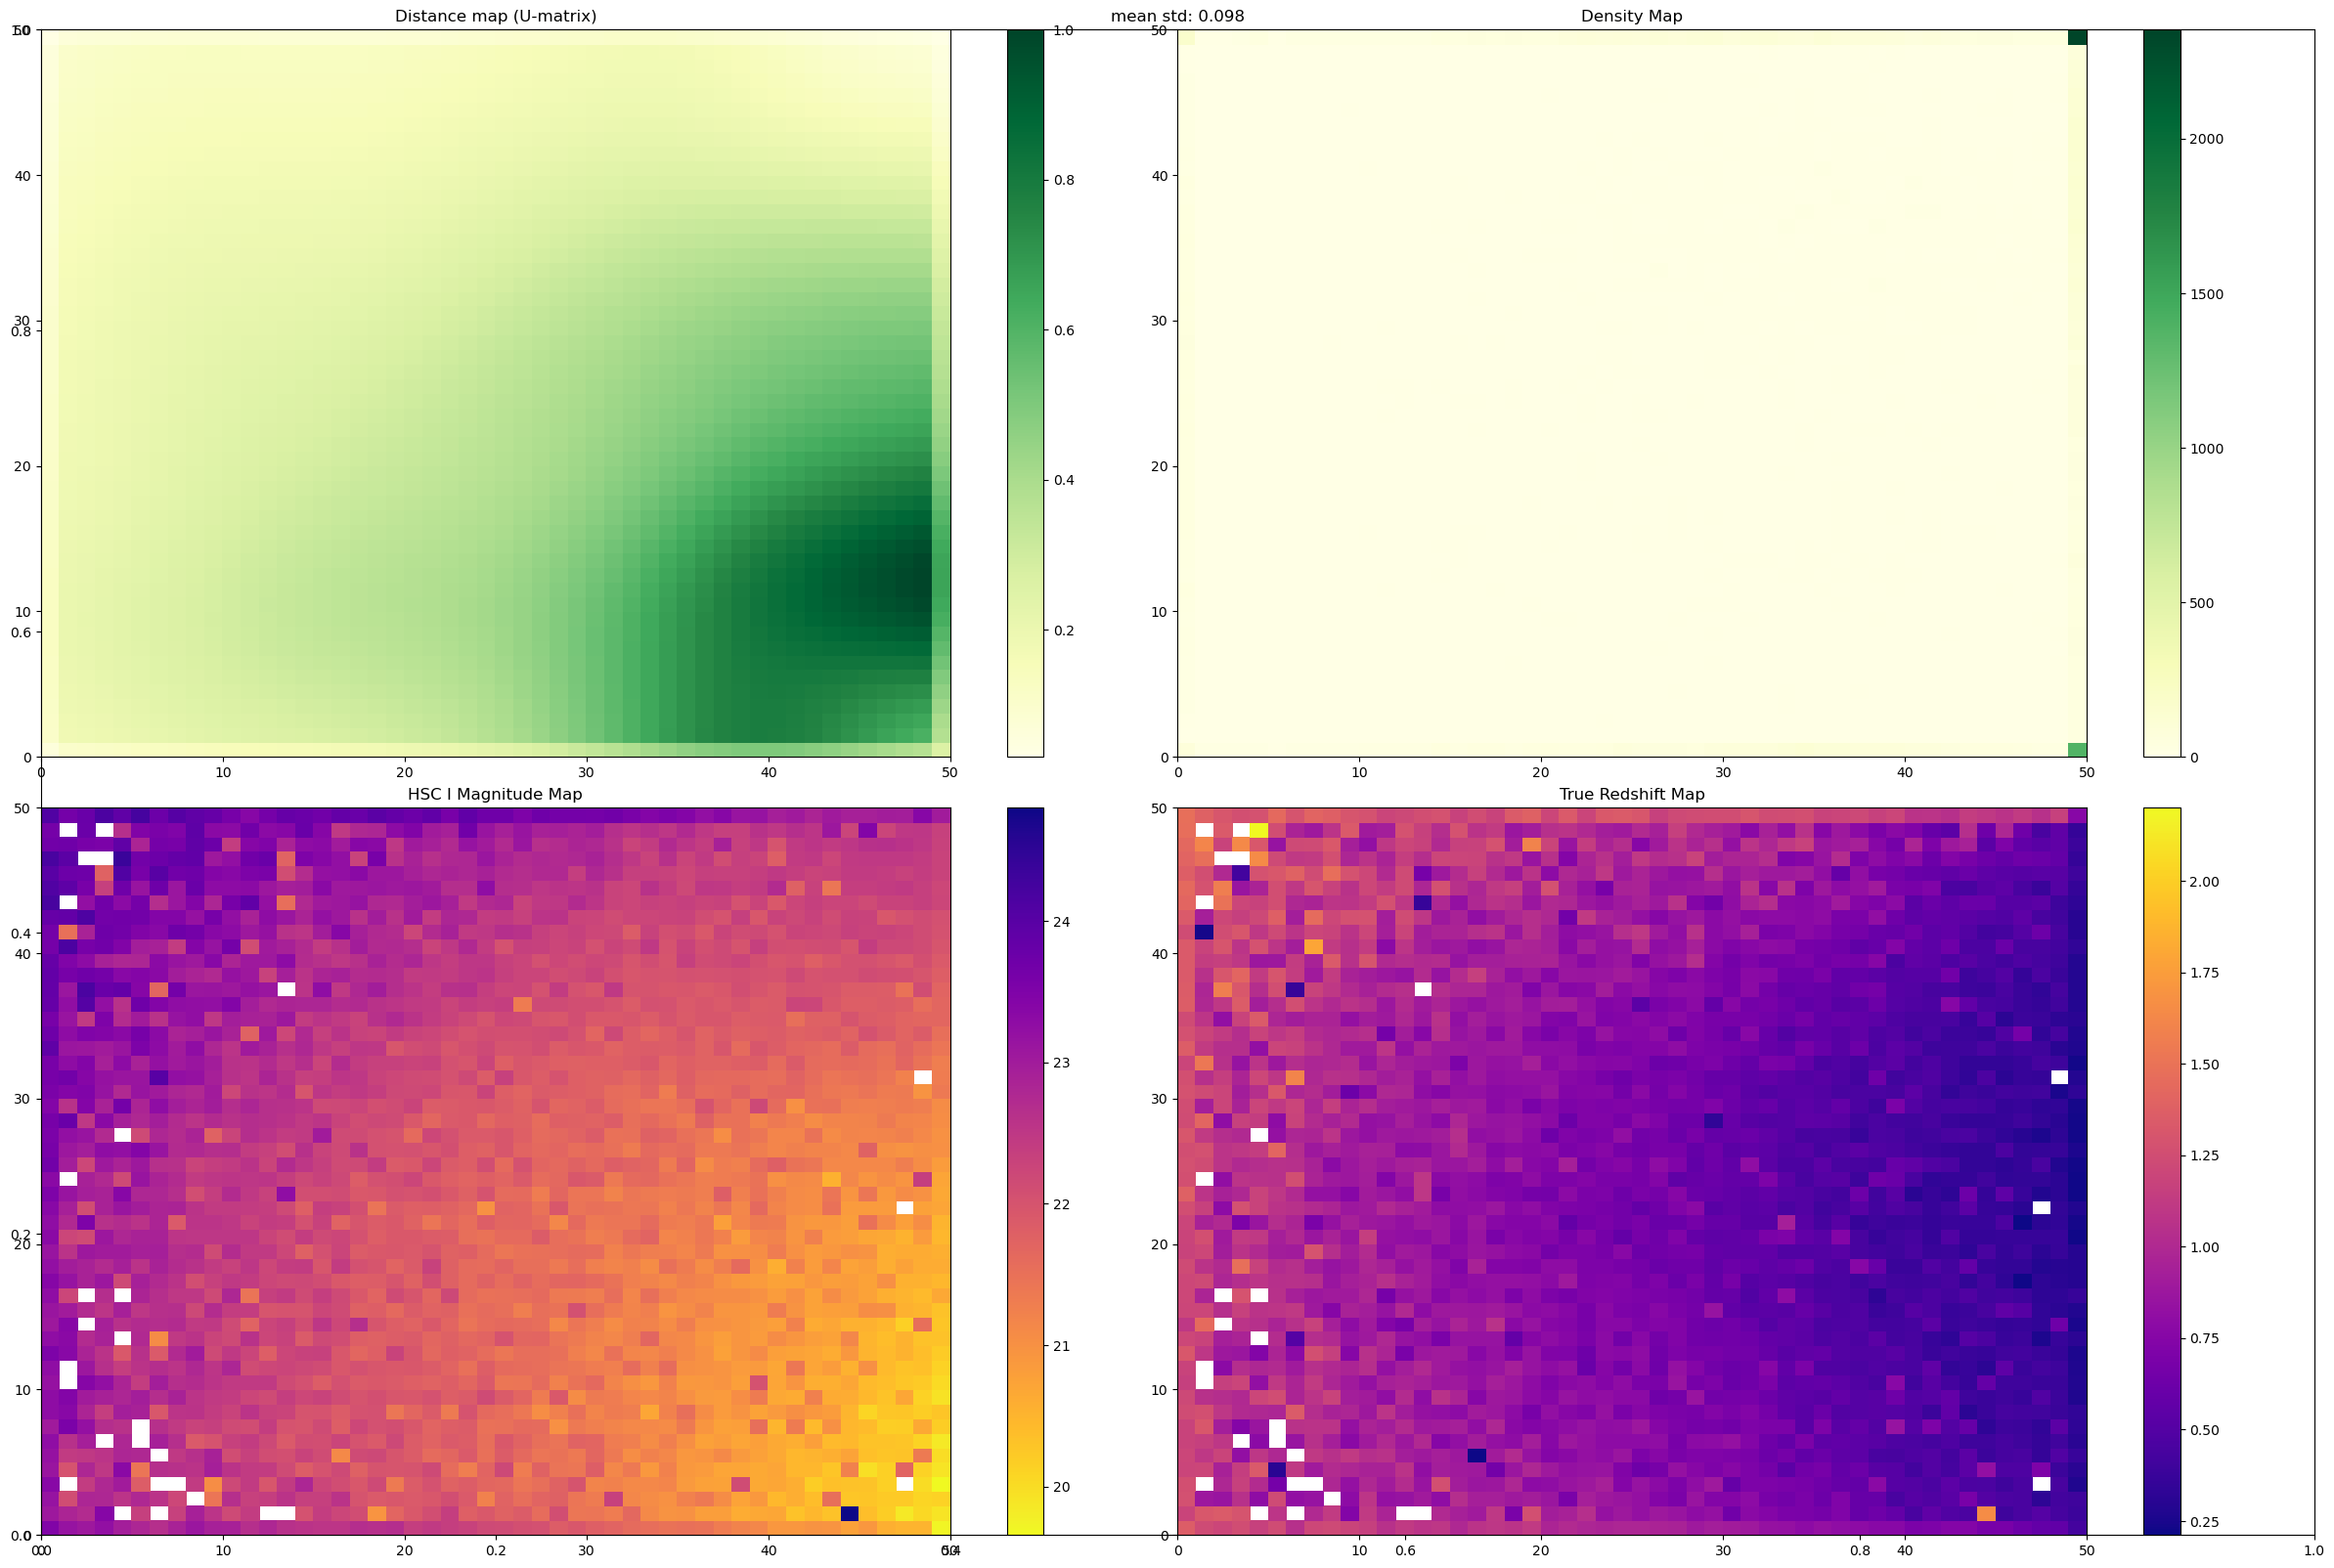

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[50, 20, 0.05]
29683.0
Topological error: 0.005693494592864602
Quantization error: 2.304060607389319
Average redshift std: 0.09685522849984235


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


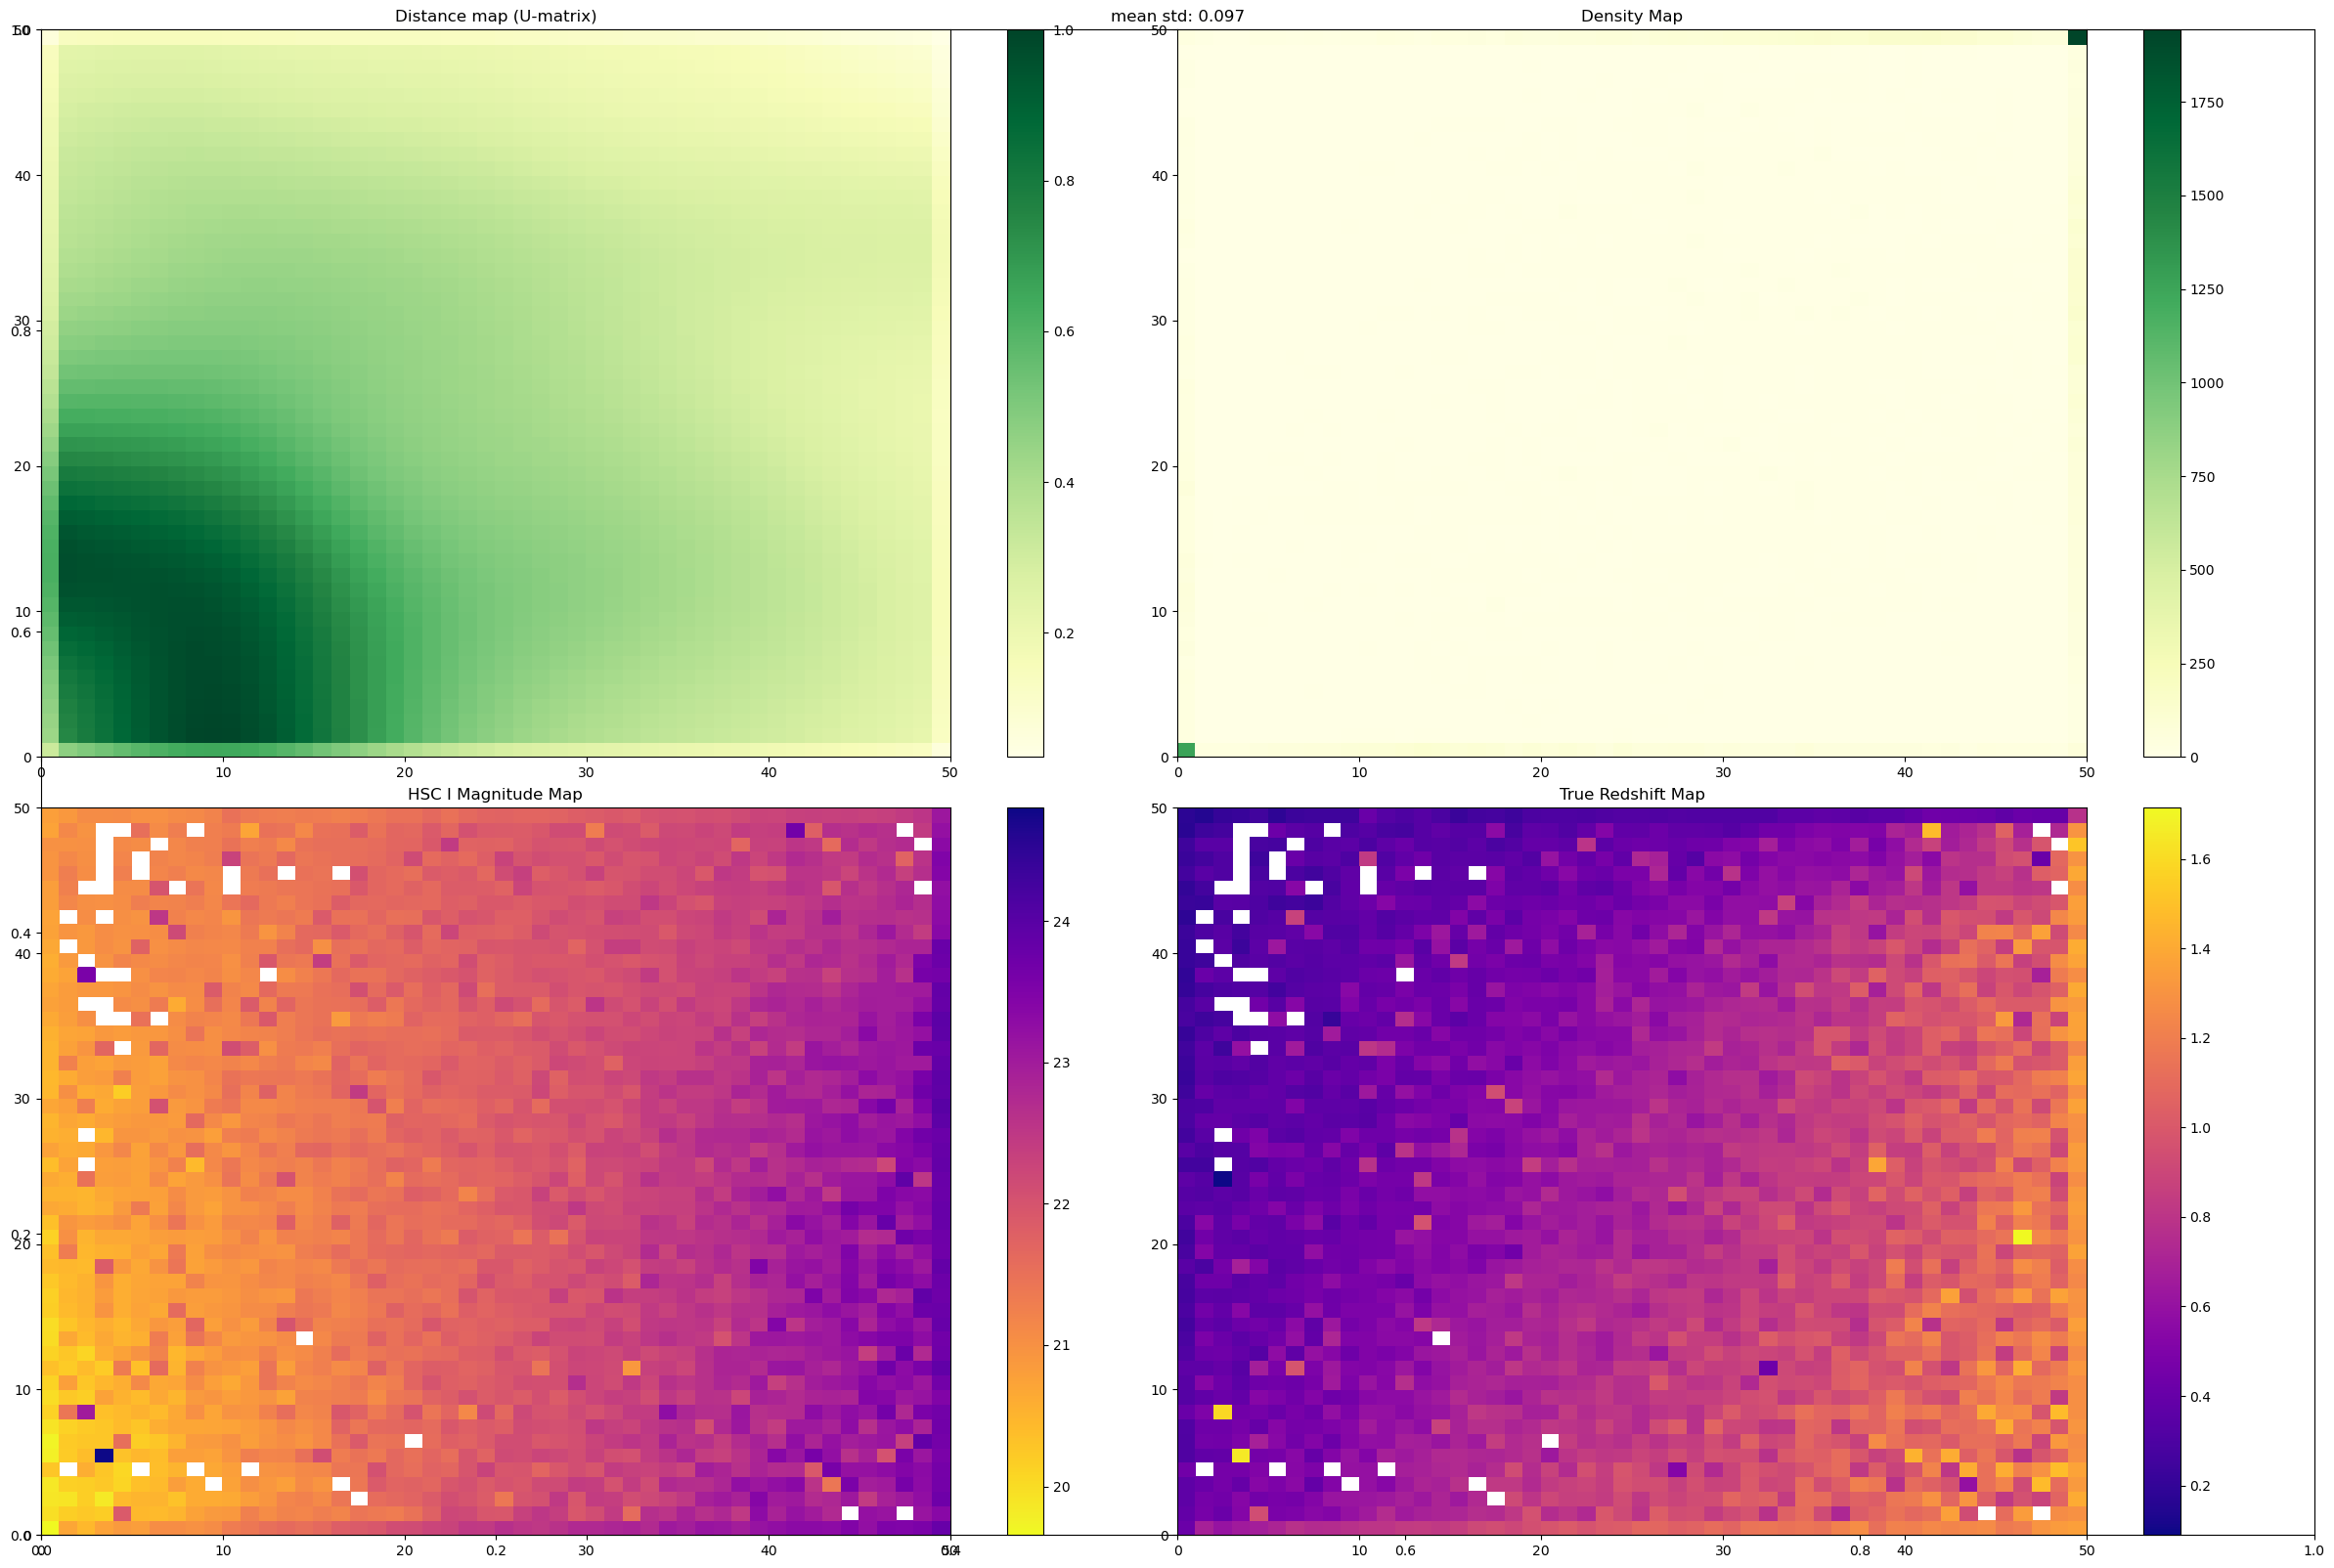

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[50, 20, 0.06]
29683.0
Topological error: 0.0059630091298049385
Quantization error: 2.3094936775361683
Average redshift std: 0.09753486490248685


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


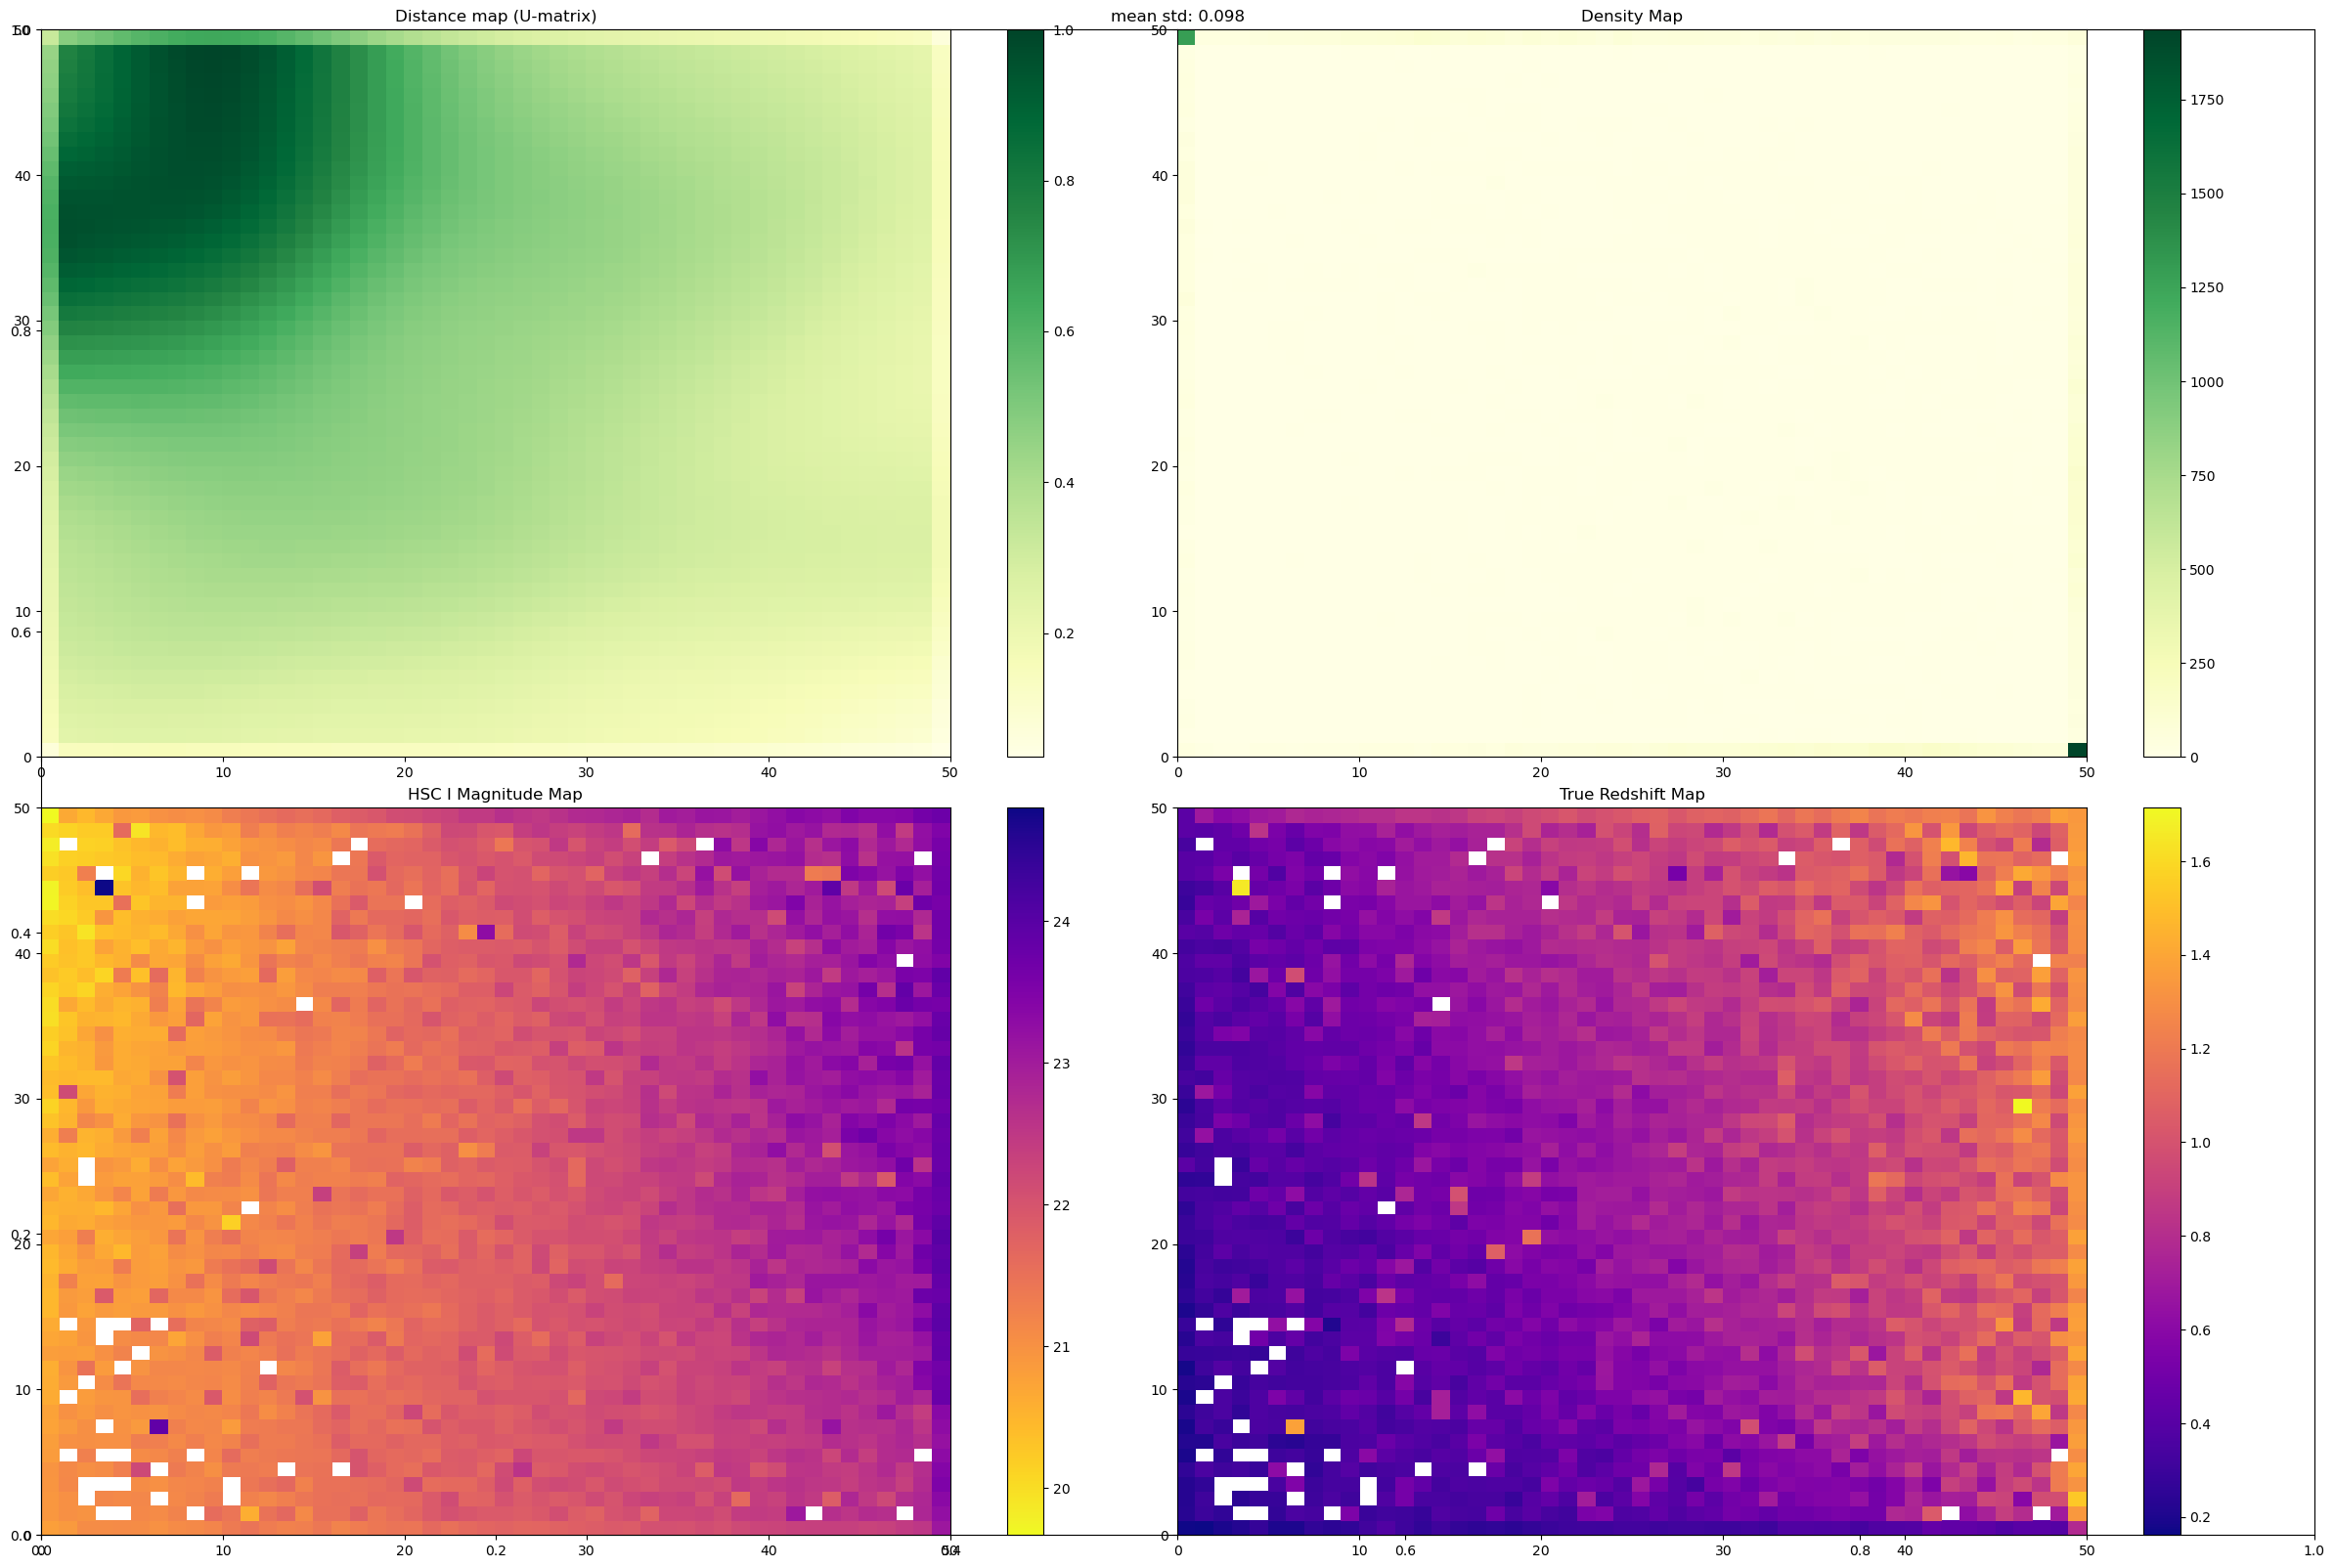

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[50, 20, 0.07]
29683.0
Topological error: 0.005727183909982145
Quantization error: 2.3165769121416595
Average redshift std: 0.09760324317958183


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


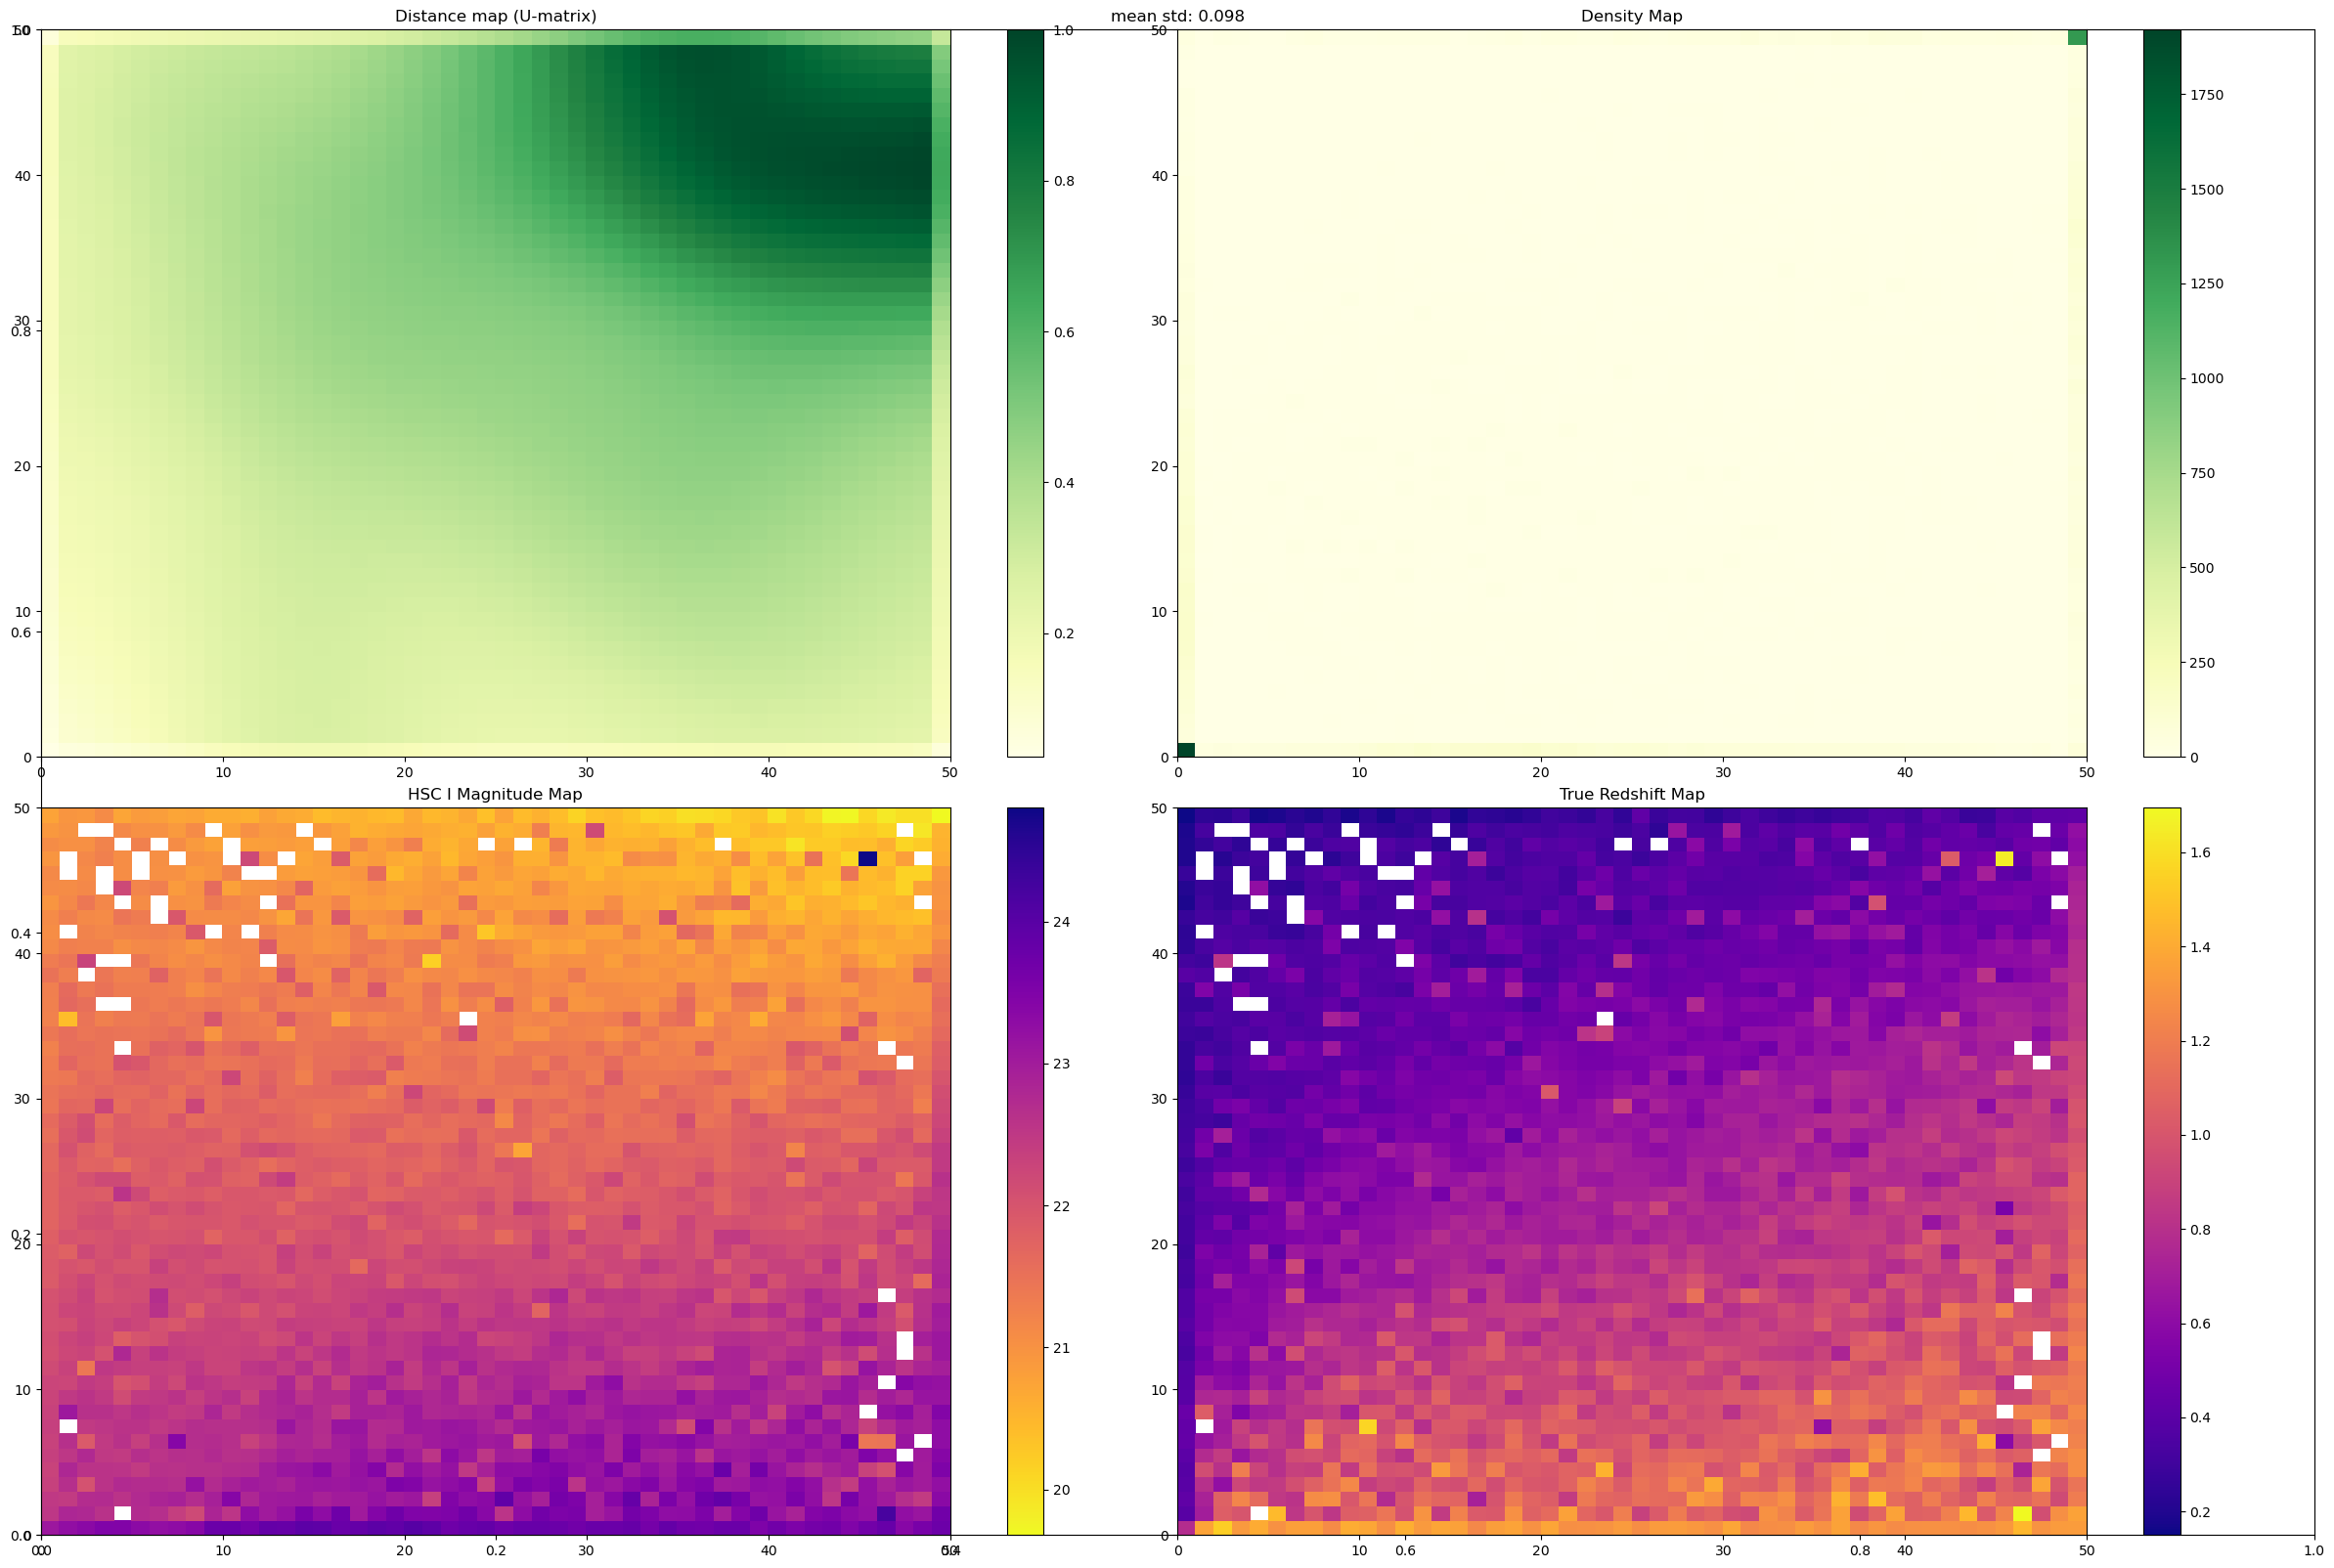

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[50, 20, 0.08]
29683.0
Topological error: 0.005053397567631304
Quantization error: 2.322654053536308
Average redshift std: 0.09701223326058189


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


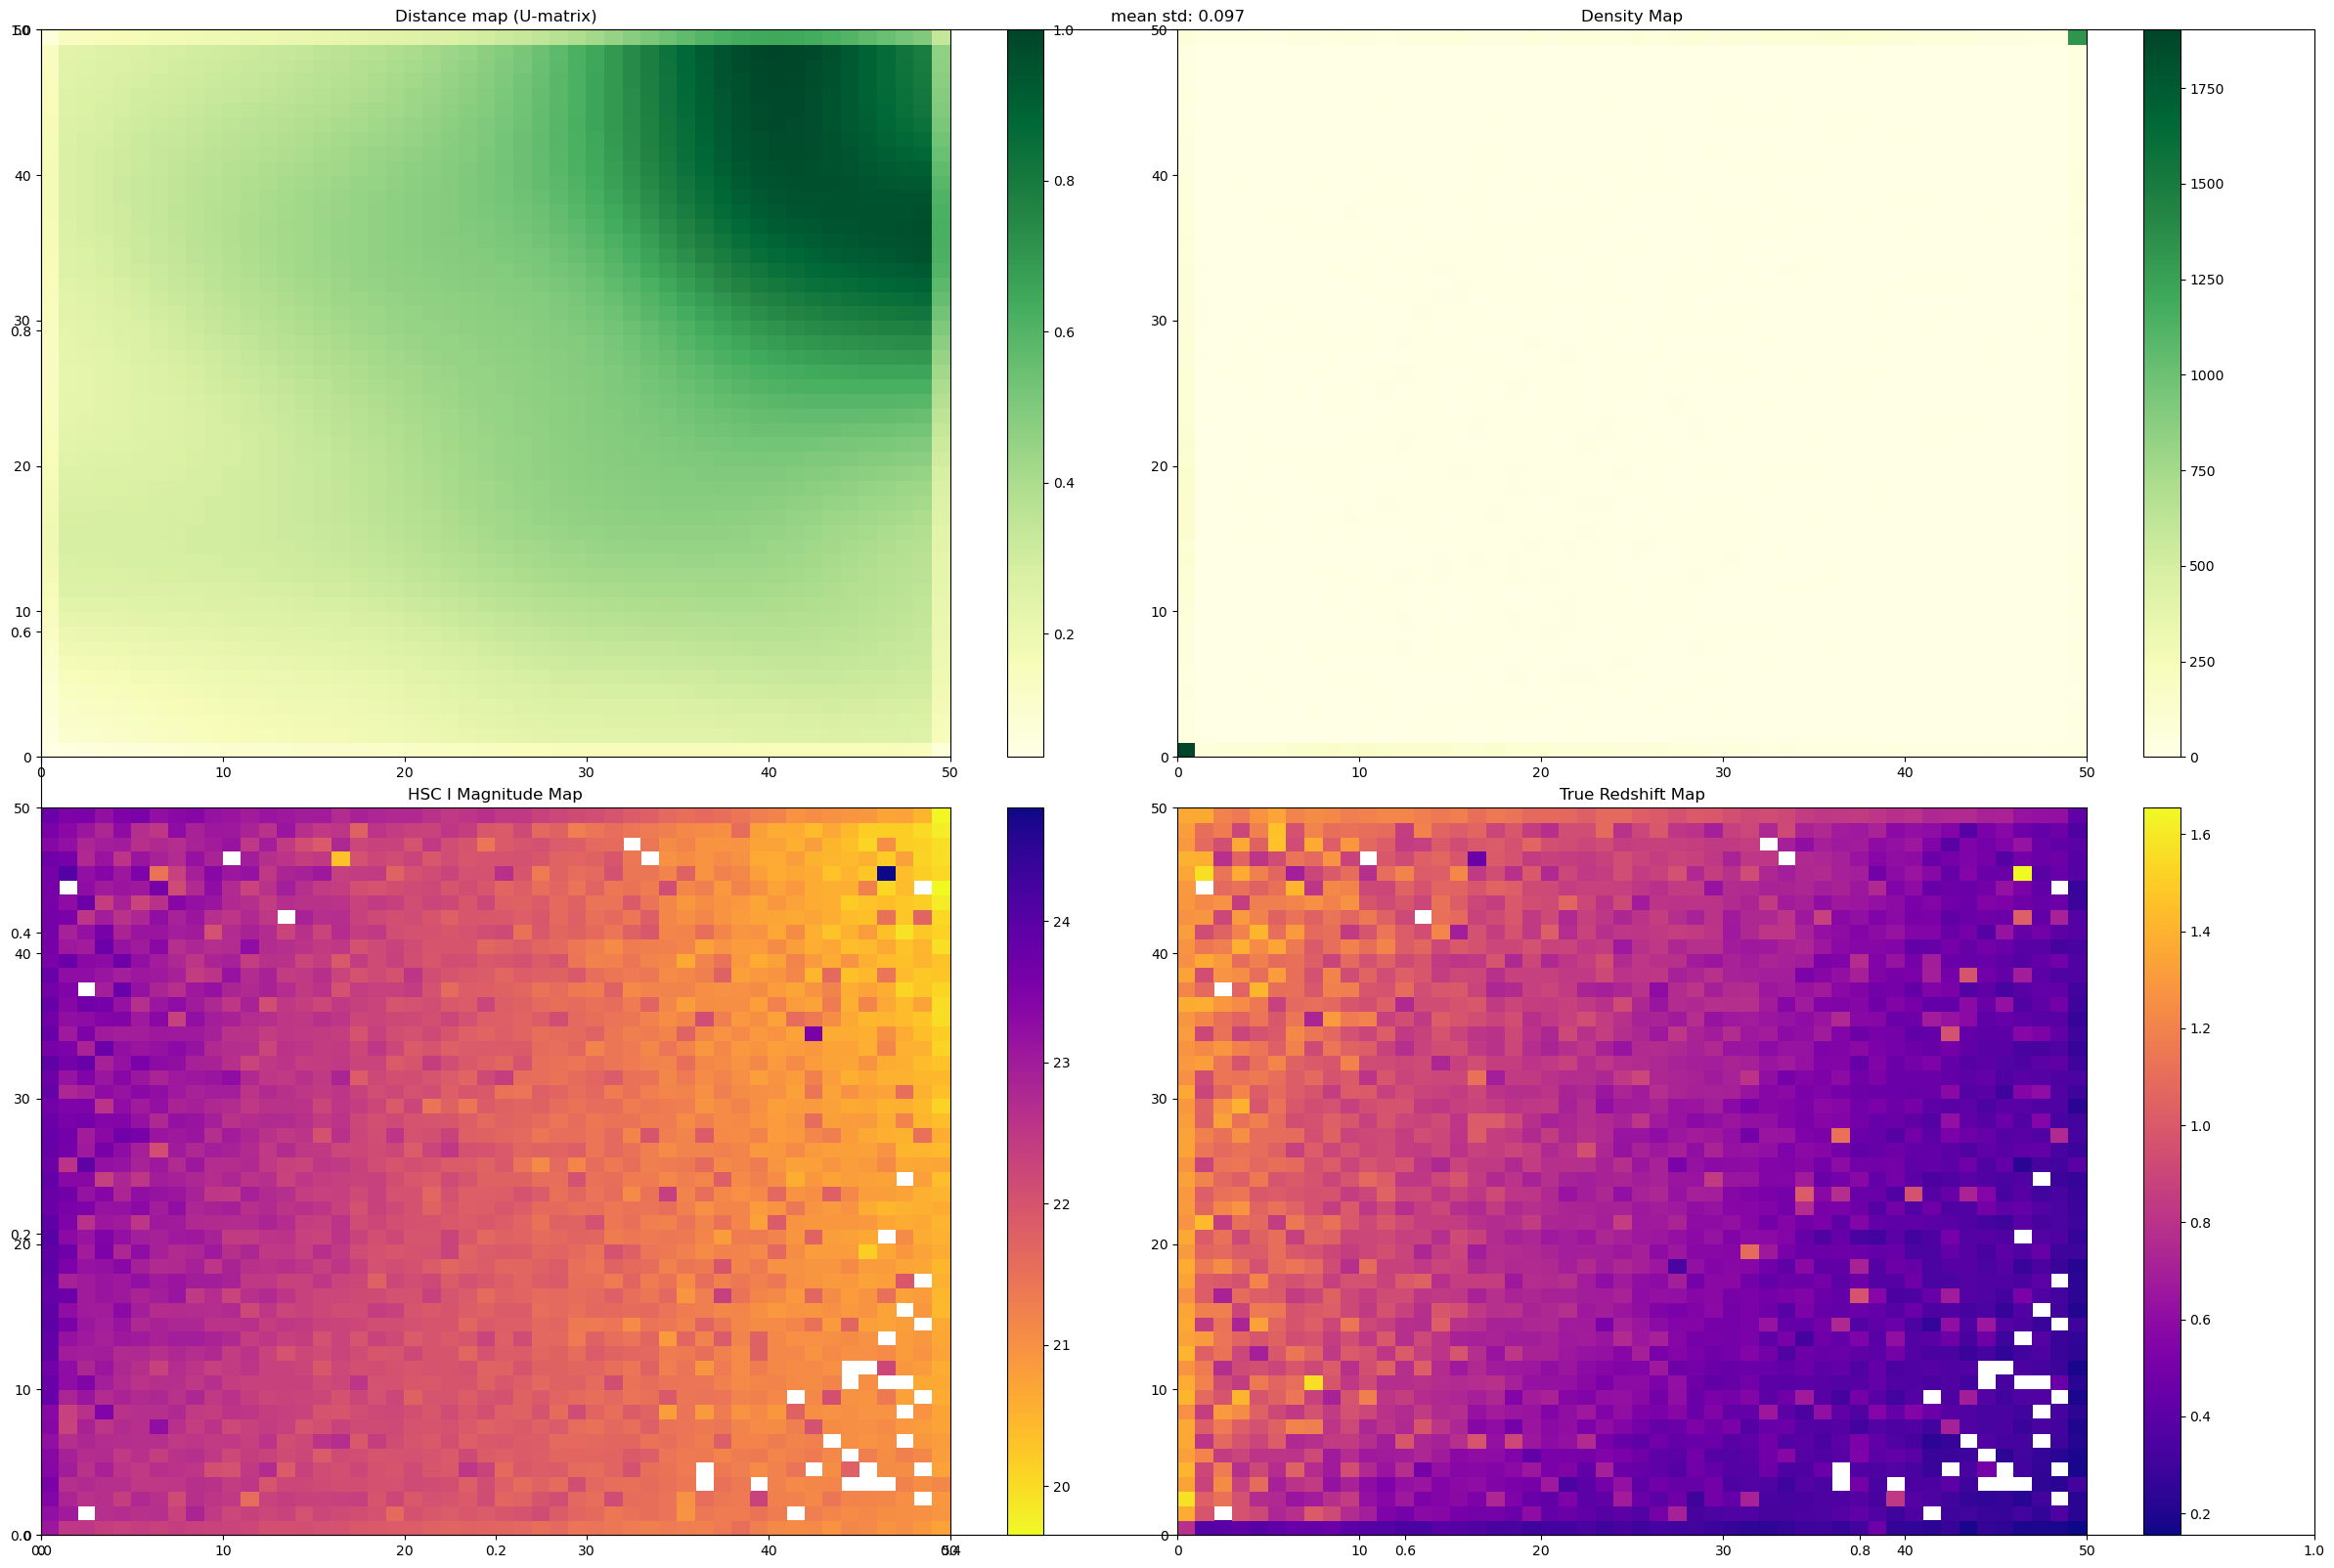

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[50, 20, 0.09]
29683.0
Topological error: 0.005659805275747061
Quantization error: 2.329118795667121
Average redshift std: 0.09744541315359935


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


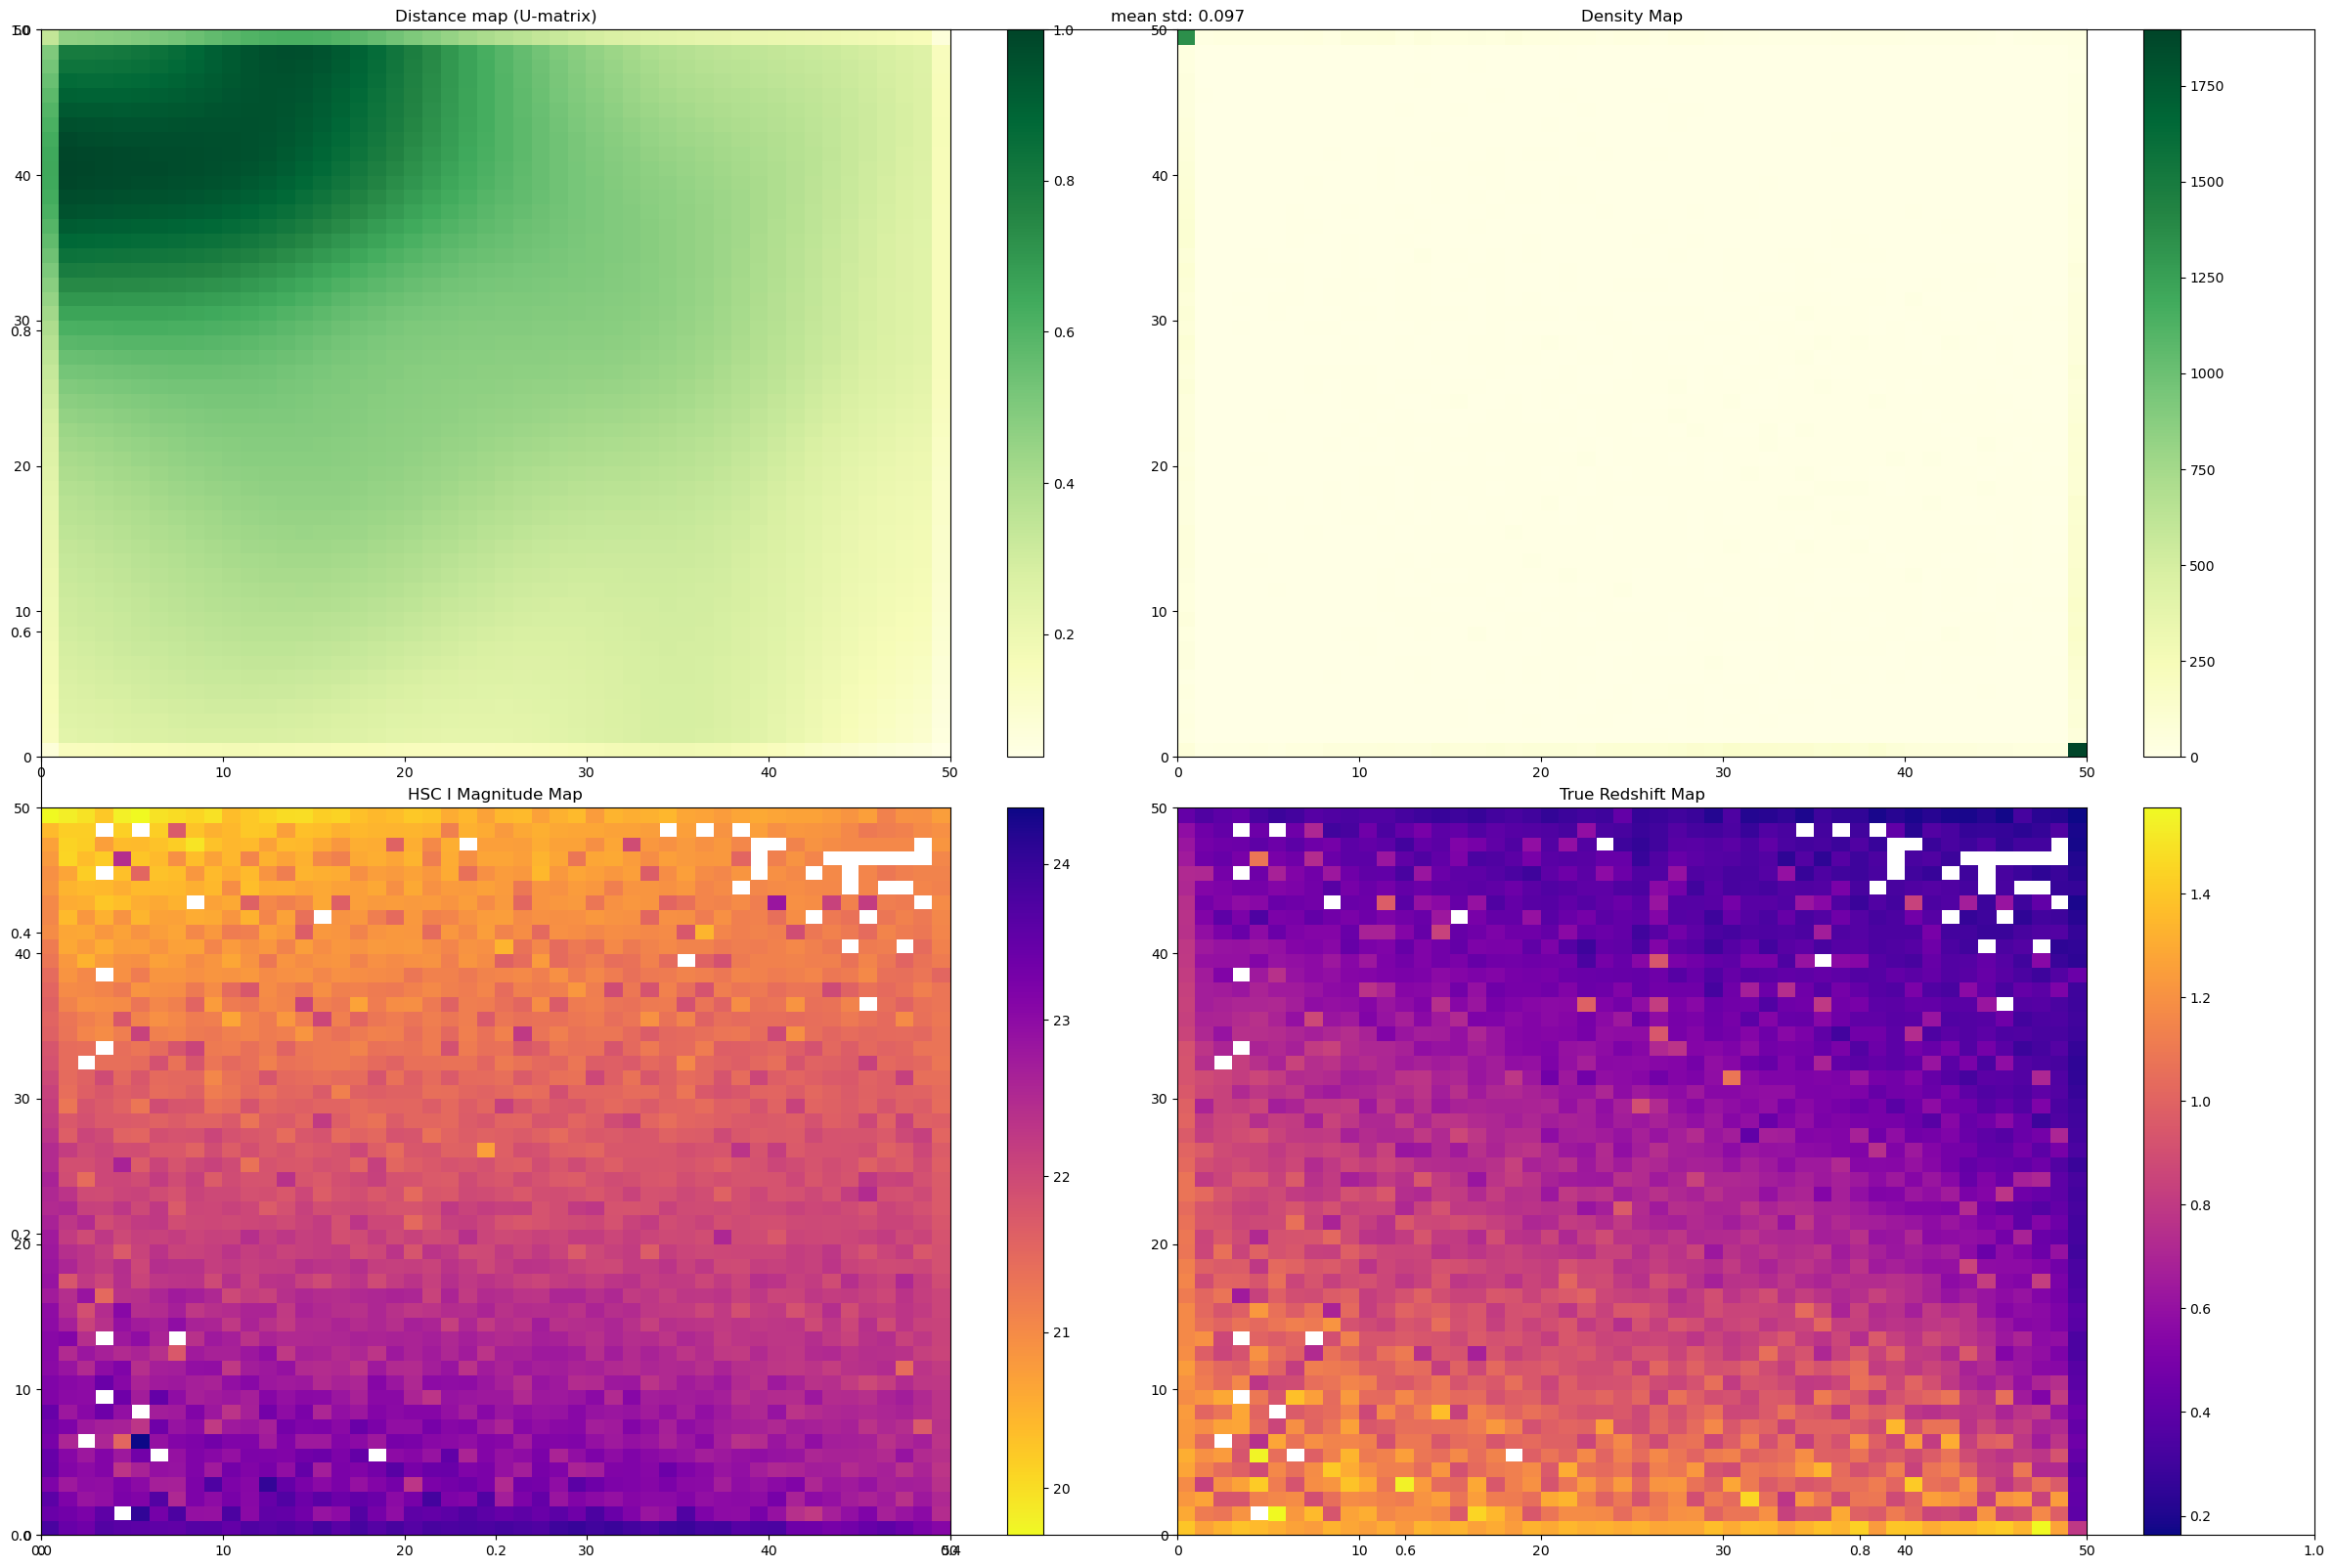

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[50, 20, 0.1]
29683.0
Topological error: 0.0054576693730418084
Quantization error: 2.3356463090608814
Average redshift std: 0.09776007207226241


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


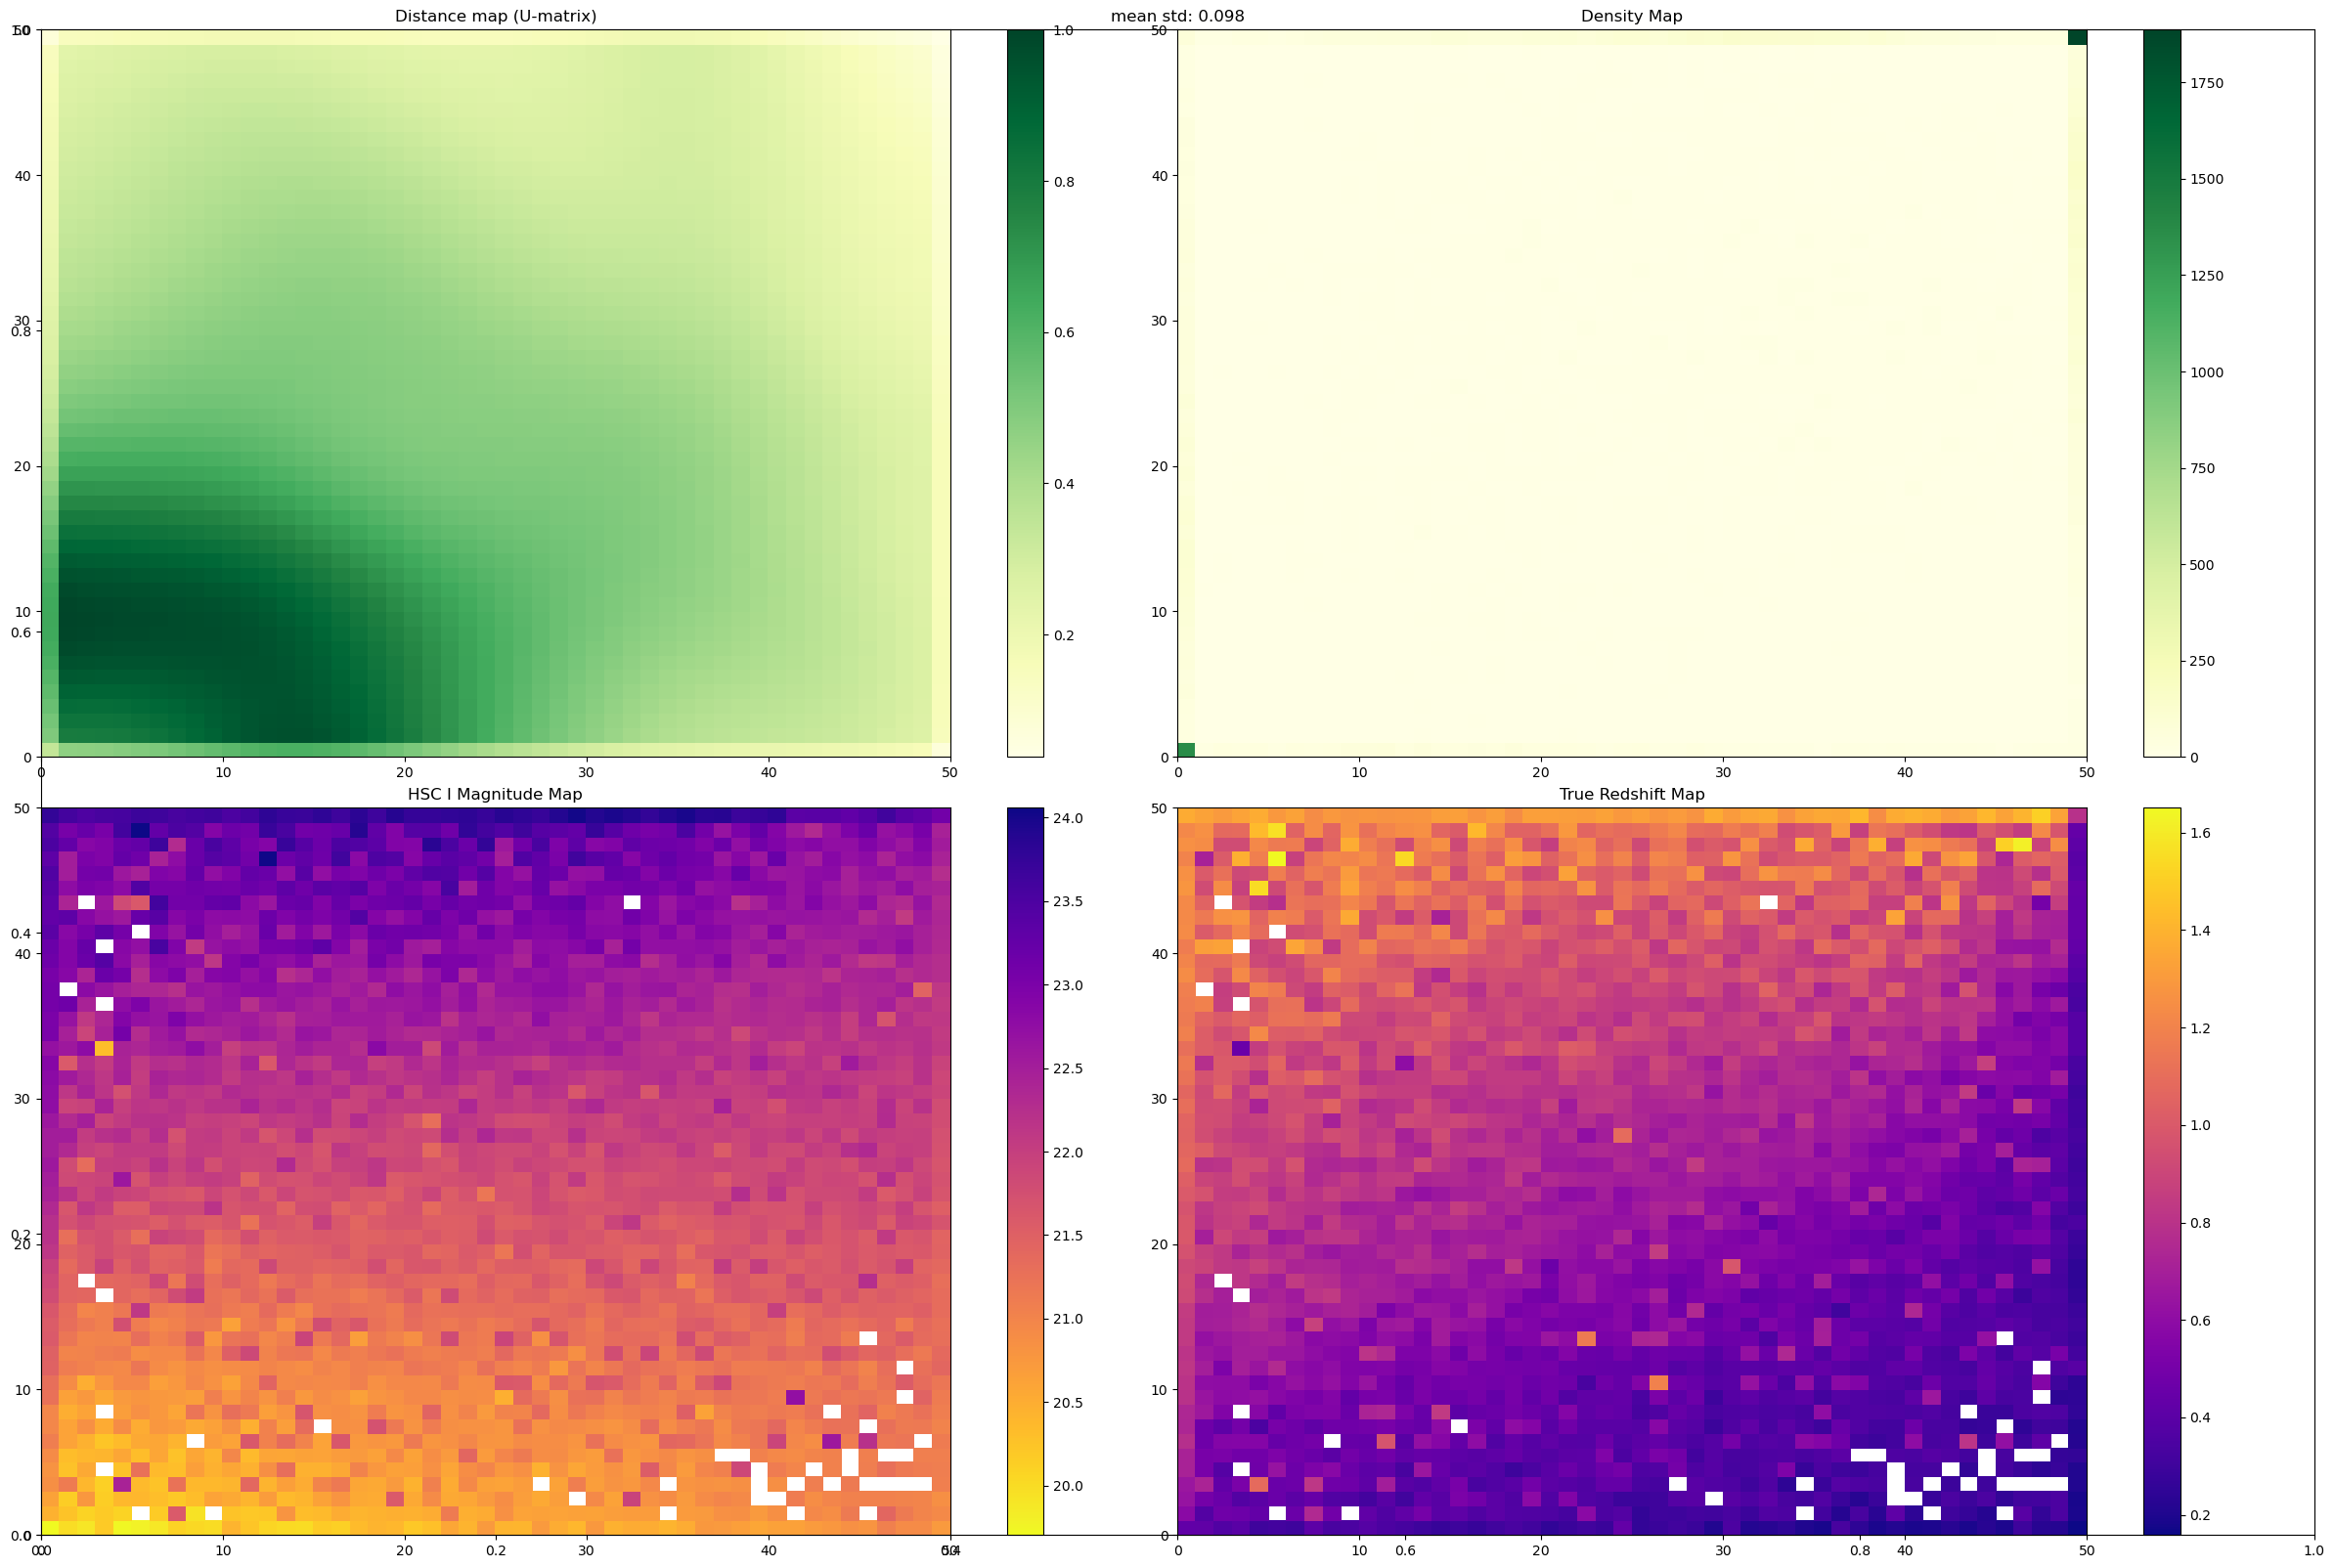

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[50, 20, 0.2]
29683.0
Topological error: 0.007276892497389078
Quantization error: 2.3919869438470314
Average redshift std: 0.09763854492122197


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


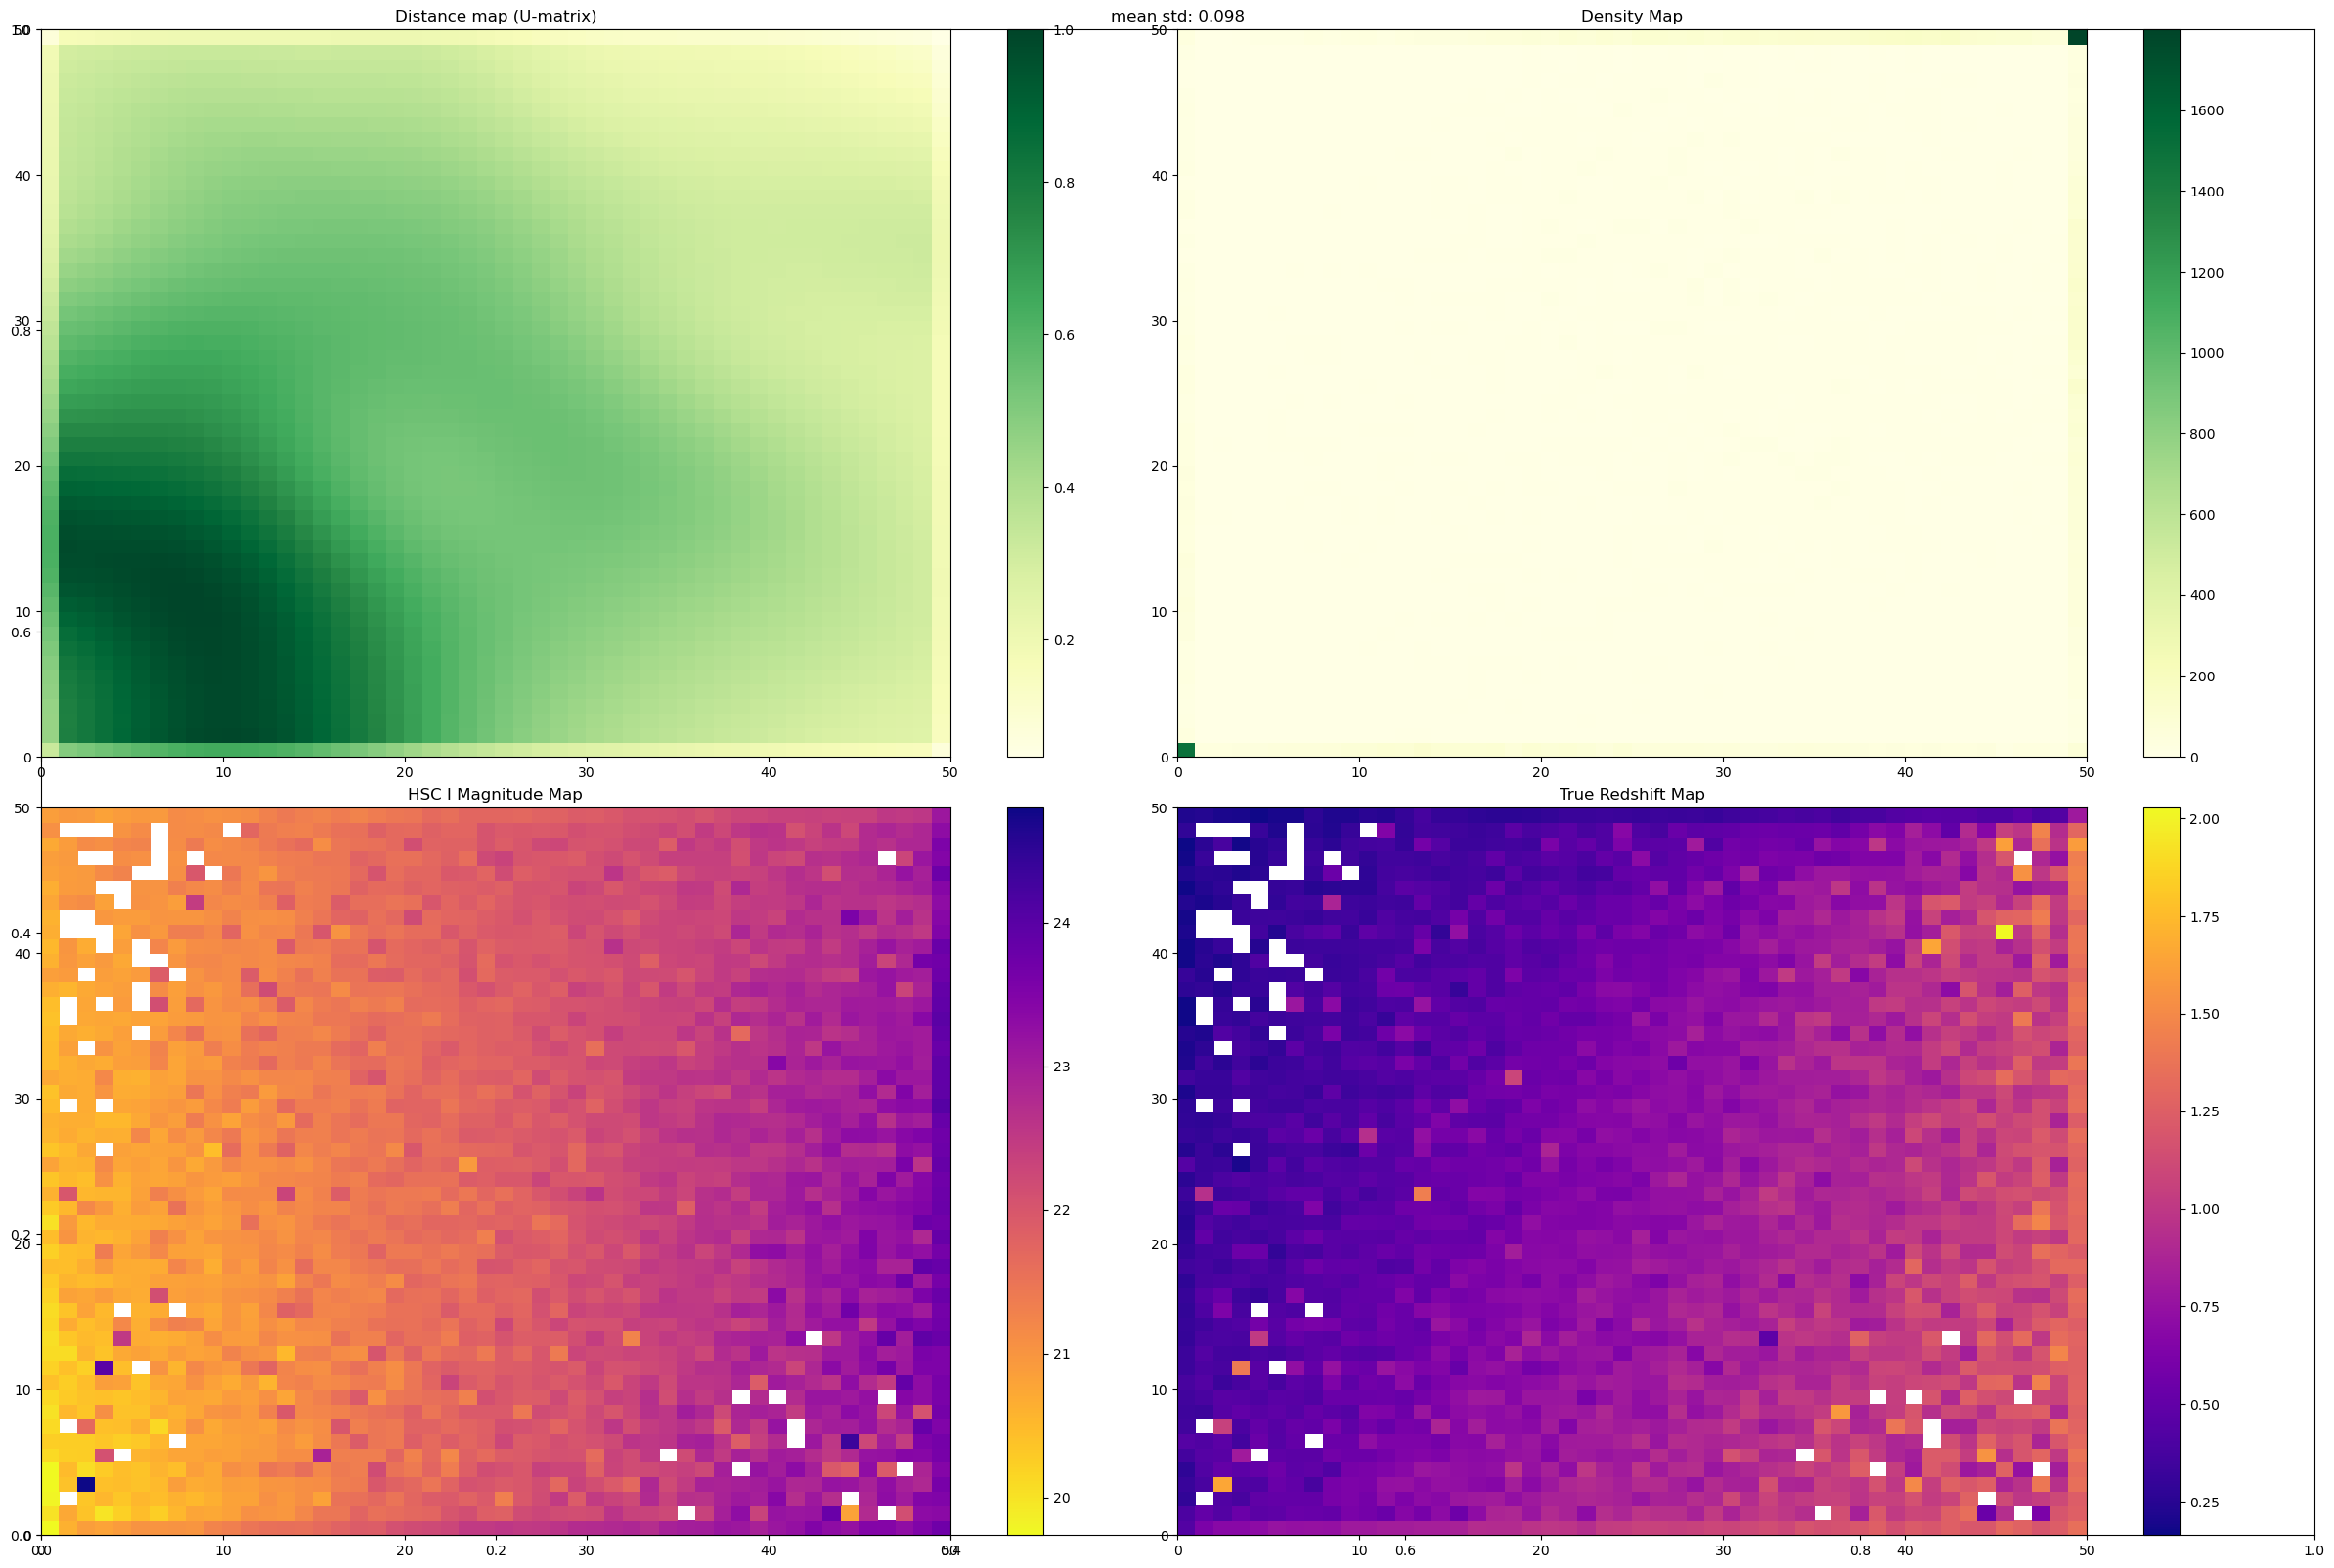

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[50, 20, 0.3]
29683.0
Topological error: 0.0092982515244416
Quantization error: 2.4350160986740974
Average redshift std: 0.09747123218874752


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


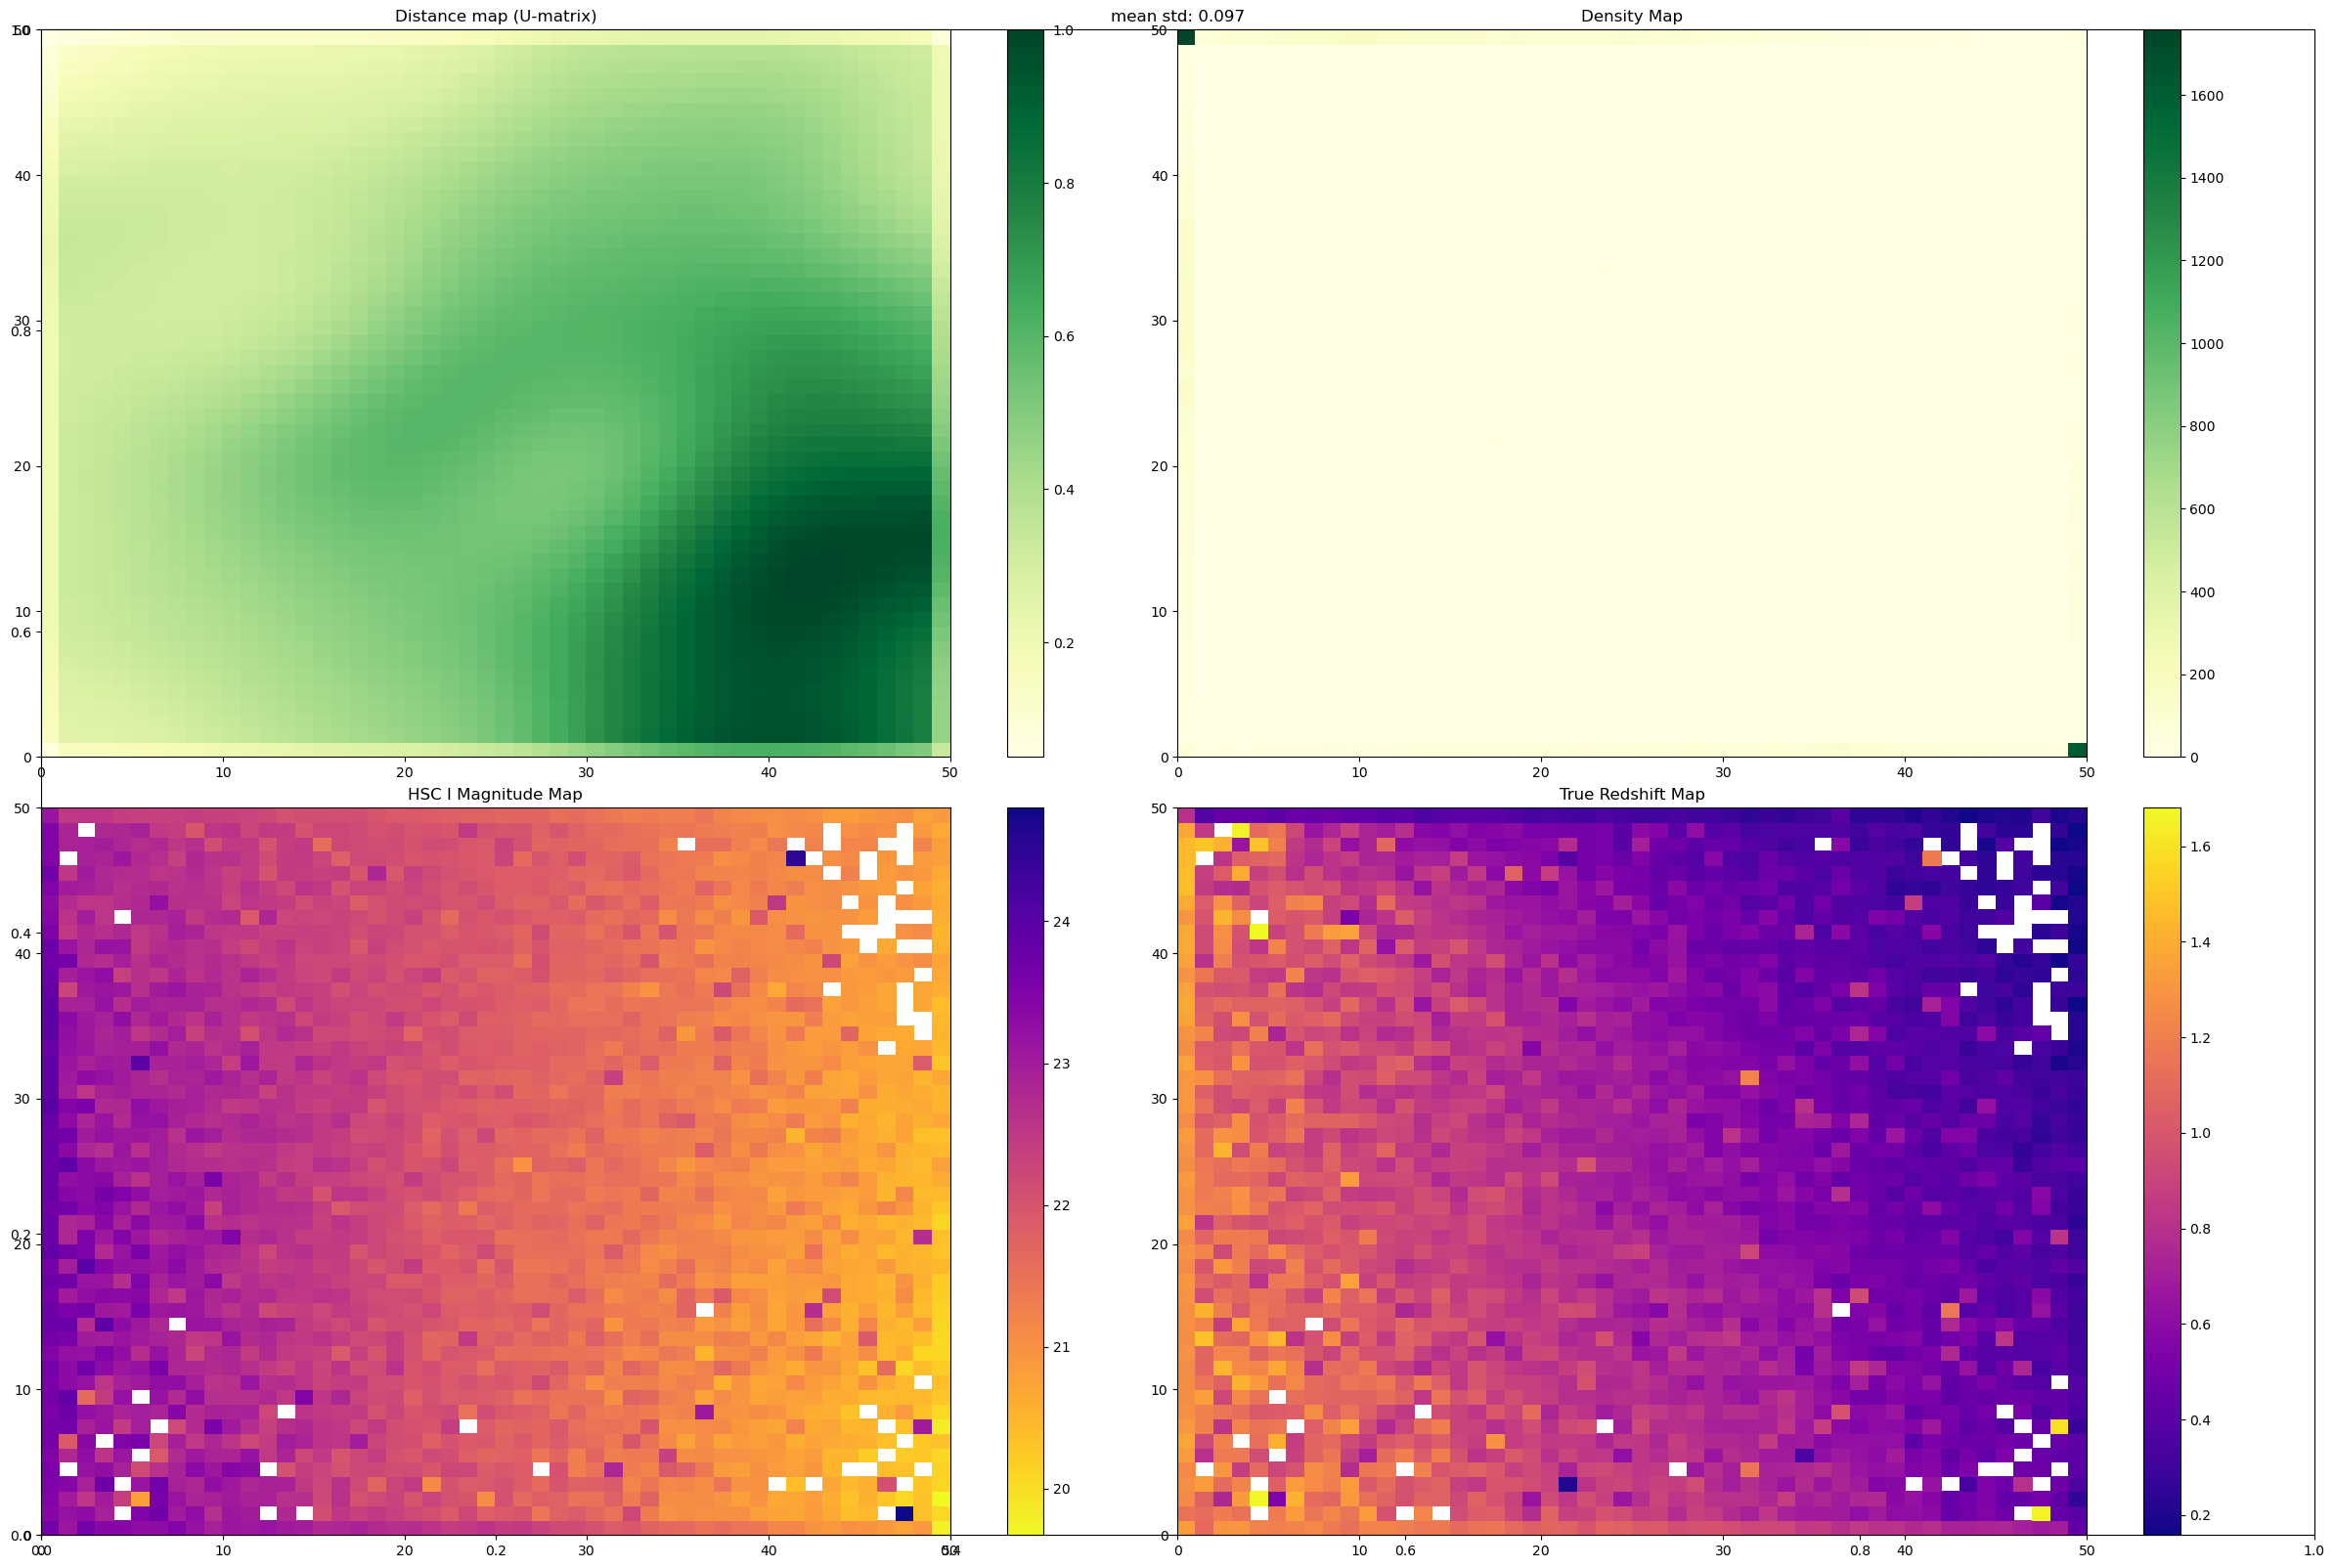

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[50, 20, 0.4]
29683.0
Topological error: 0.01115116396590641
Quantization error: 2.4747836096405957
Average redshift std: 0.09679392211466233


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


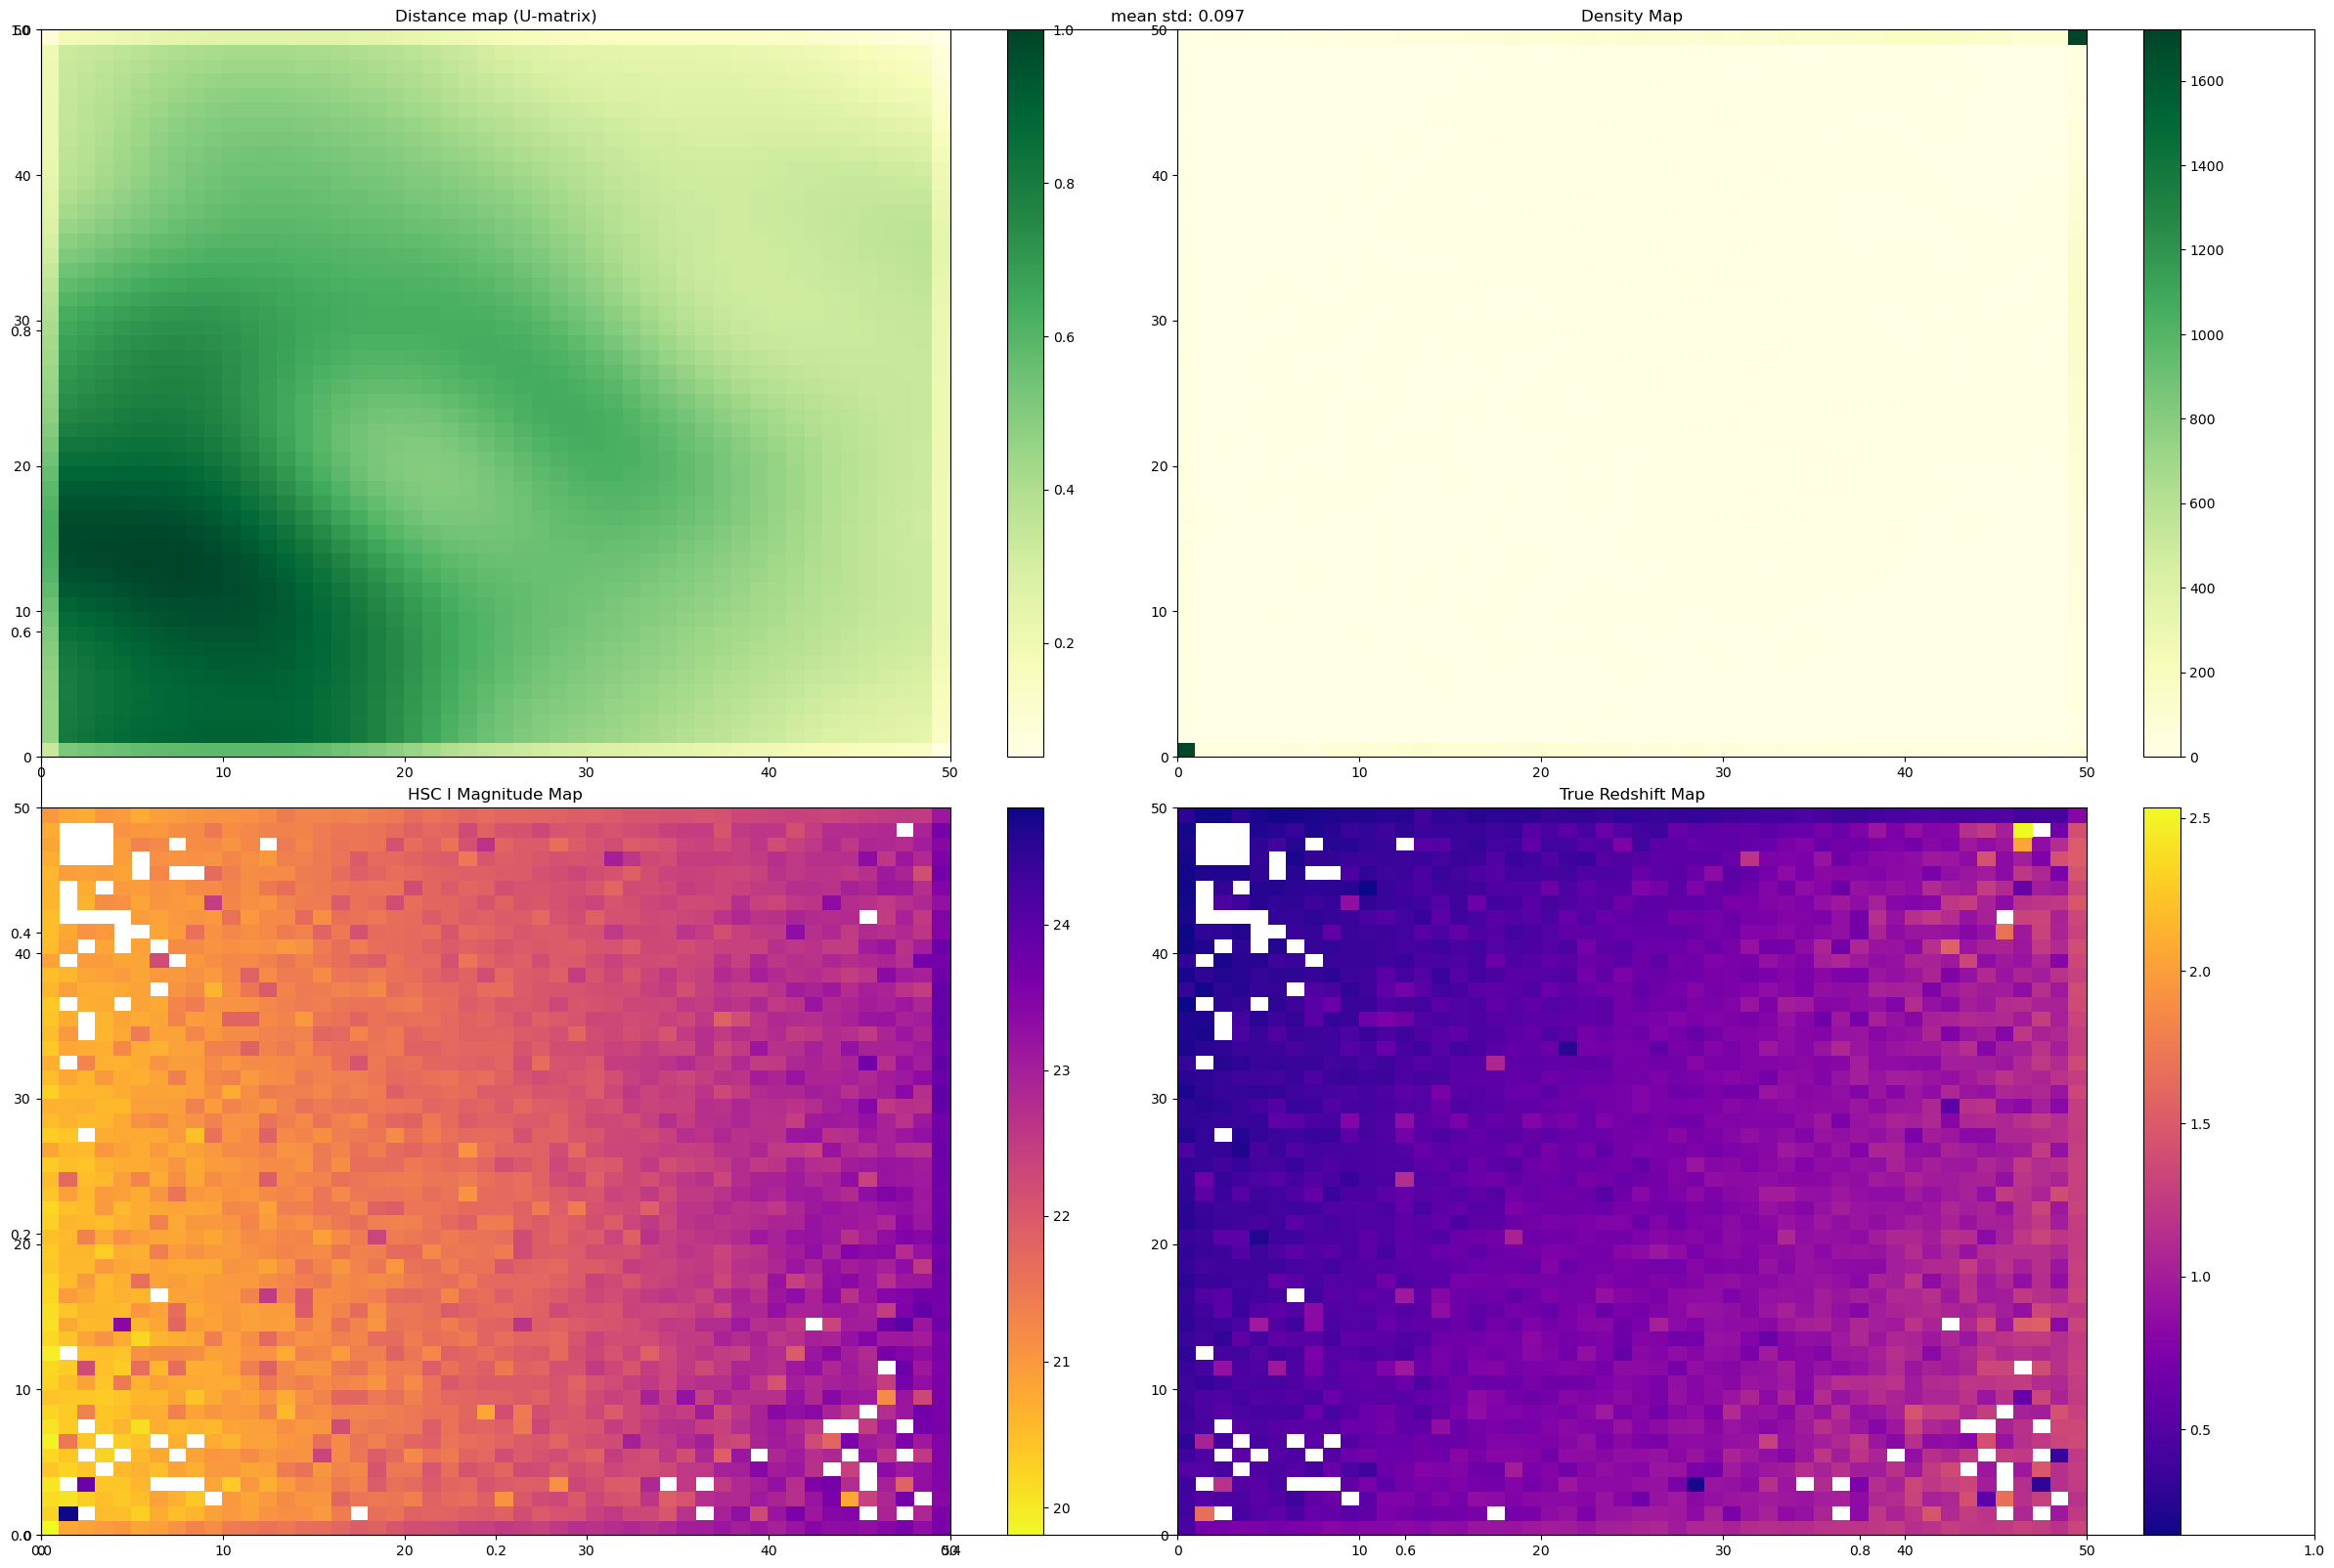

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[50, 20, 0.5]
29683.0
Topological error: 0.012734561870430885
Quantization error: 2.509743158379335
Average redshift std: 0.09642615677185434


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


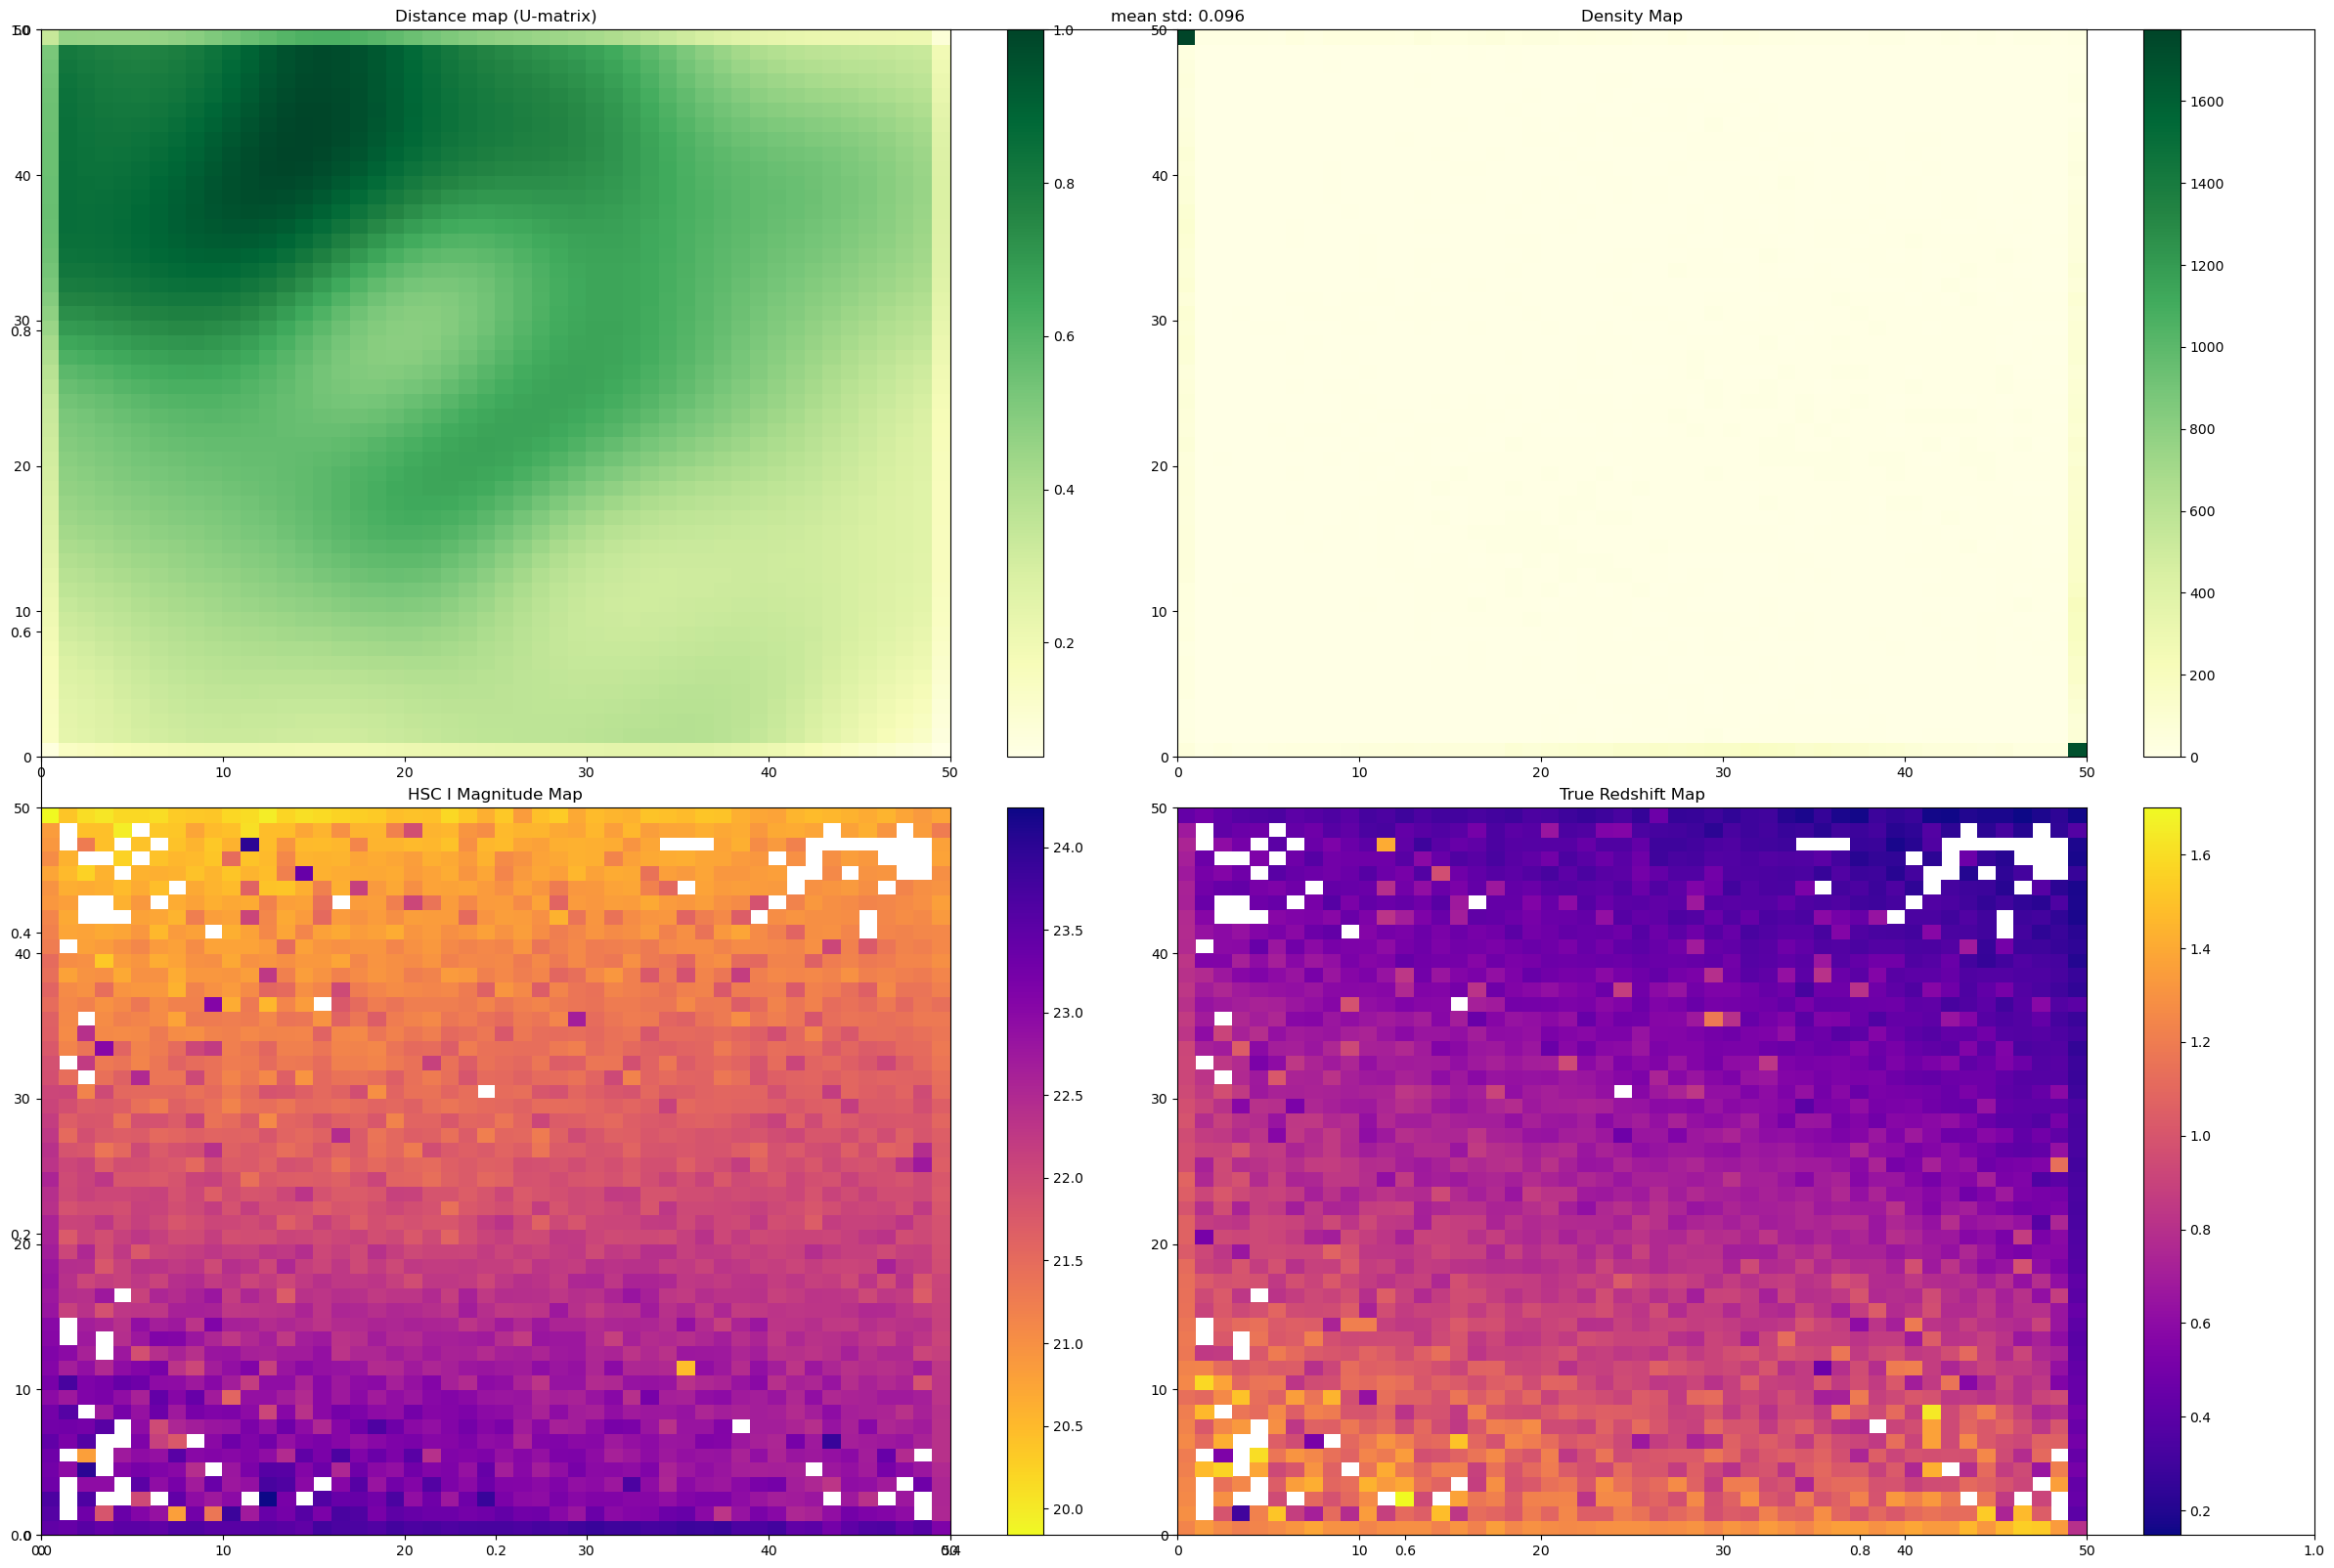

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[50, 20, 0.6]
29683.0
Topological error: 0.013812620018192232
Quantization error: 2.543593445675308
Average redshift std: 0.09582793603344268


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


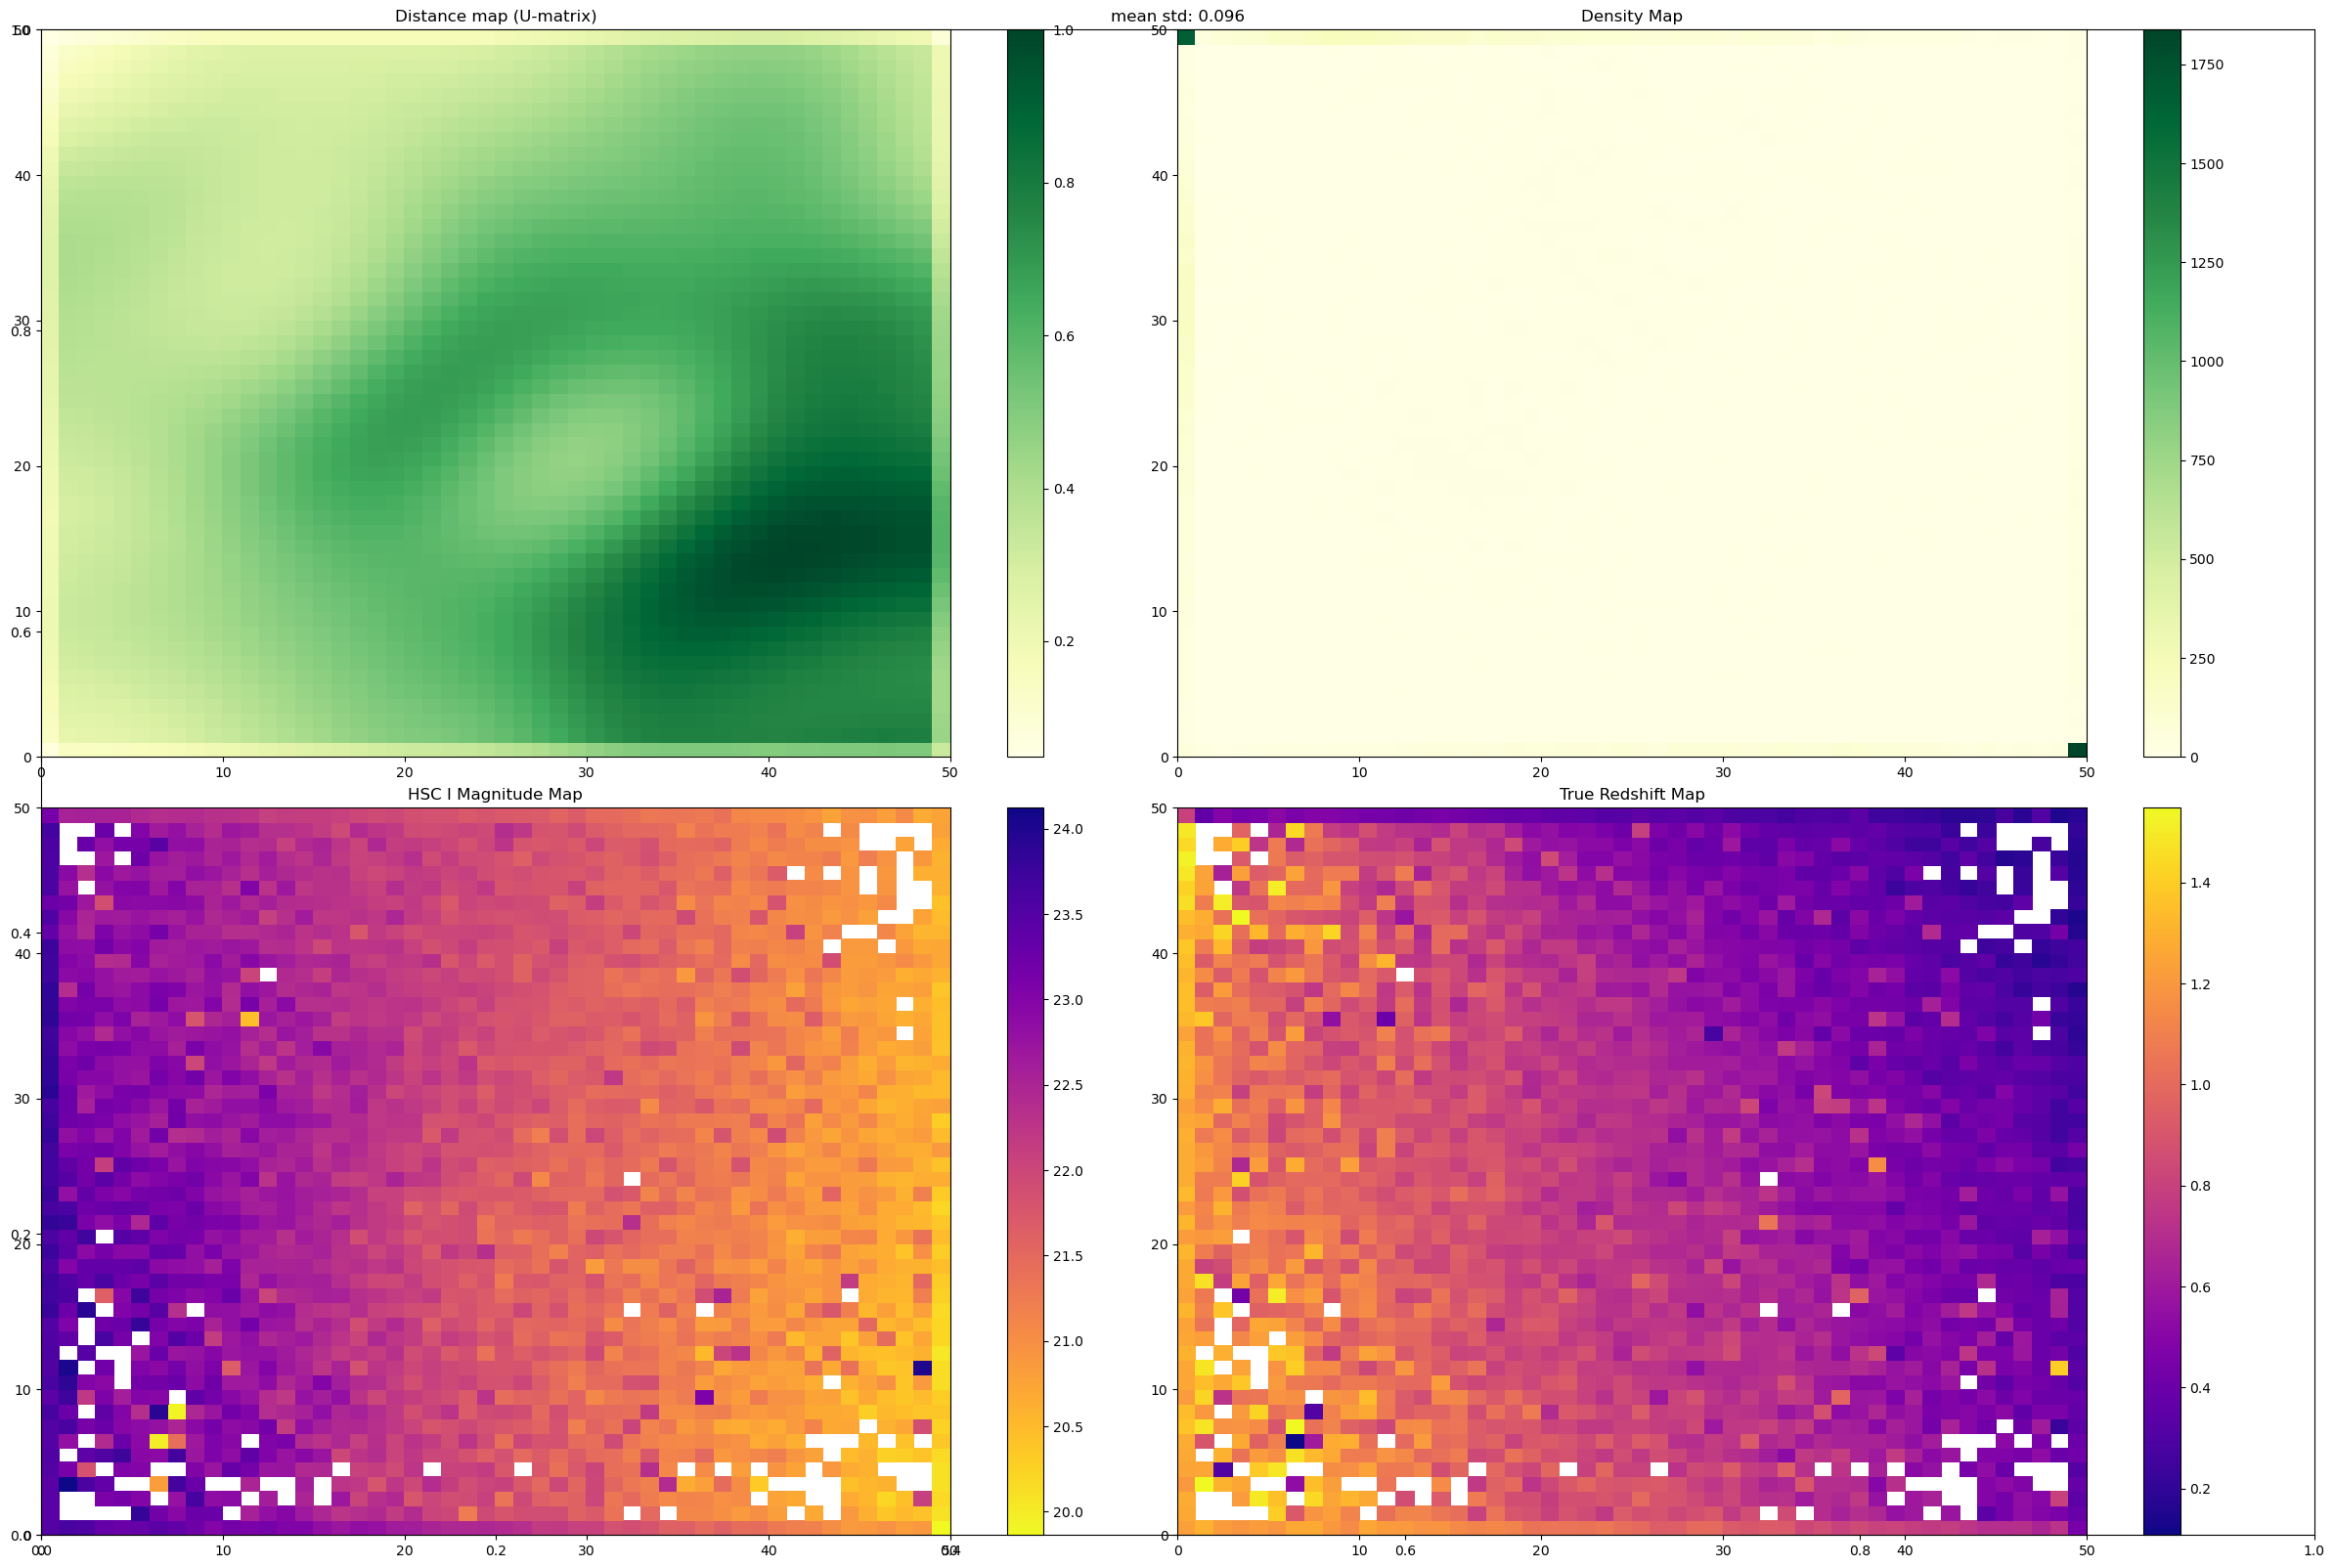

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[50, 20, 0.7]
29683.0
Topological error: 0.01478961021460095
Quantization error: 2.5756381616667117
Average redshift std: 0.09606097979264037


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


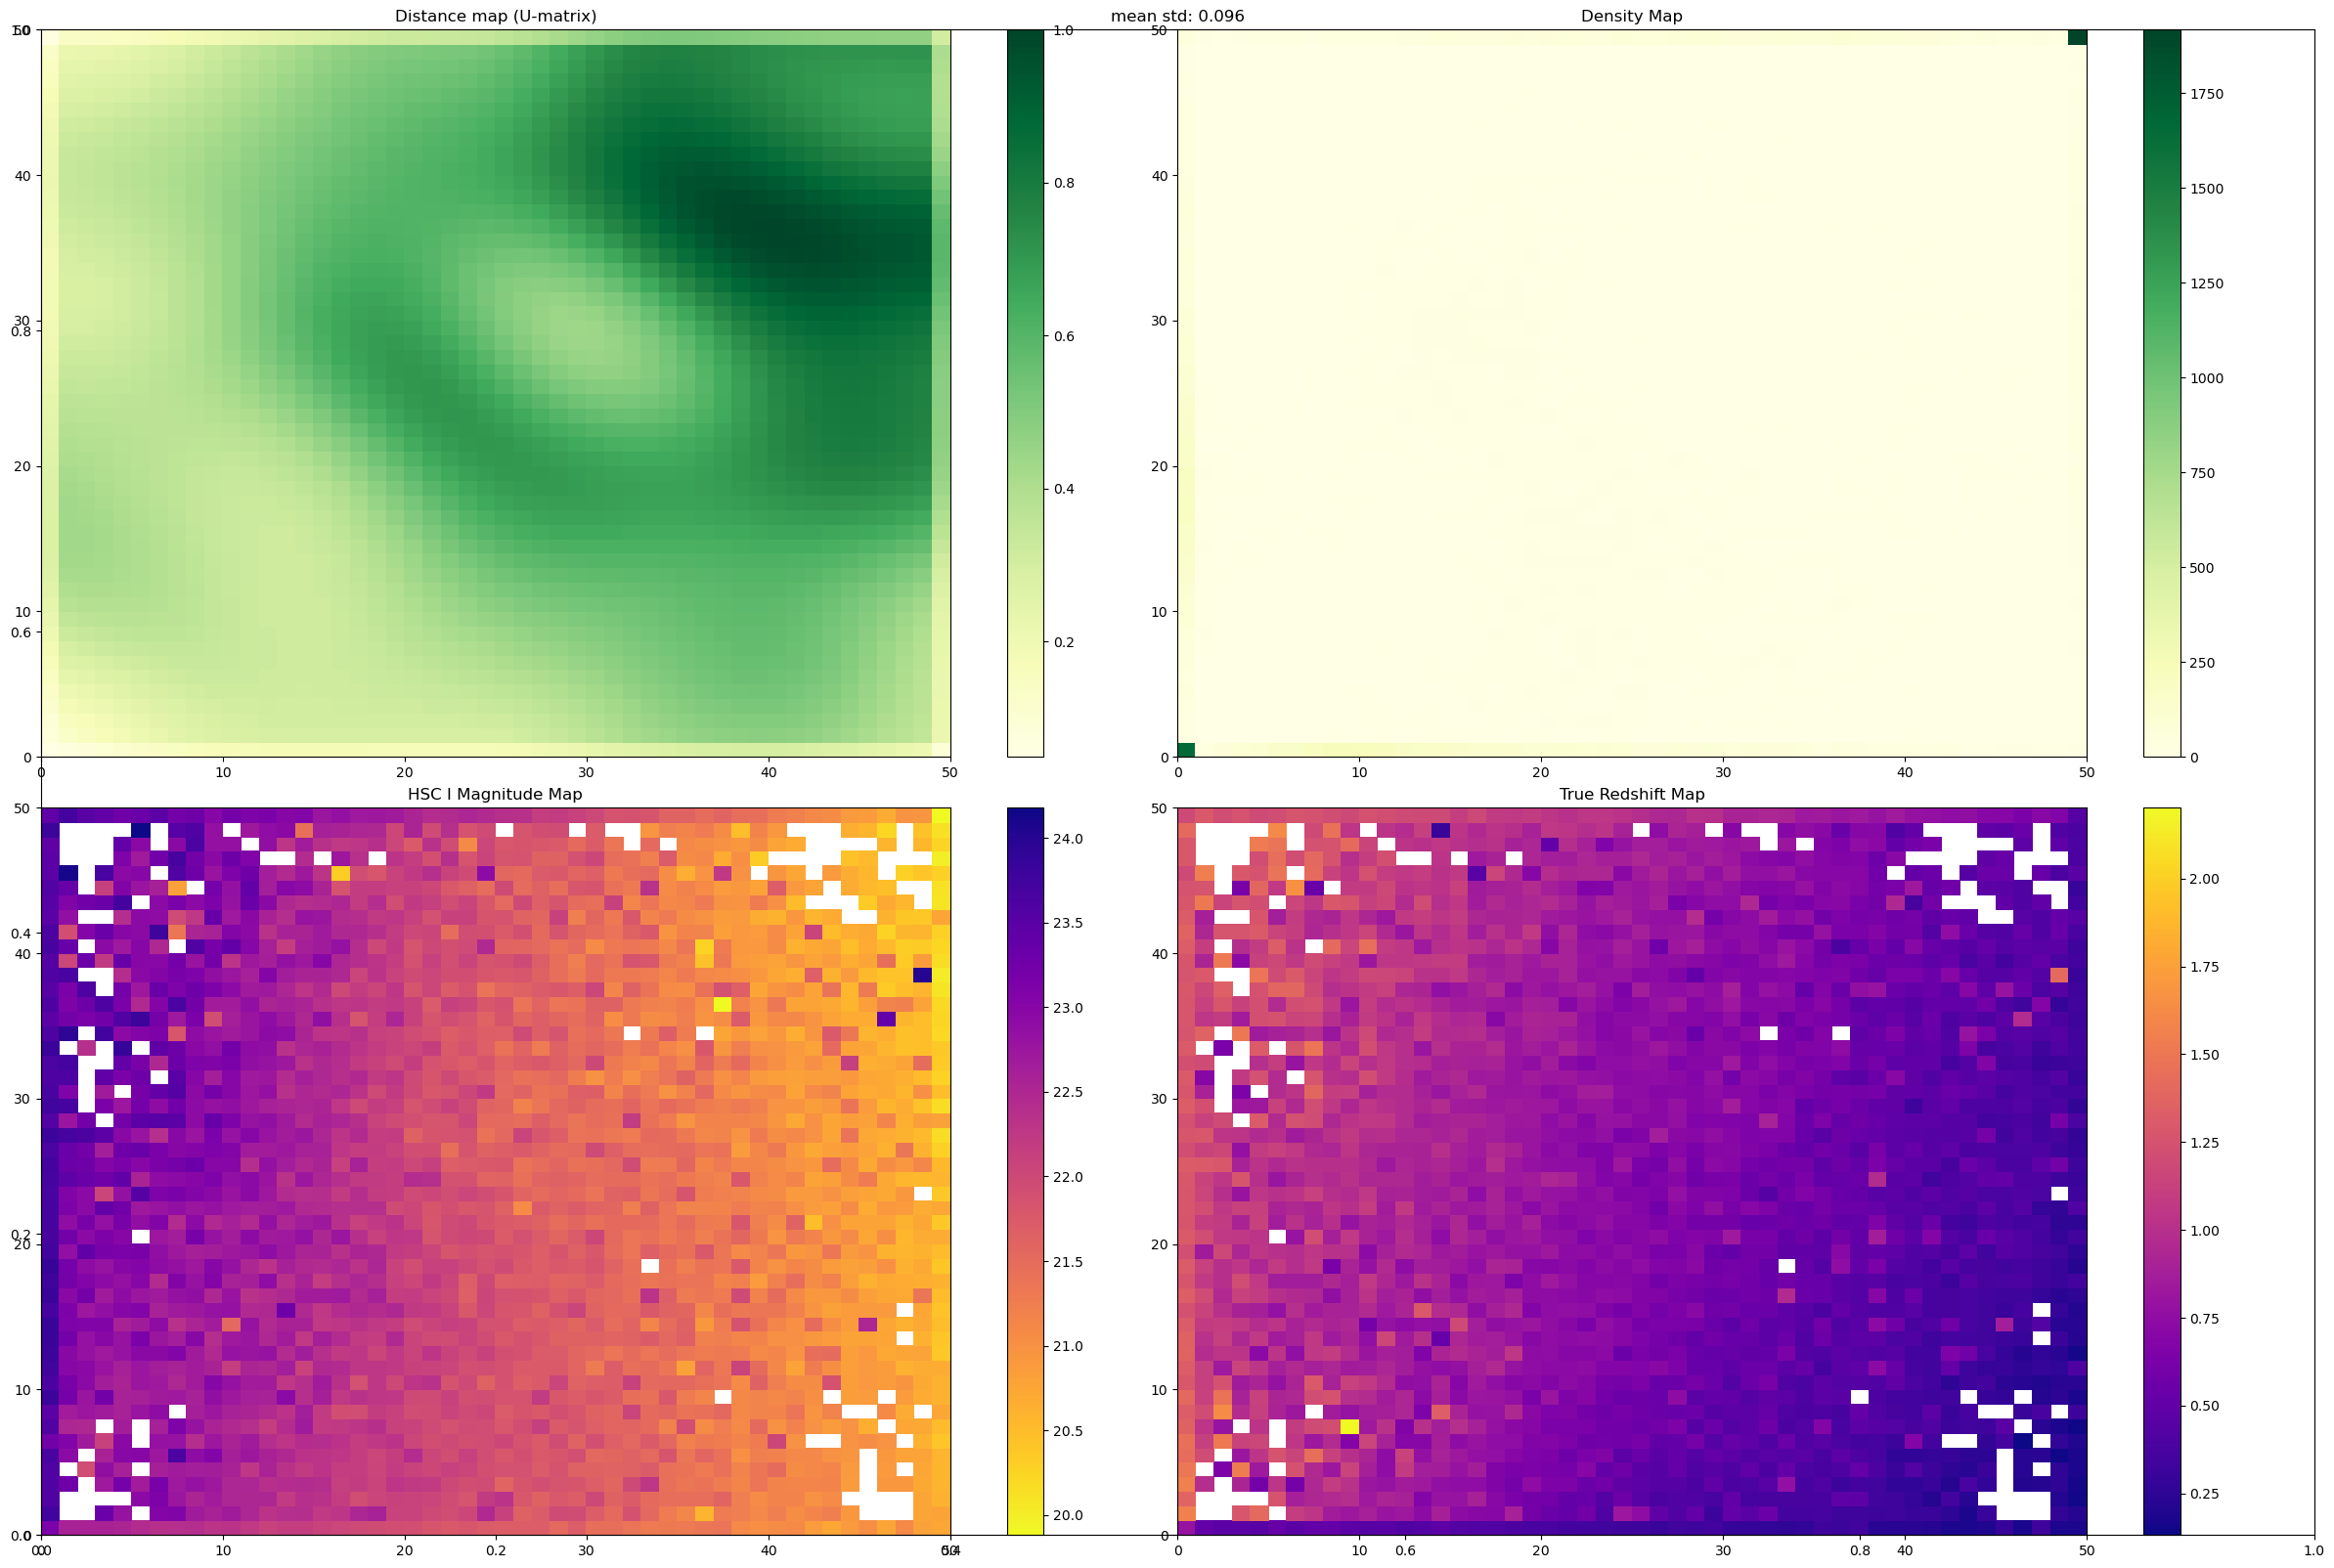

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[50, 20, 0.8]
29683.0
Topological error: 0.015665532459657044
Quantization error: 2.5976180685616193
Average redshift std: 0.09513545074147184


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


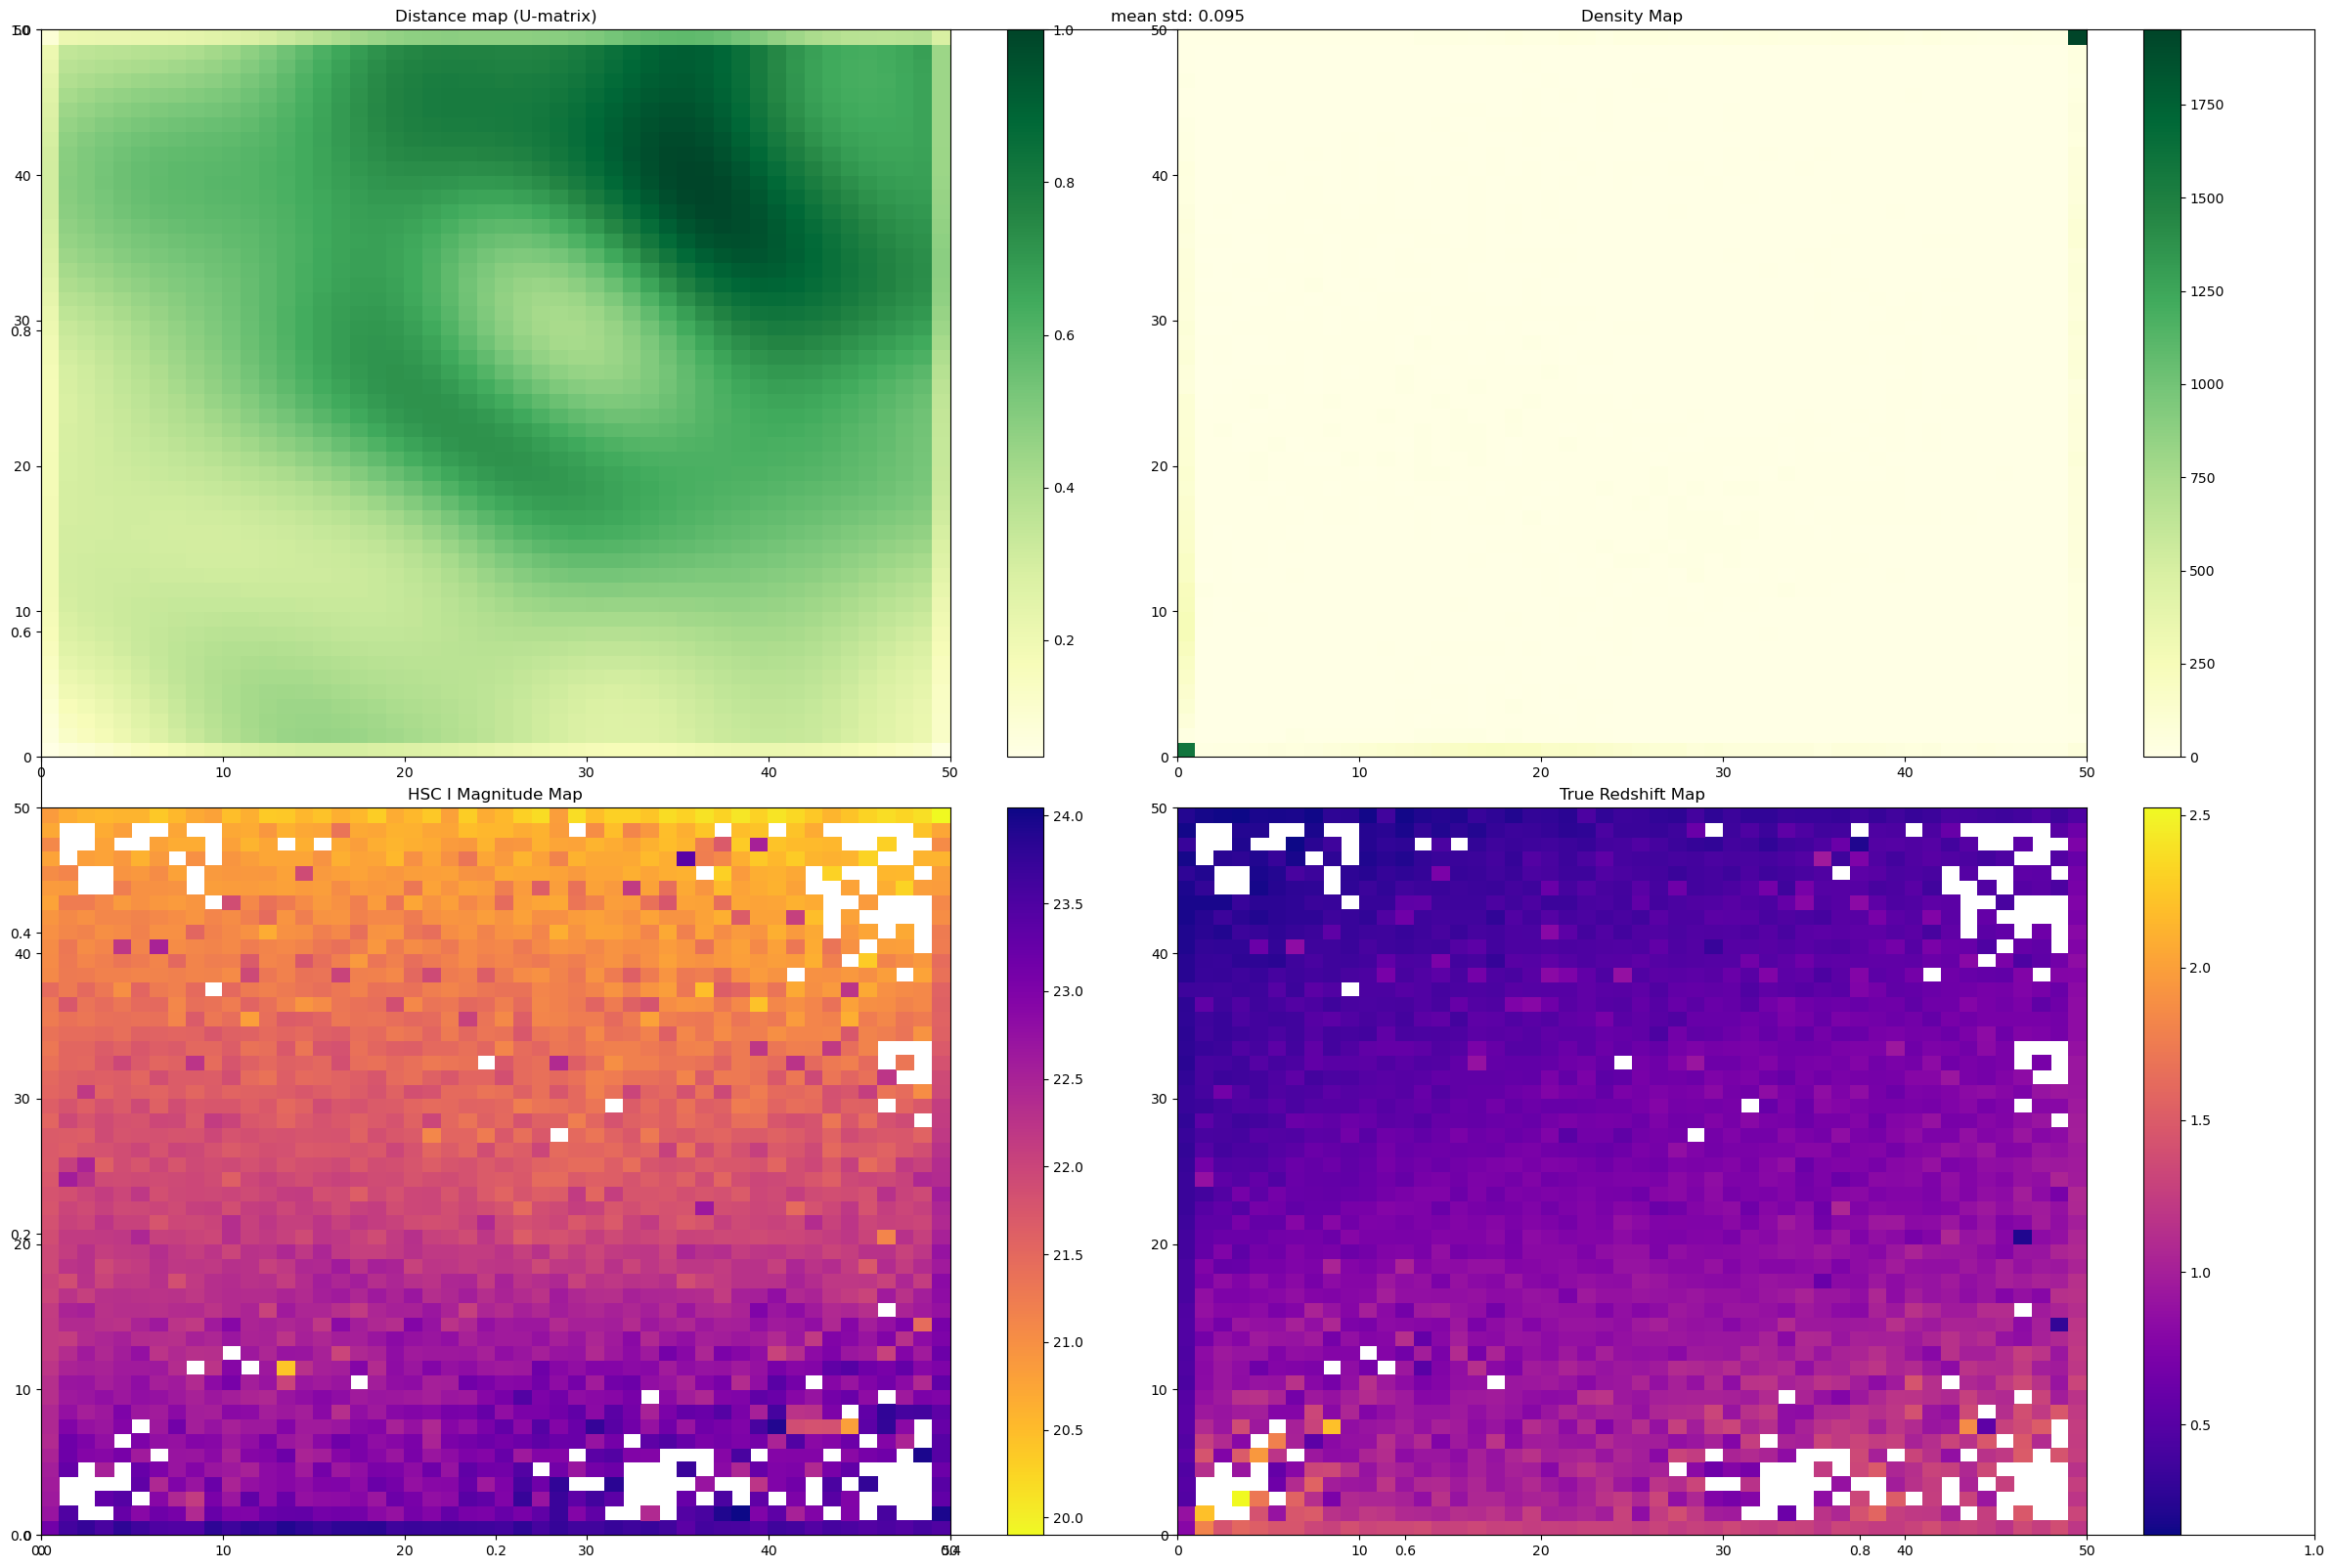

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[50, 20, 0.9]
29683.0
Topological error: 0.017552134218239396
Quantization error: 2.62029192275397
Average redshift std: 0.09539002101841865


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


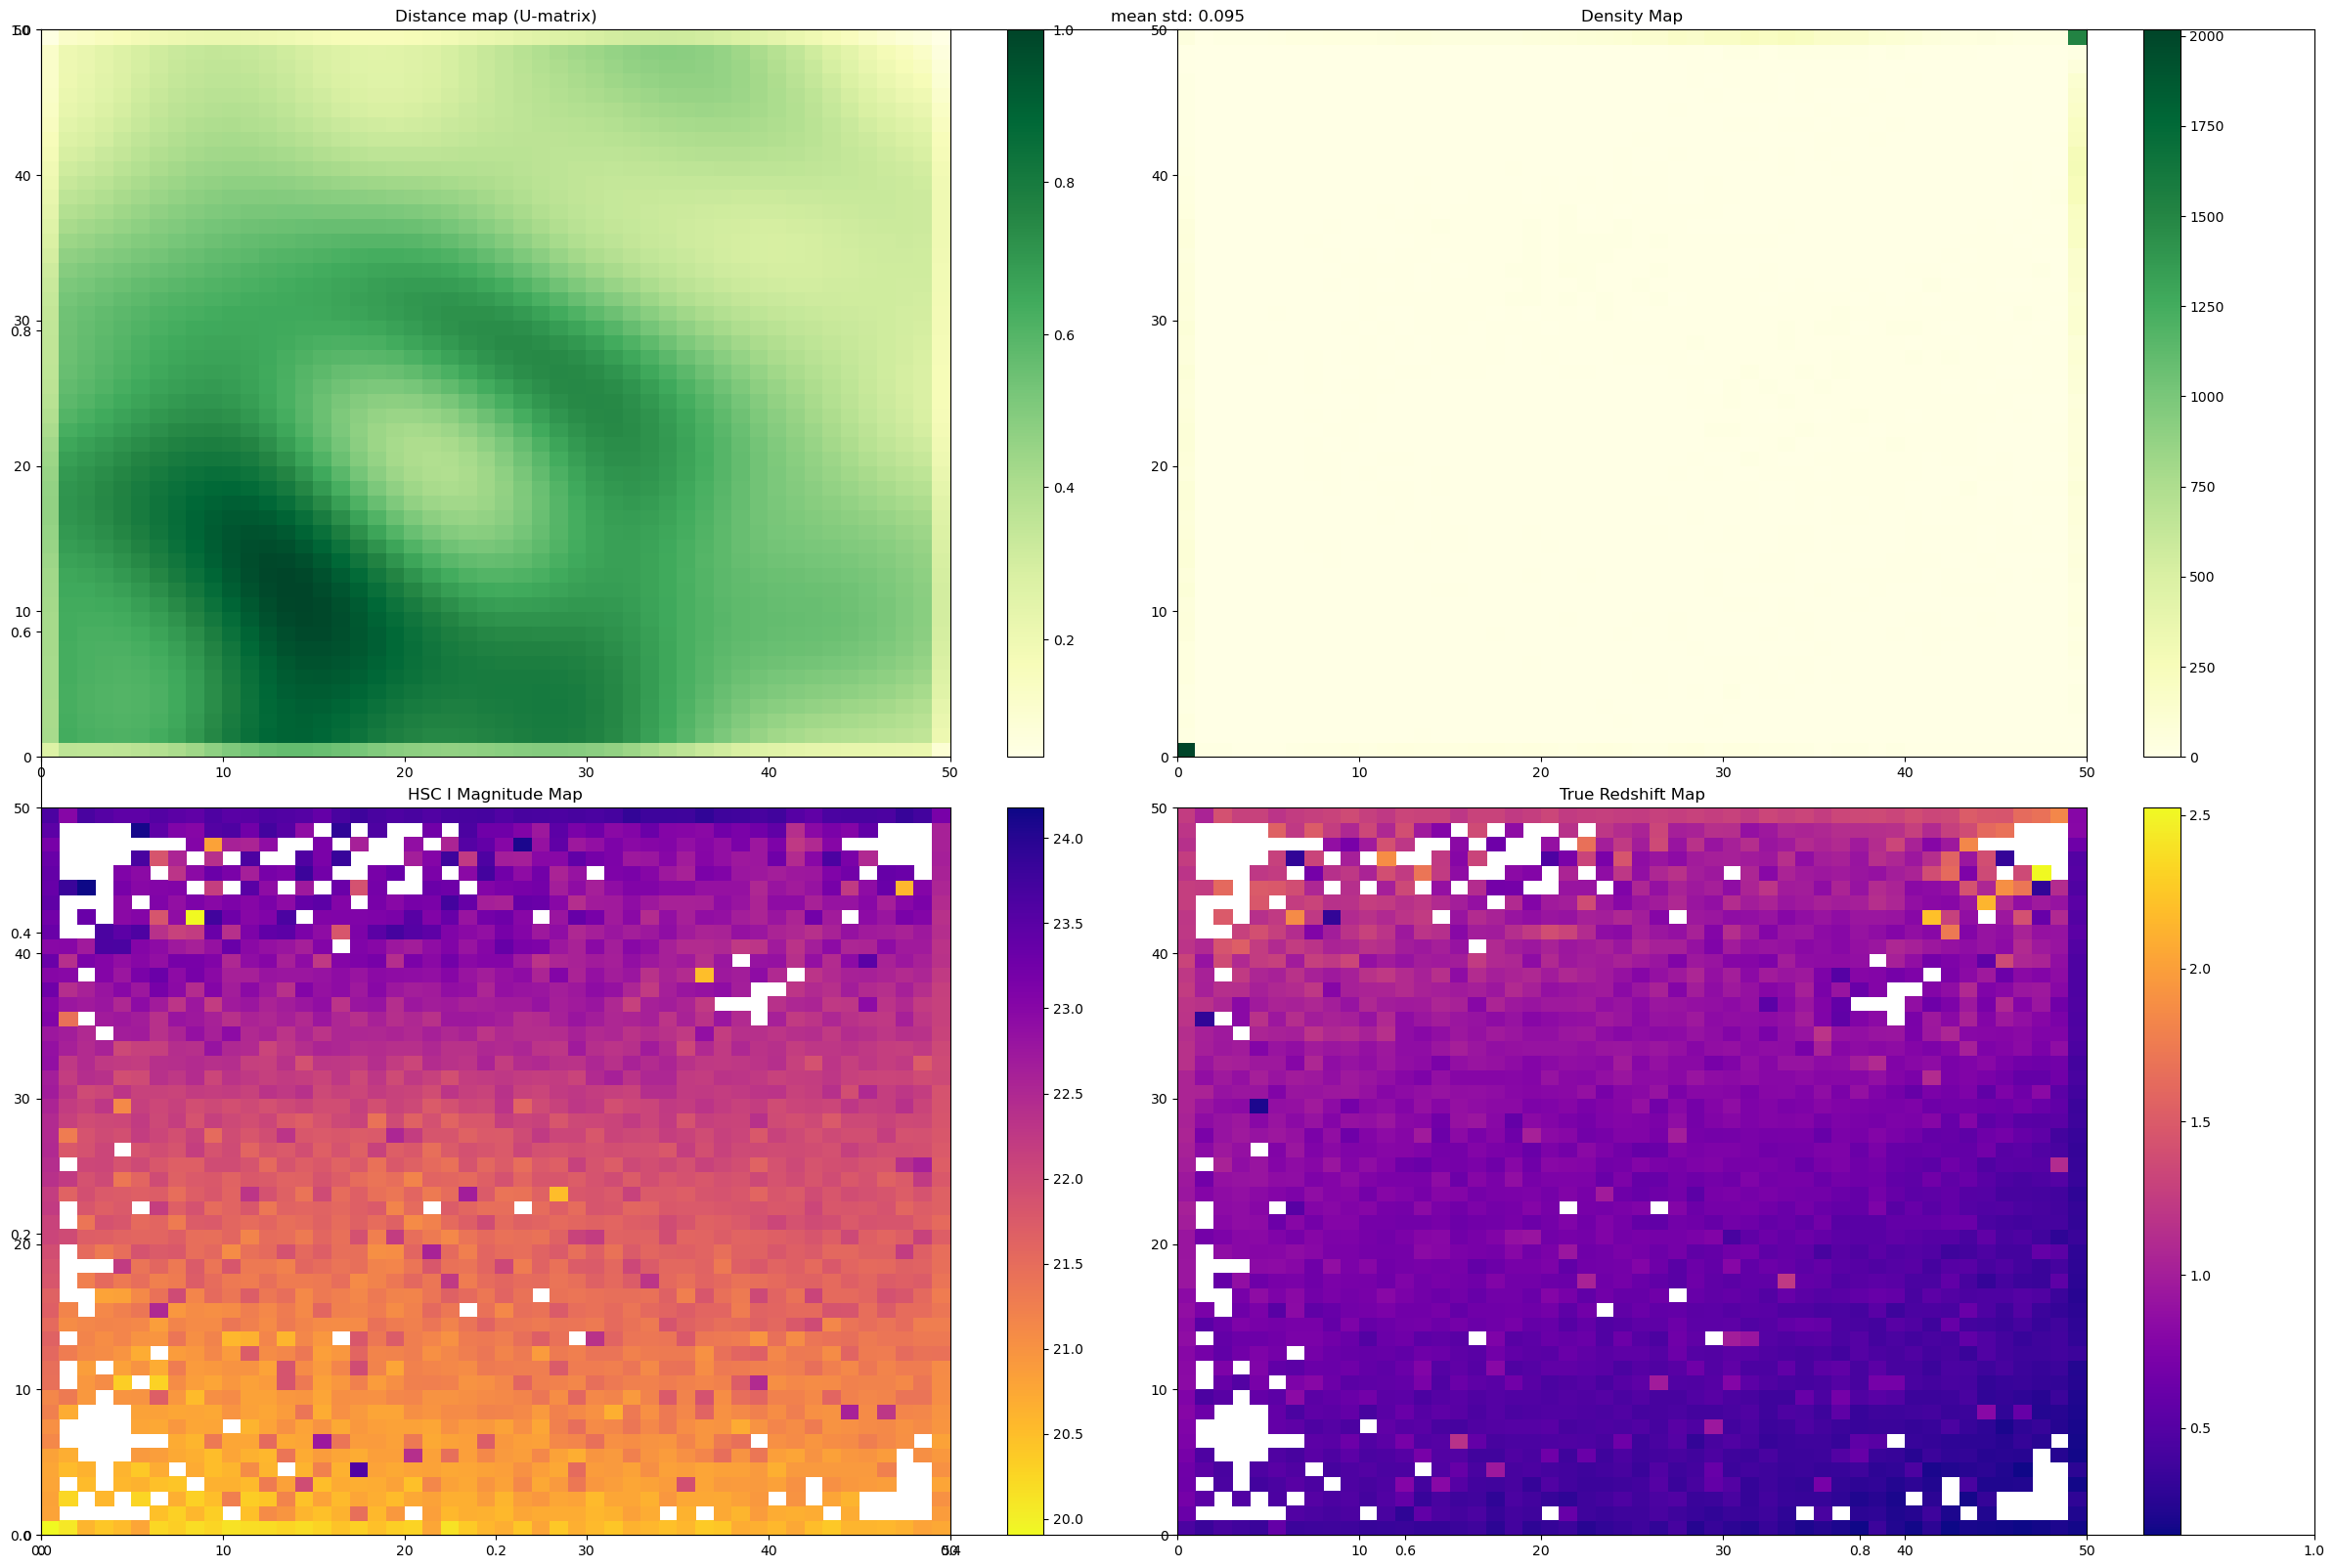

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[50, 20, 1]
29683.0
Topological error: 0.0169120371930061
Quantization error: 2.6420493049696847
Average redshift std: 0.09471421617362197


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


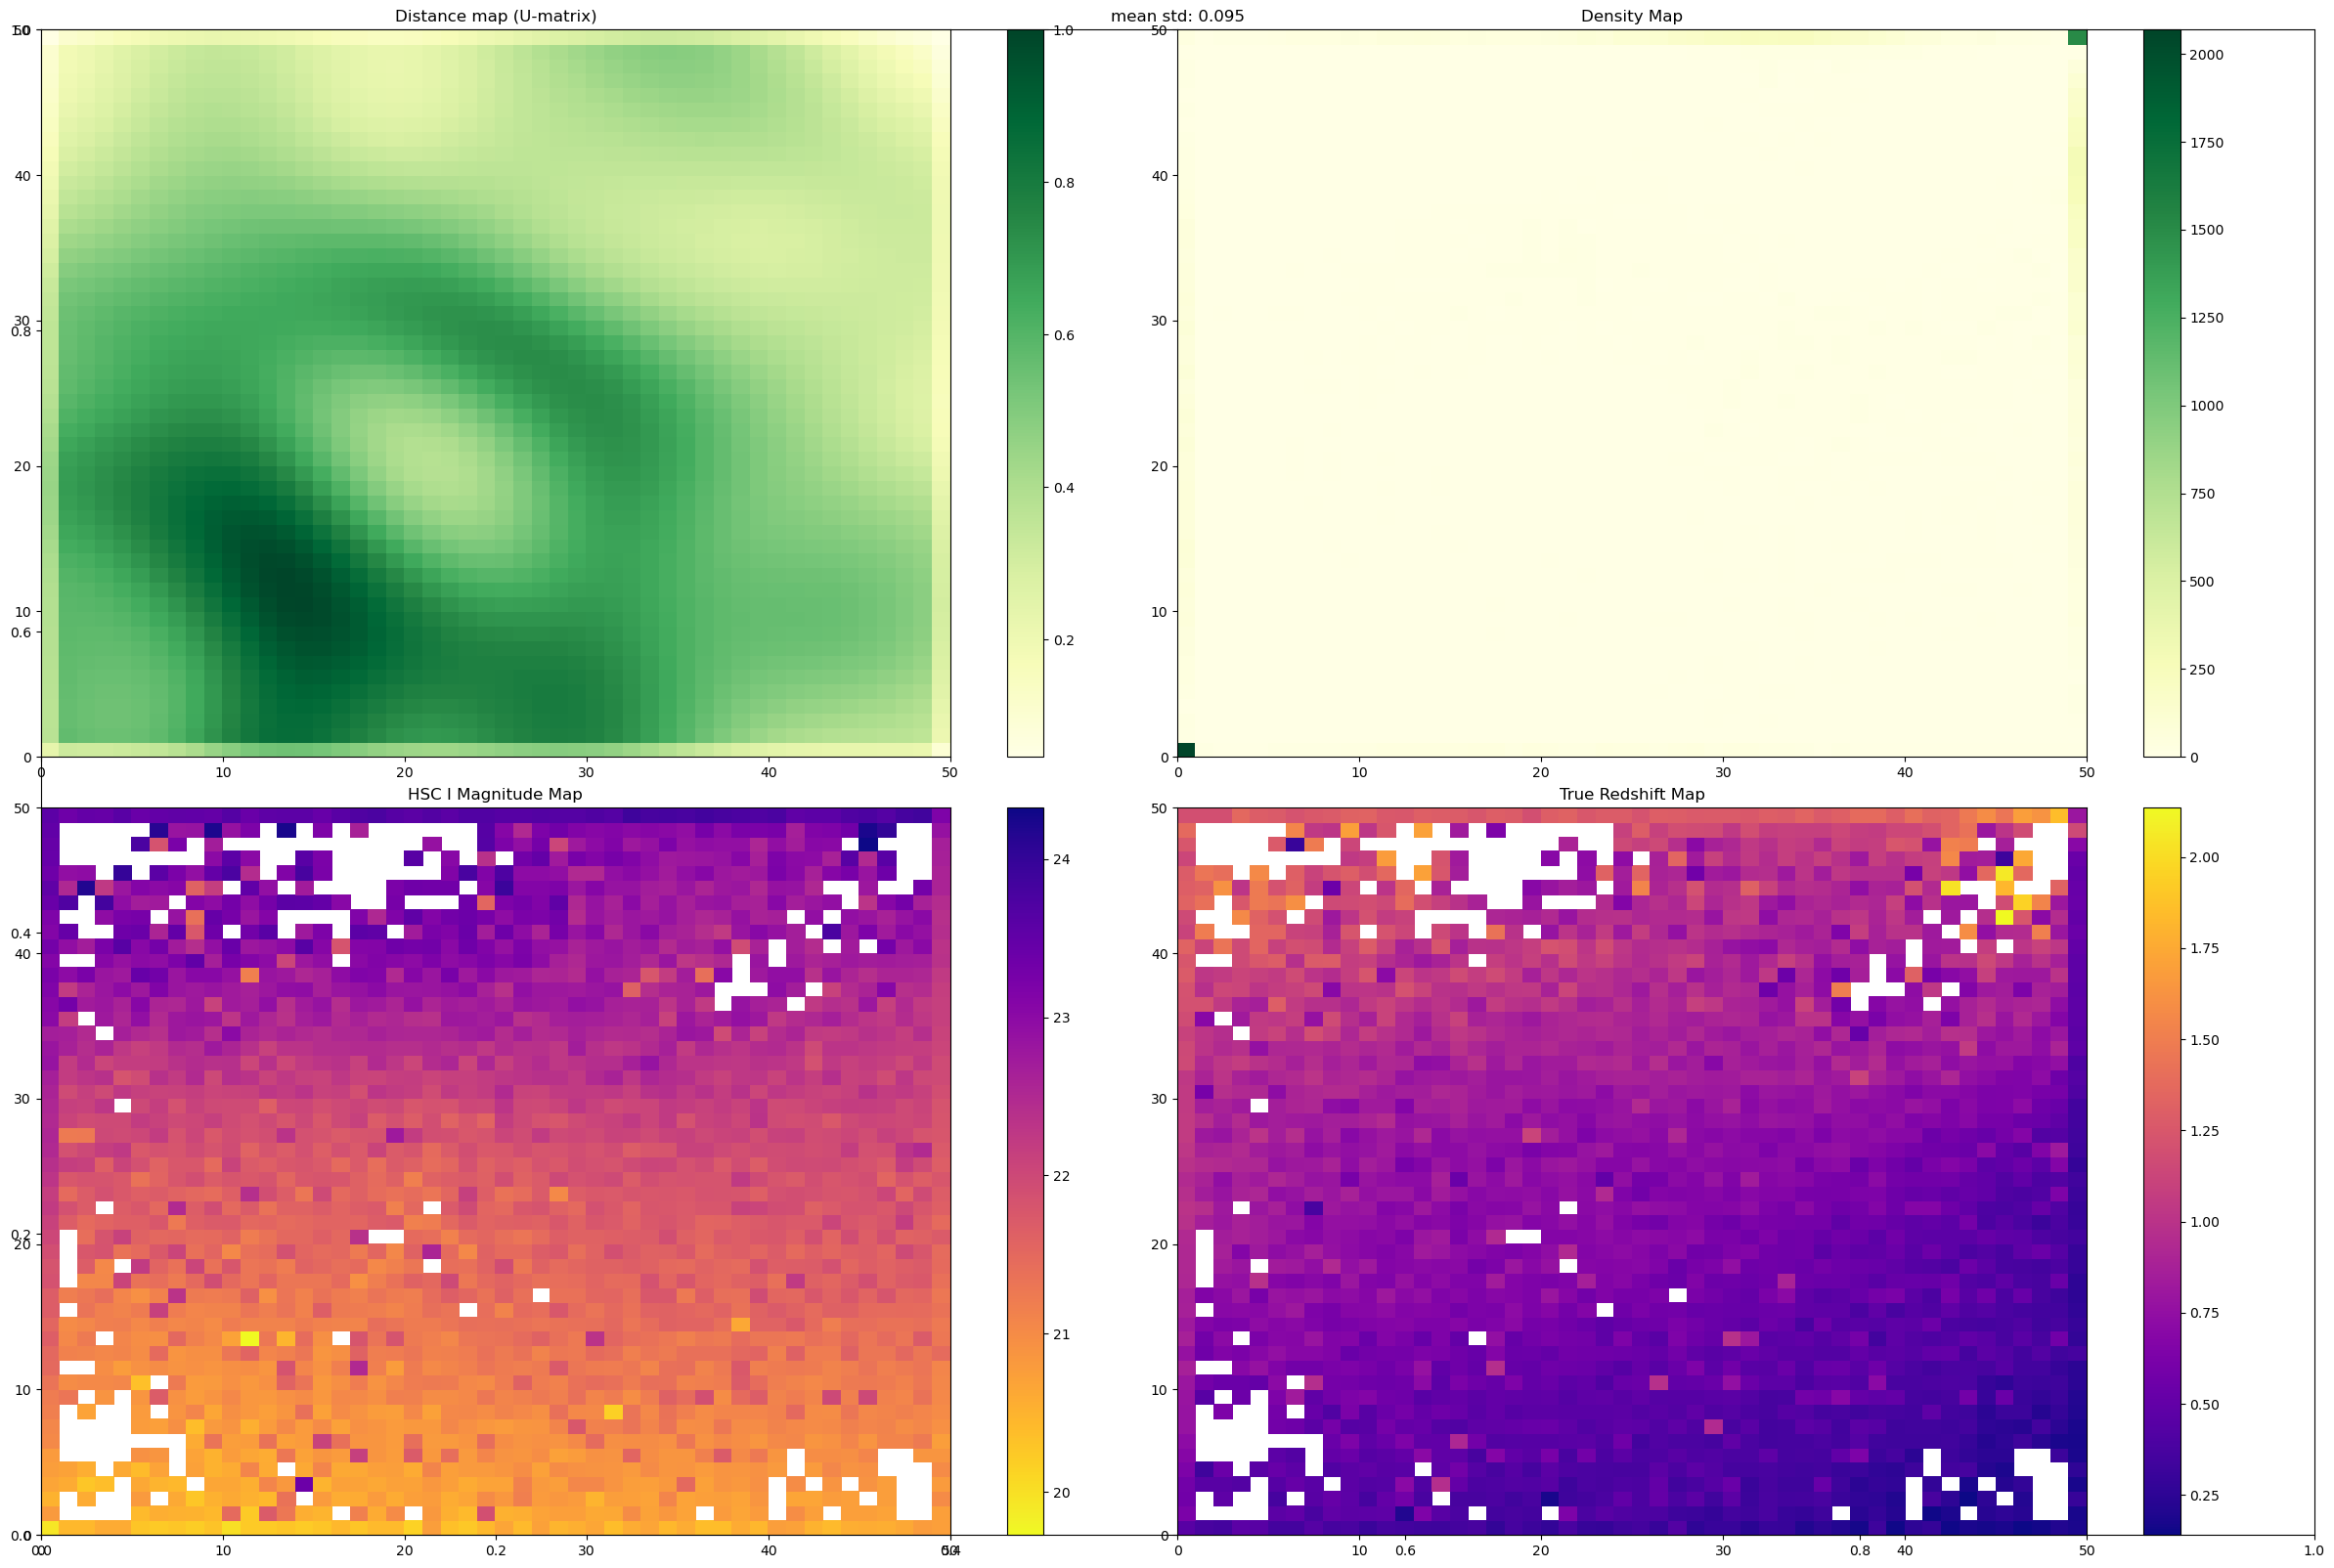

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[50, 20, 2]
29683.0
Topological error: 0.031634268773371964
Quantization error: 2.7341418051158173
Average redshift std: 0.0943428006196815


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


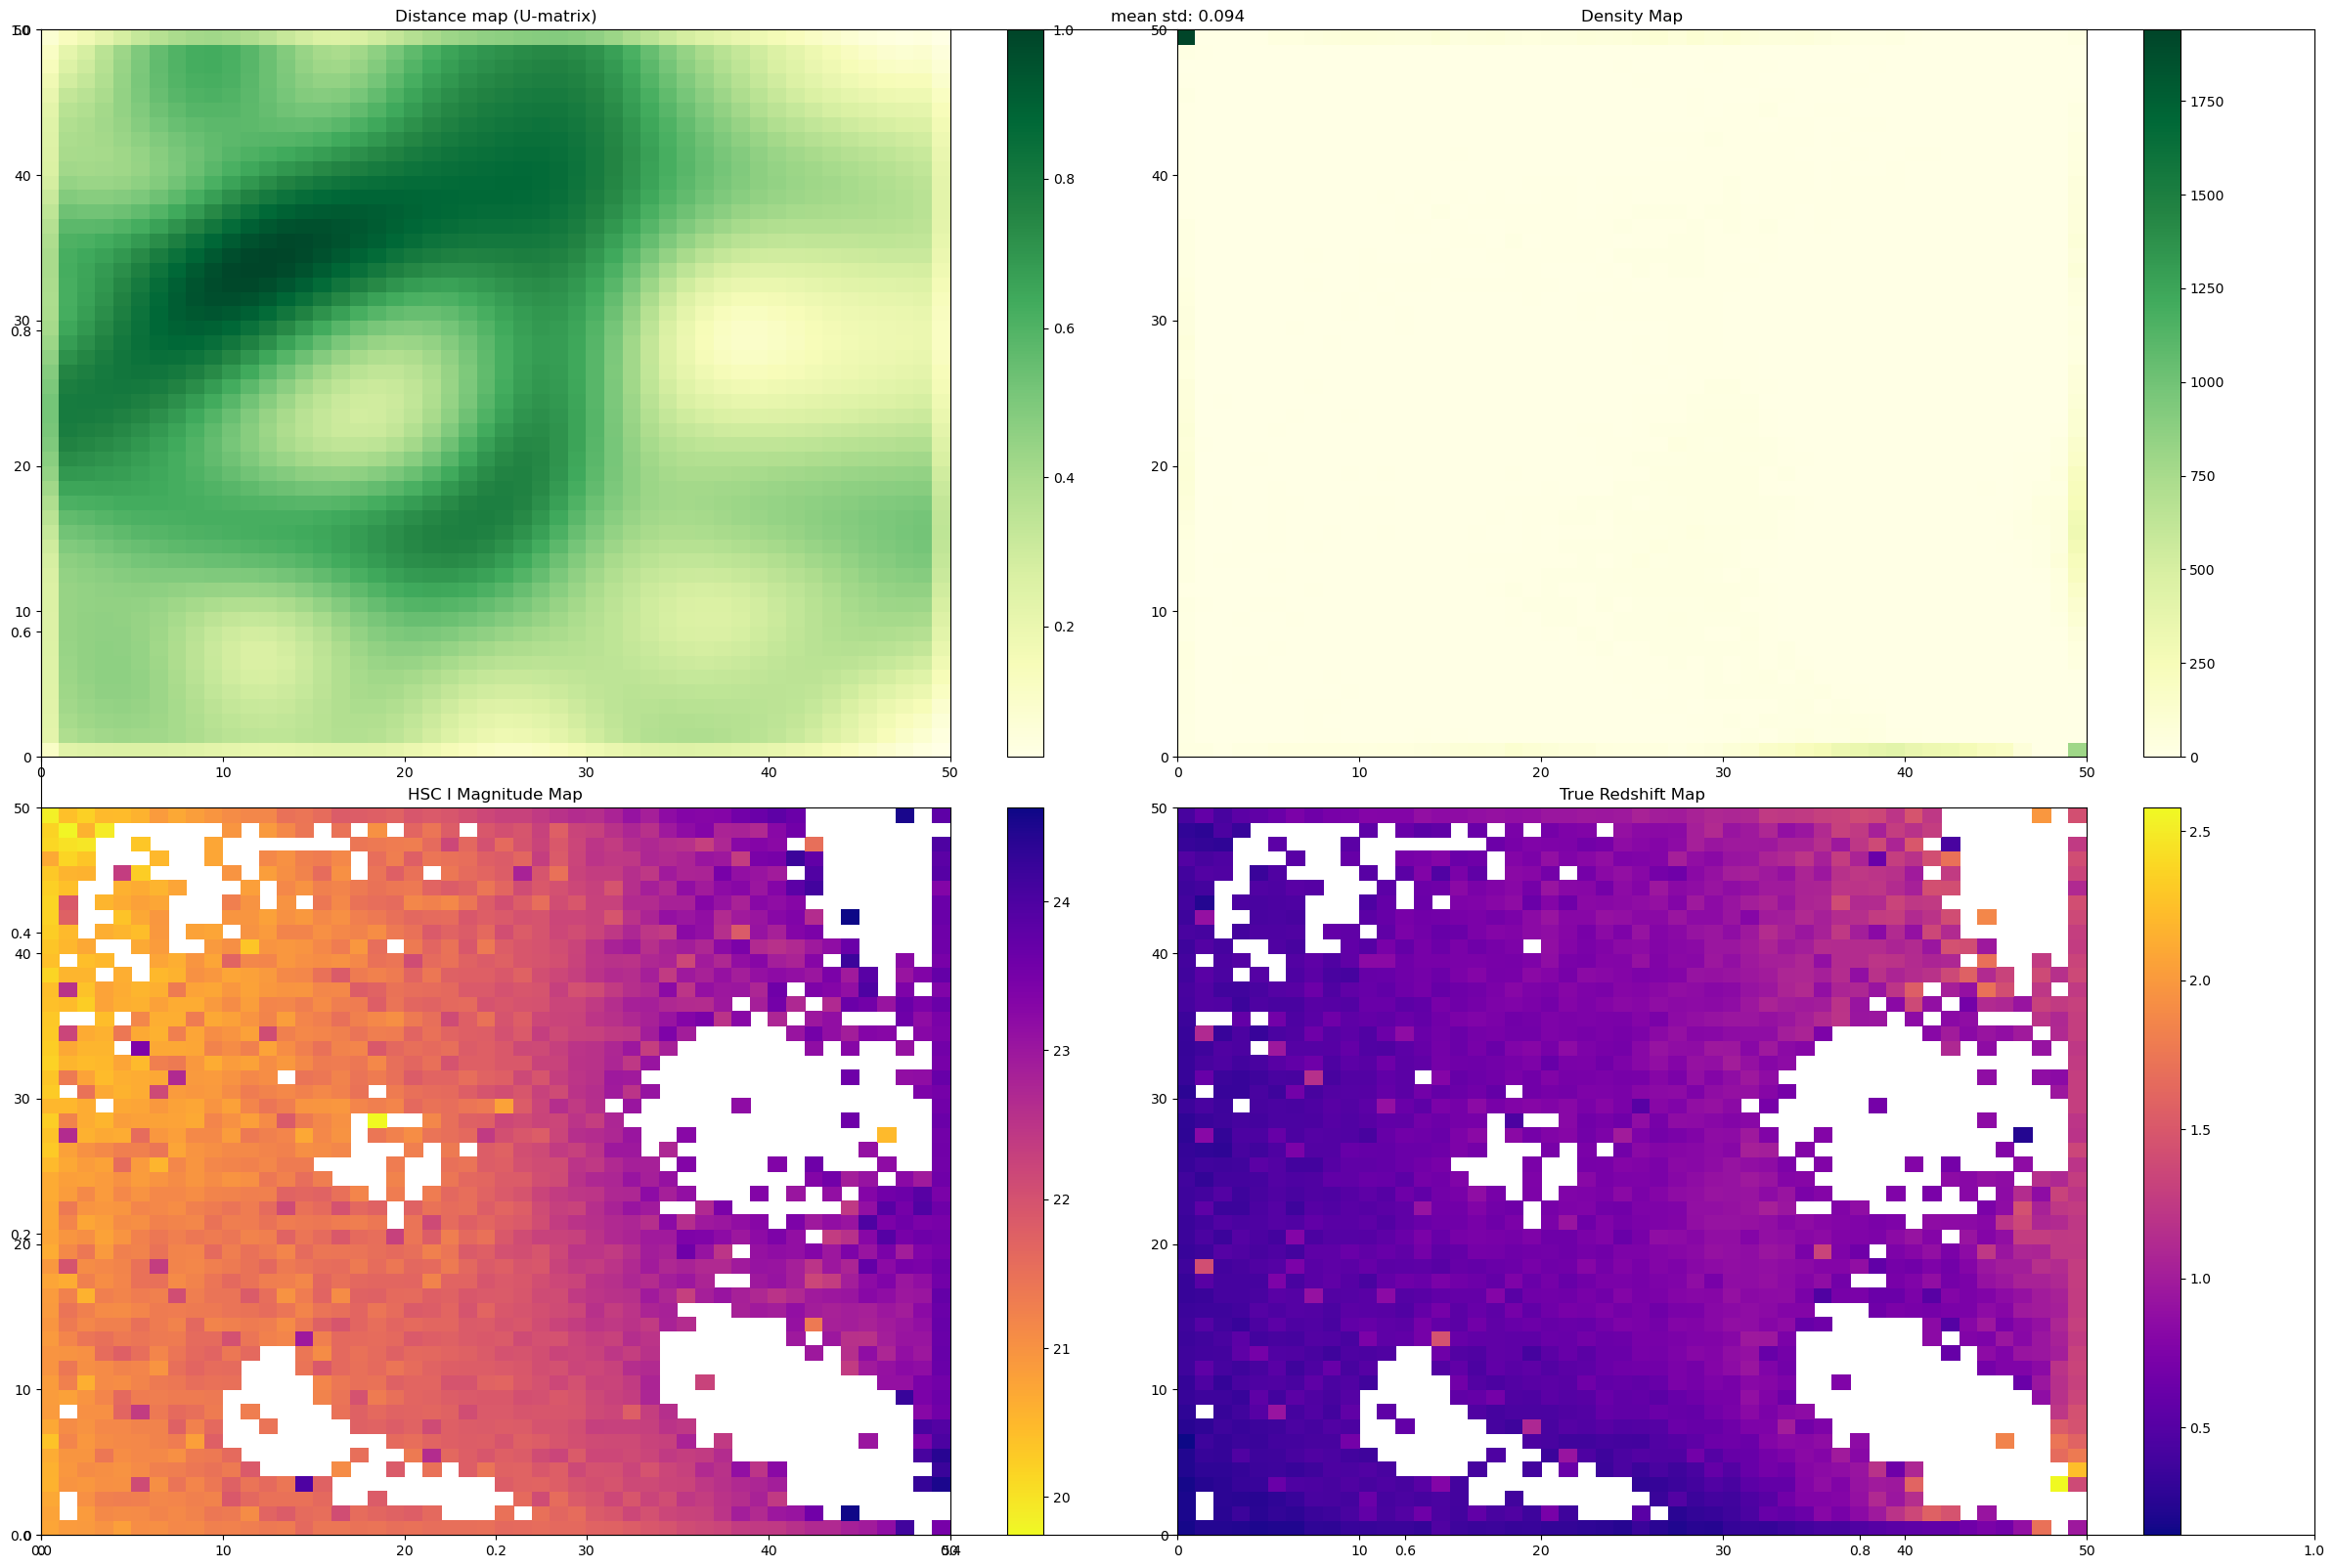

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[50, 20, 3]
29683.0
Topological error: 0.06852407101708048
Quantization error: 2.792341366742355
Average redshift std: 0.09714060367967267


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


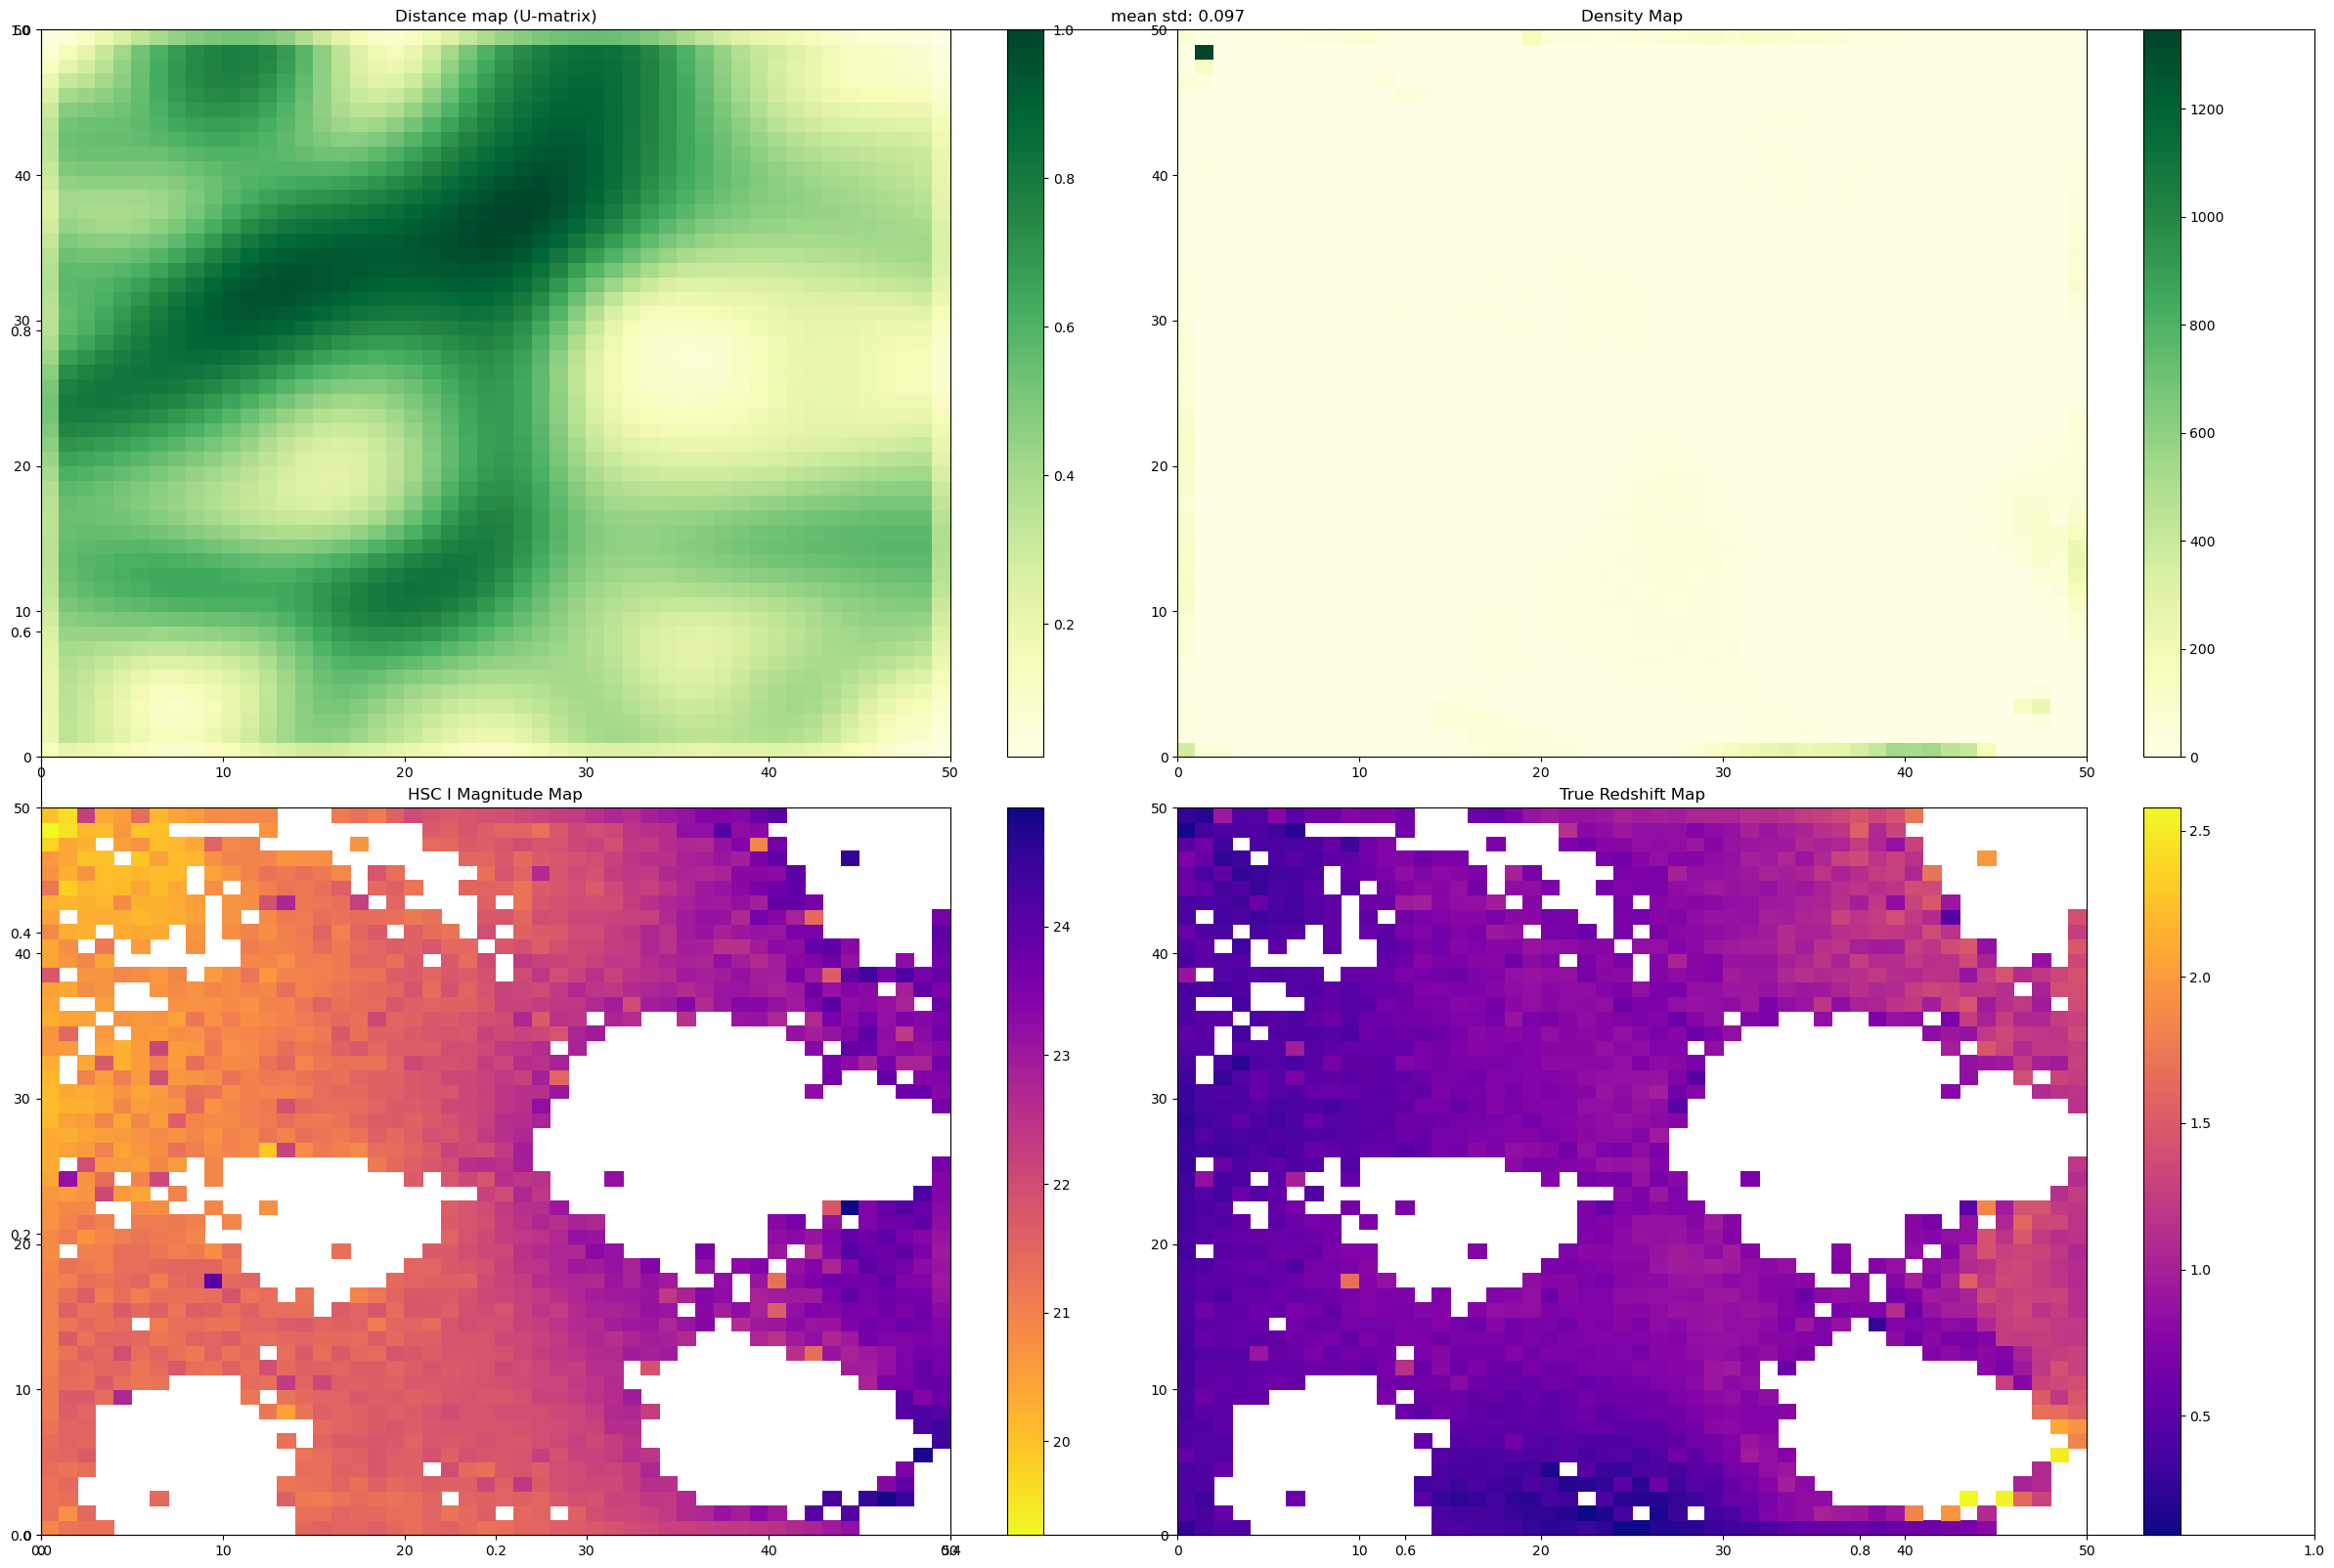

Data shape: (29683, 102)
Start making diagrams...


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[50, 20, 4]
29683.0
Topological error: 0.10746892160495906
Quantization error: 2.8107477870413757
Average redshift std: 0.10027504324292344


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


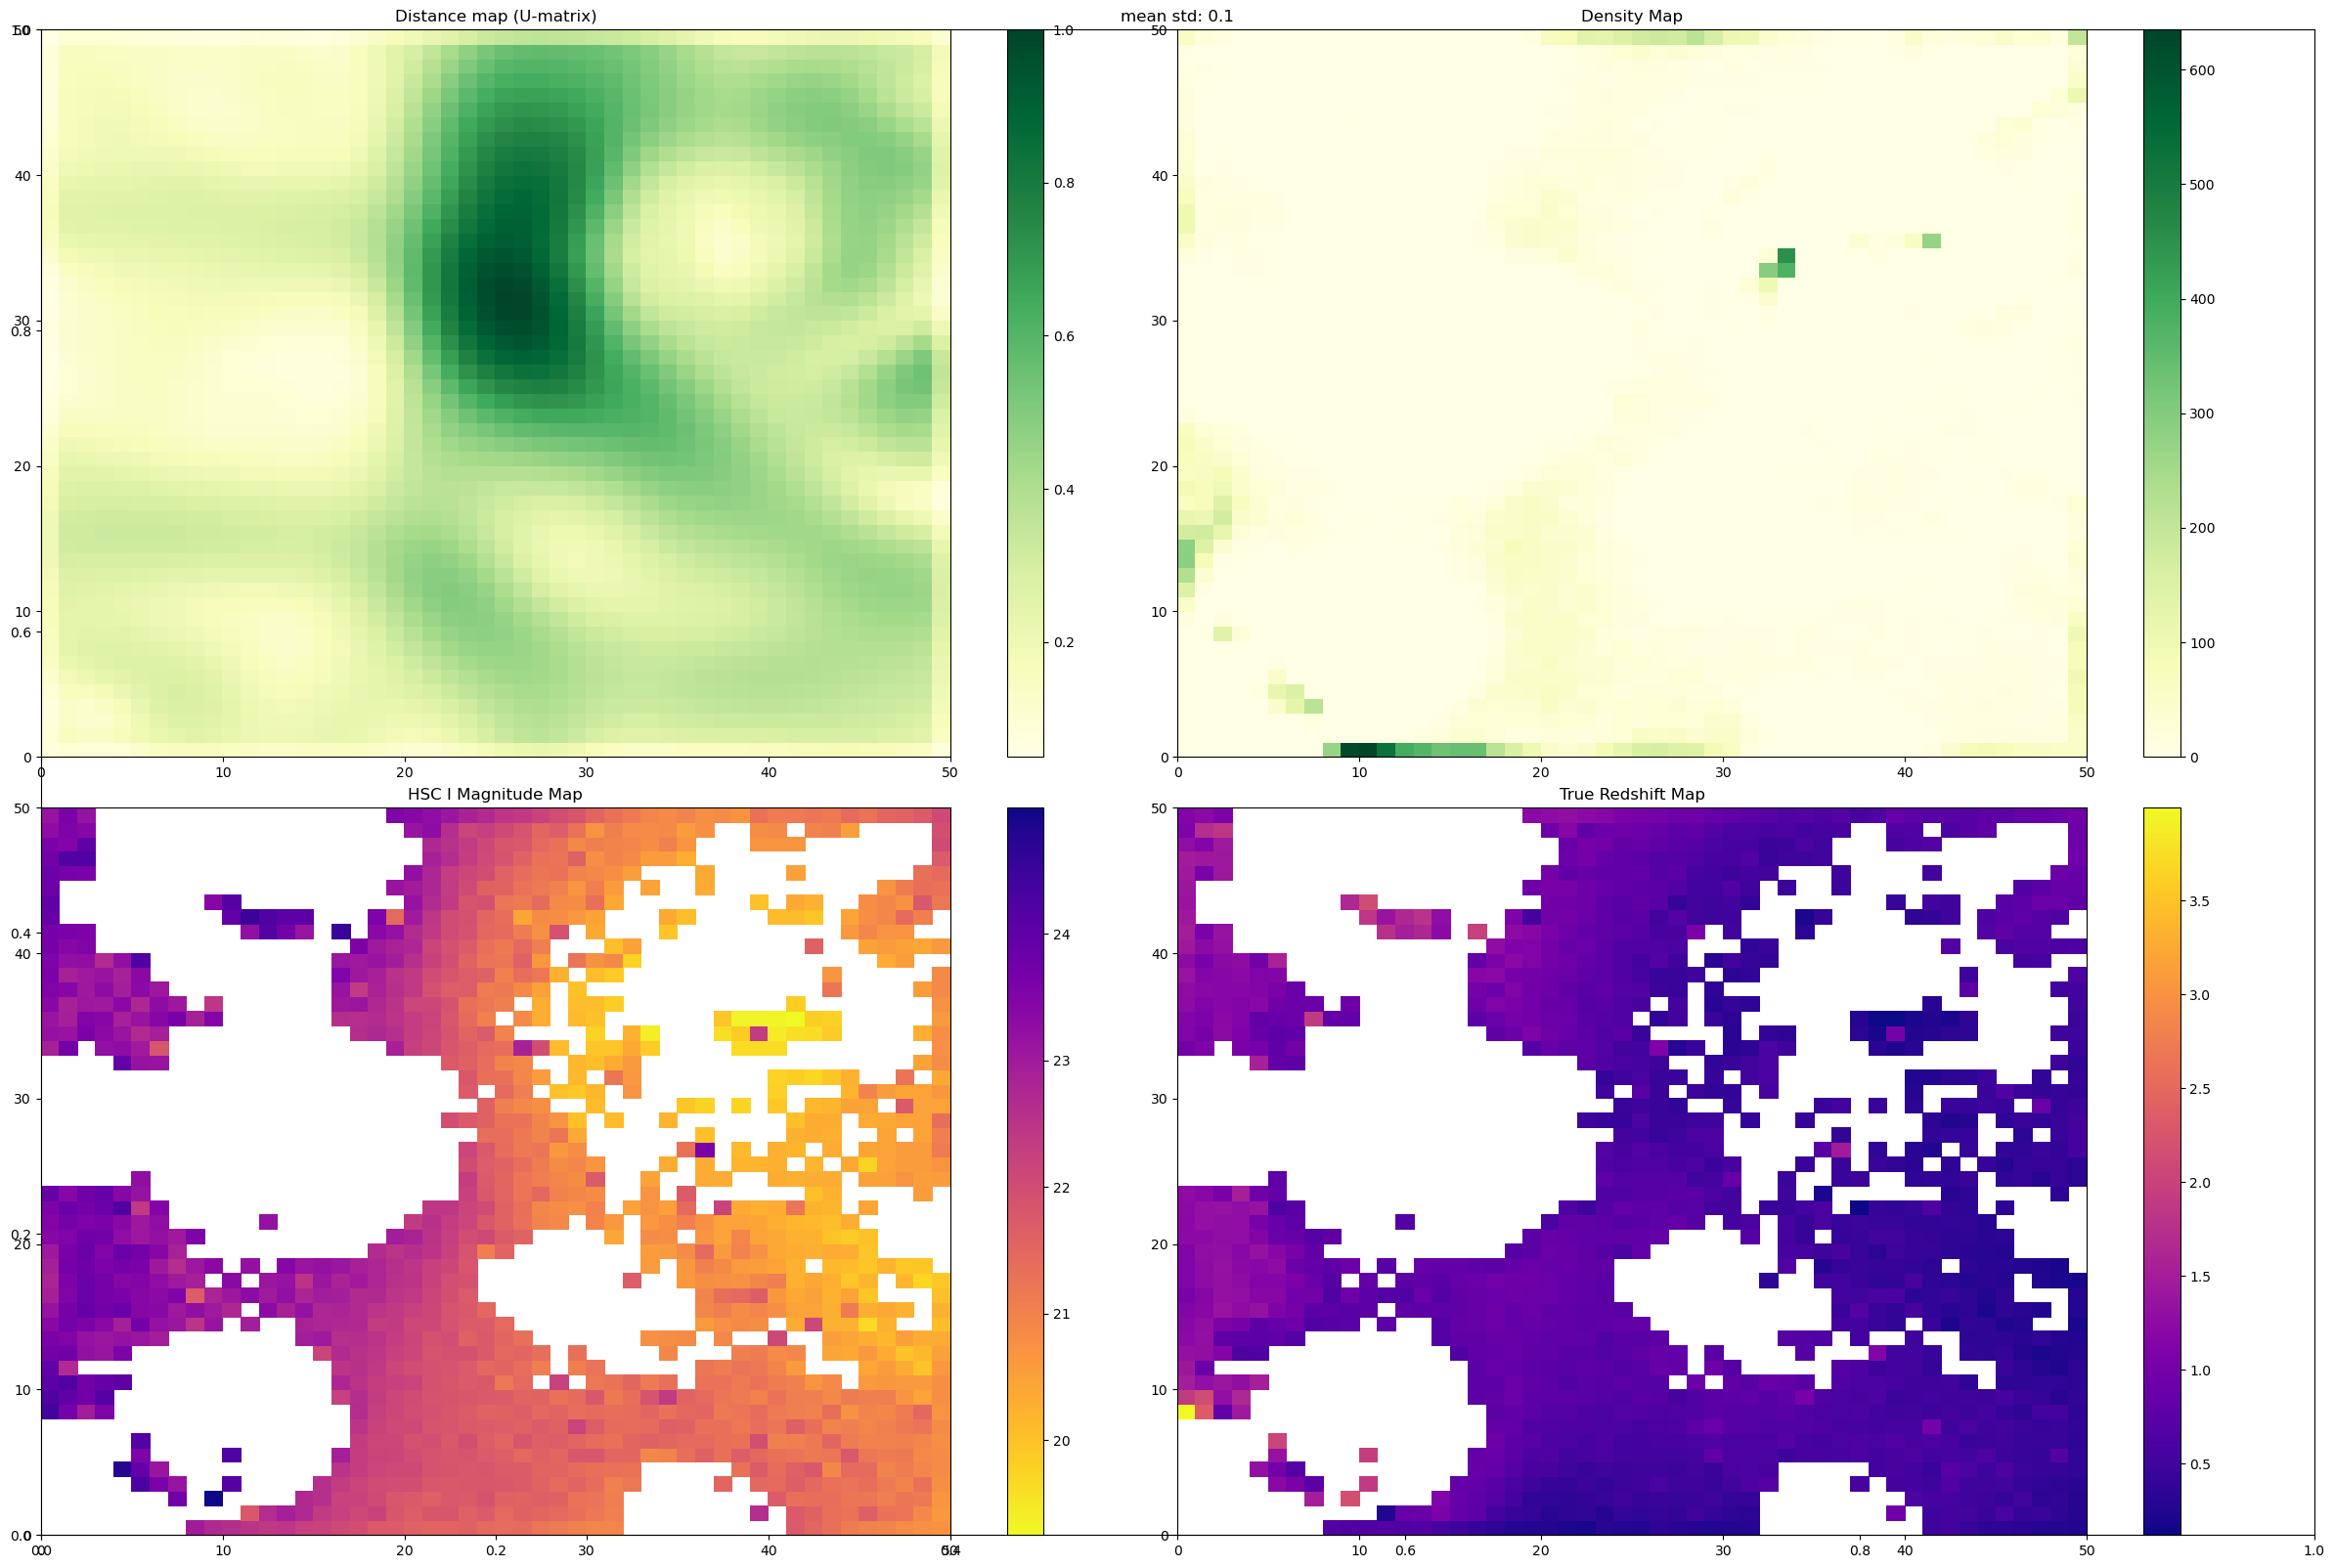

Data shape: (29683, 102)


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\linalg\_linalg.py:2773: RuntimeWarning: overflow encountered in reduce
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))
D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\linalg\_linalg.py:2772: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\minisom.py:301: RuntimeWarning: overflow encountered in divide
  return linalg.norm(subtract(x, w) / err, axis = -1)
D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\minisom.py:350: RuntimeWarning: invalid value encountered in add
  self._weights += einsum('ij, ijk->ijk', g, x-self._weights)


Start making diagrams...
[50, 20, 5]
29683.0
Topological error: 0.7062628440521511
Quantization error: nan
Average redshift std: 0.2528298019621747


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


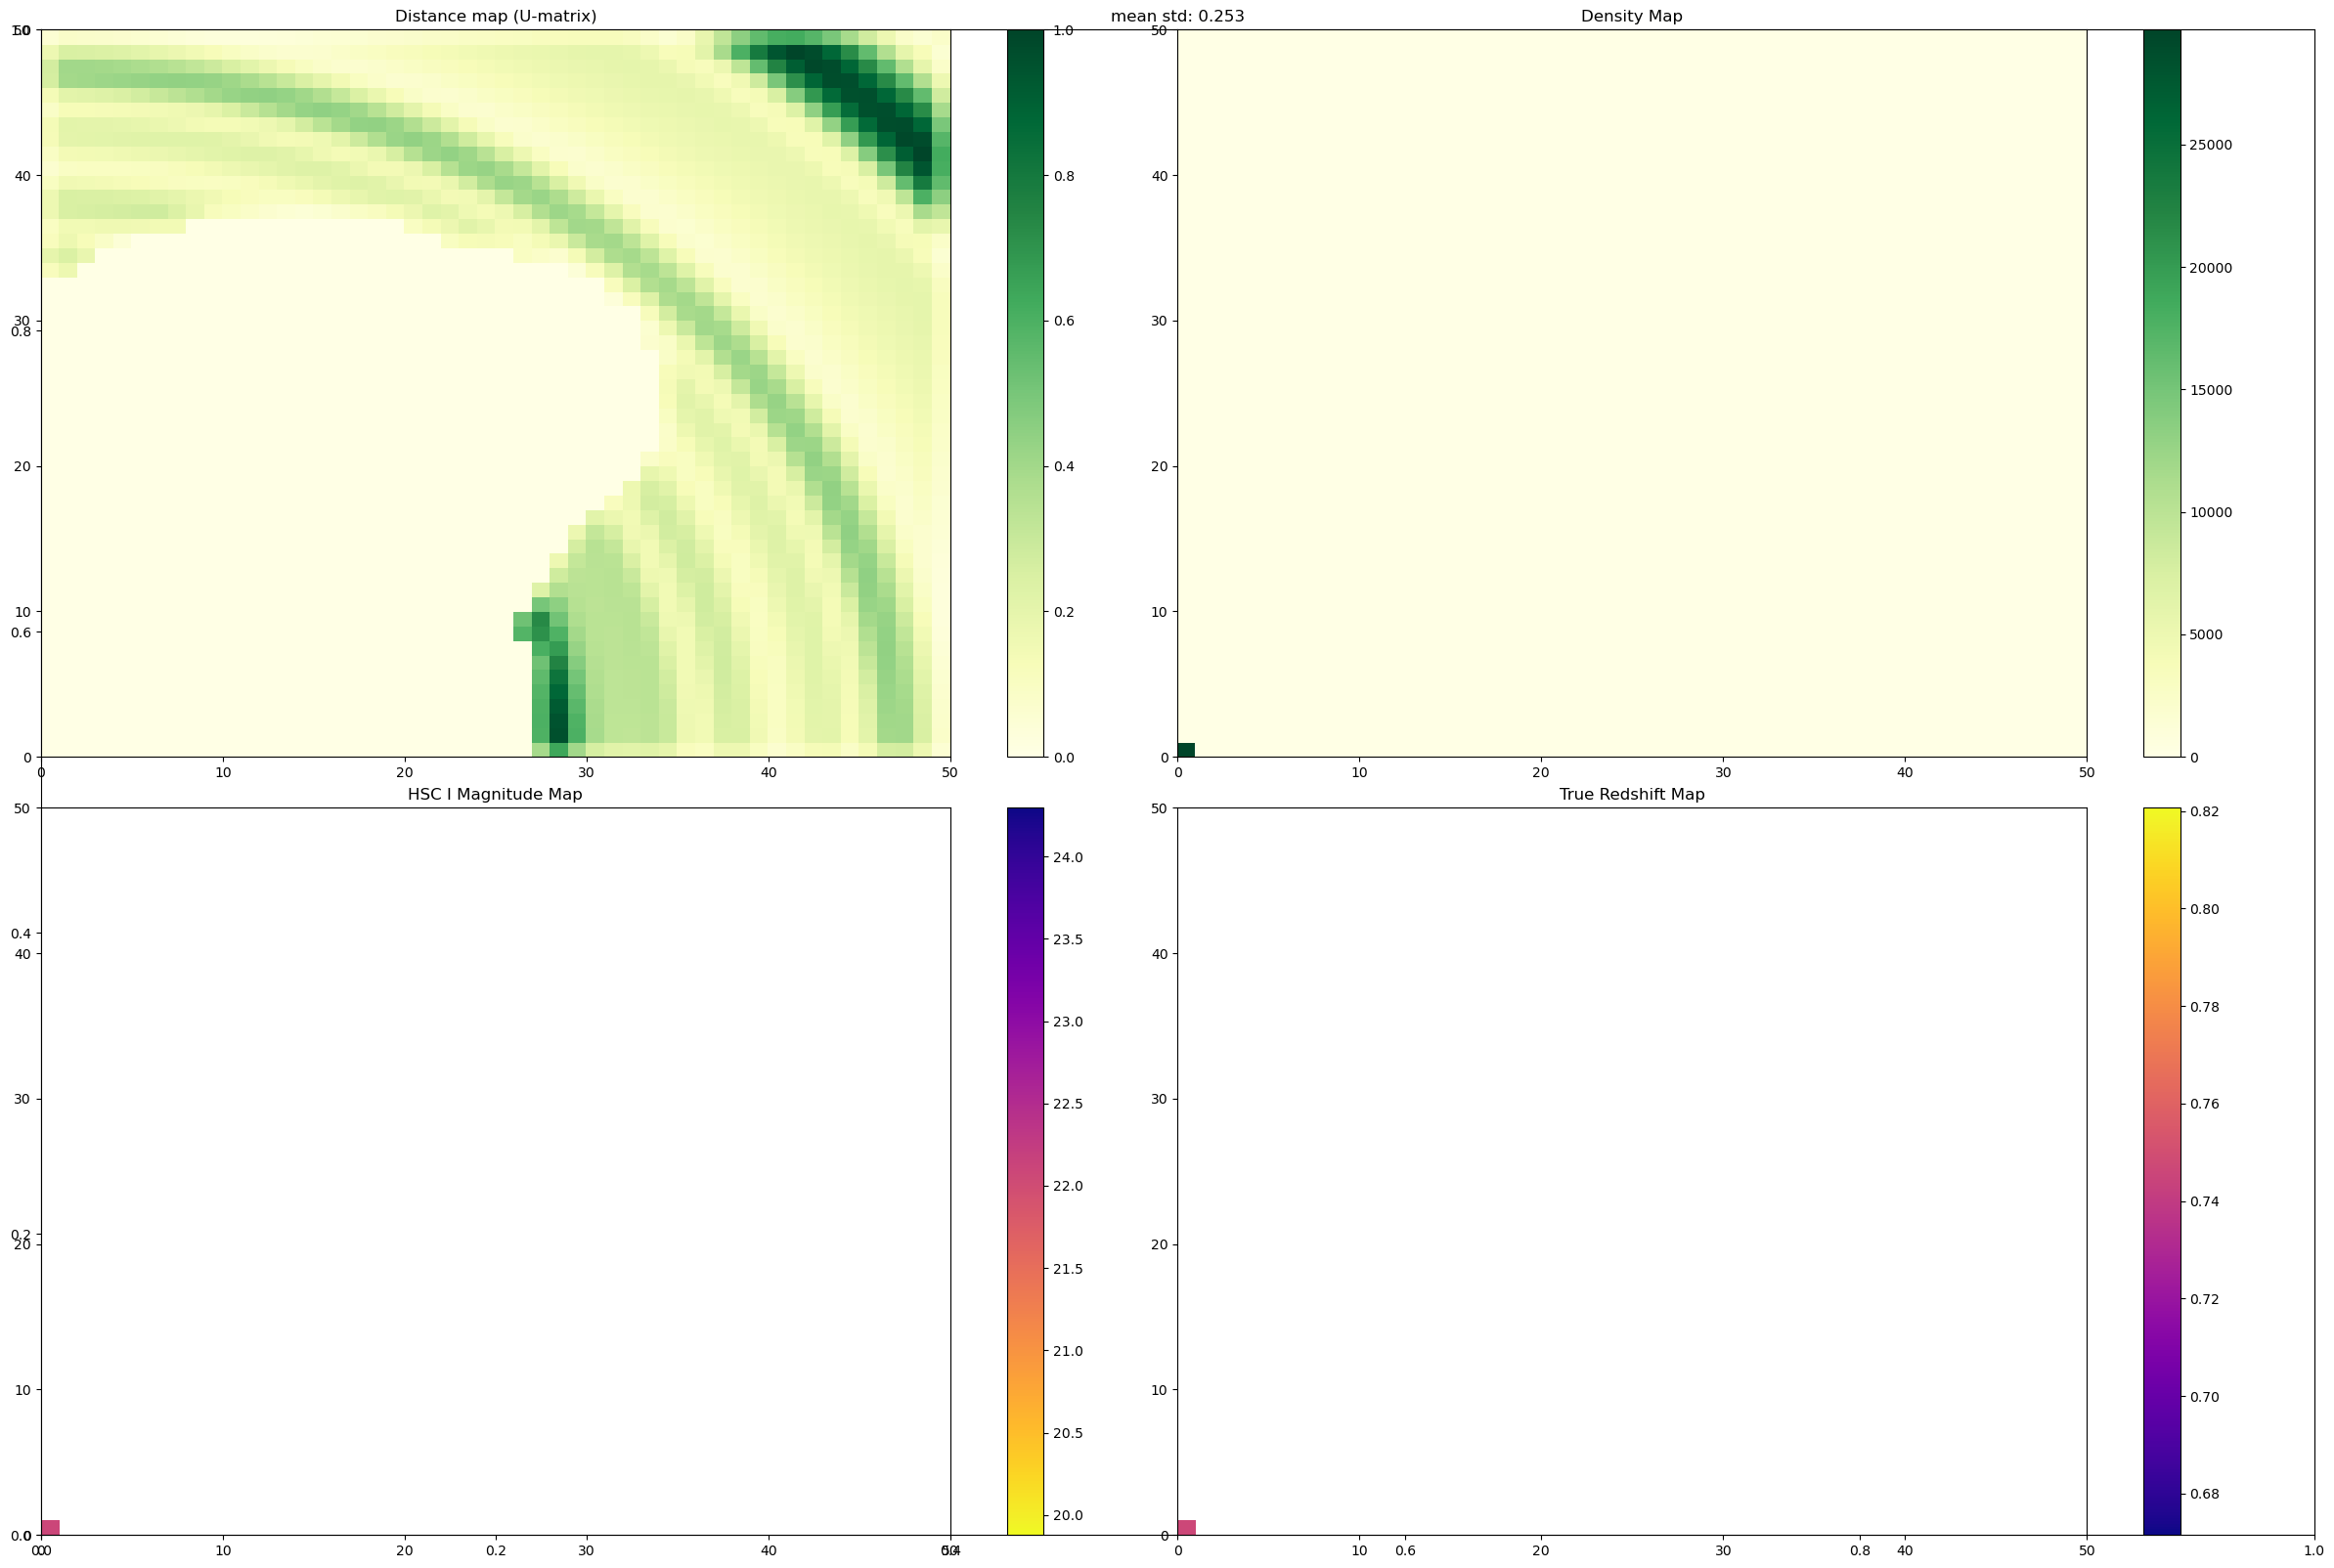

Data shape: (29683, 102)


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\linalg\_linalg.py:2773: RuntimeWarning: overflow encountered in reduce
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))
D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\linalg\_linalg.py:2772: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\minisom.py:301: RuntimeWarning: overflow encountered in divide
  return linalg.norm(subtract(x, w) / err, axis = -1)
D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\minisom.py:350: RuntimeWarning: invalid value encountered in add
  self._weights += einsum('ij, ijk->ijk', g, x-self._weights)


Start making diagrams...
[50, 20, 6]
29683.0
Topological error: 0.6980089613583532
Quantization error: nan
Average redshift std: 0.2528298019621747


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


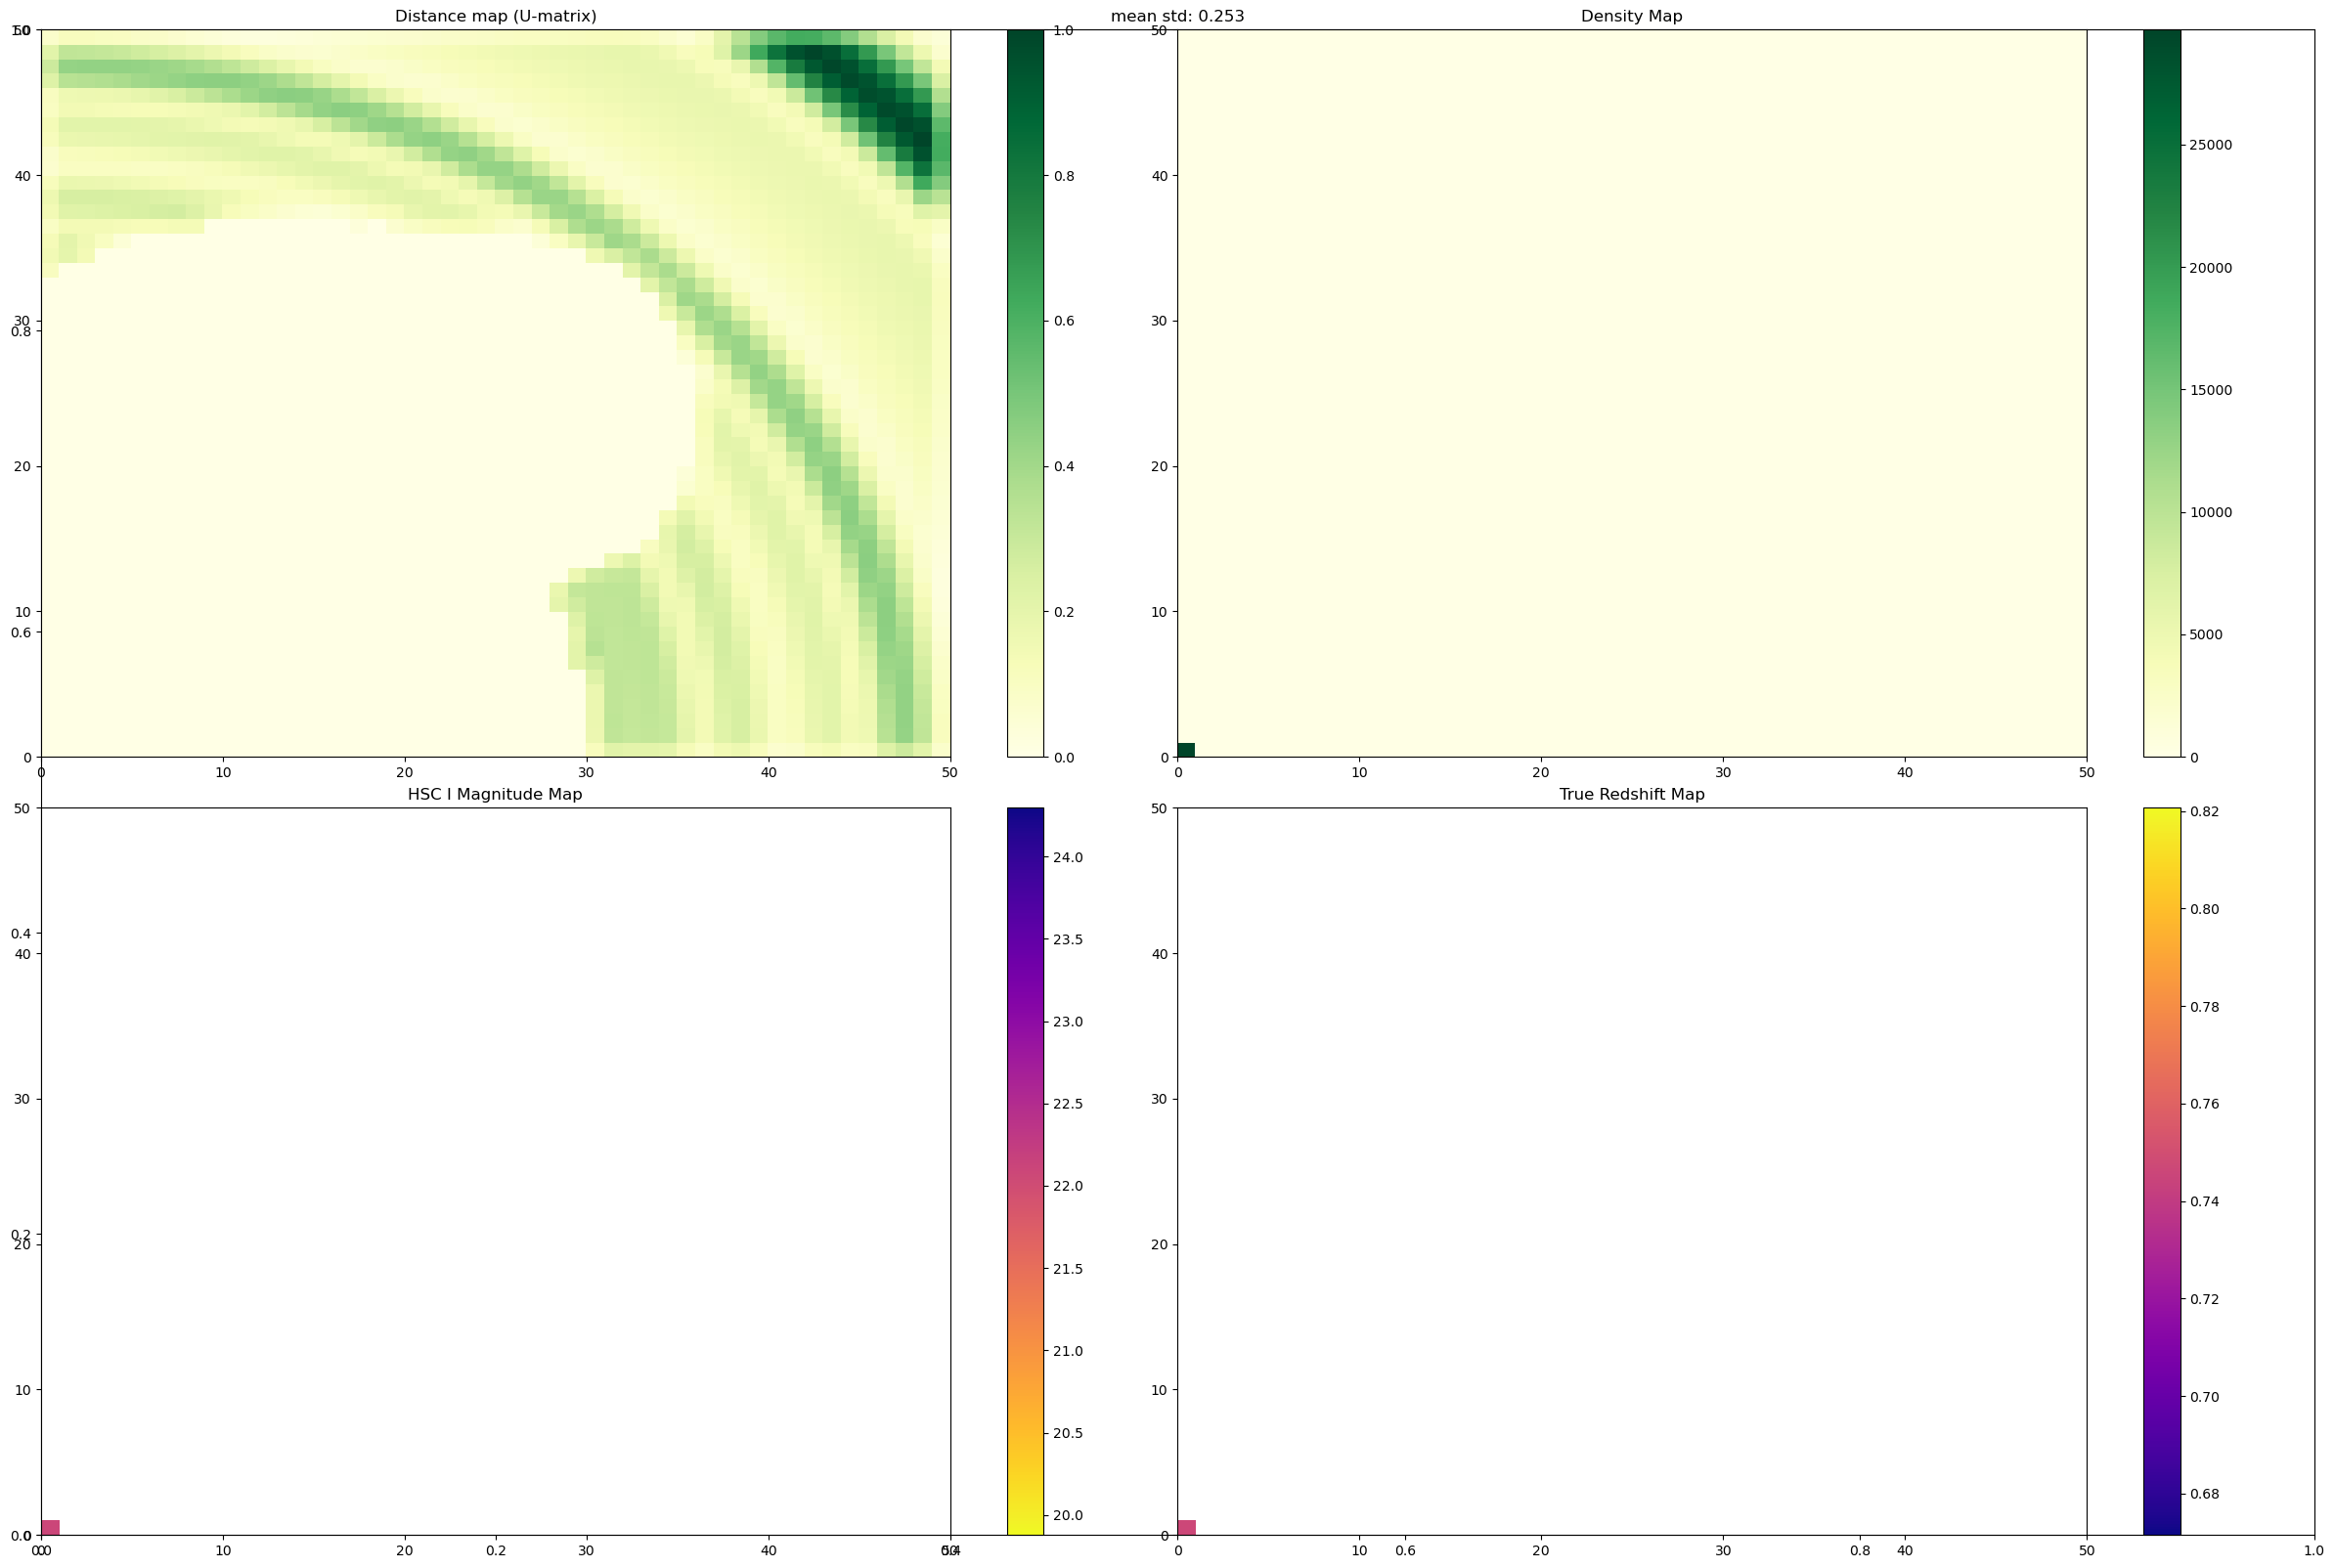

Data shape: (29683, 102)


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\linalg\_linalg.py:2773: RuntimeWarning: overflow encountered in reduce
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))
D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\linalg\_linalg.py:2772: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\minisom.py:301: RuntimeWarning: overflow encountered in divide
  return linalg.norm(subtract(x, w) / err, axis = -1)
D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\minisom.py:350: RuntimeWarning: invalid value encountered in add
  self._weights += einsum('ij, ijk->ijk', g, x-self._weights)


Start making diagrams...
[50, 20, 7]
29683.0
Topological error: 0.6760772159148334
Quantization error: nan
Average redshift std: 0.2528298019621747


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


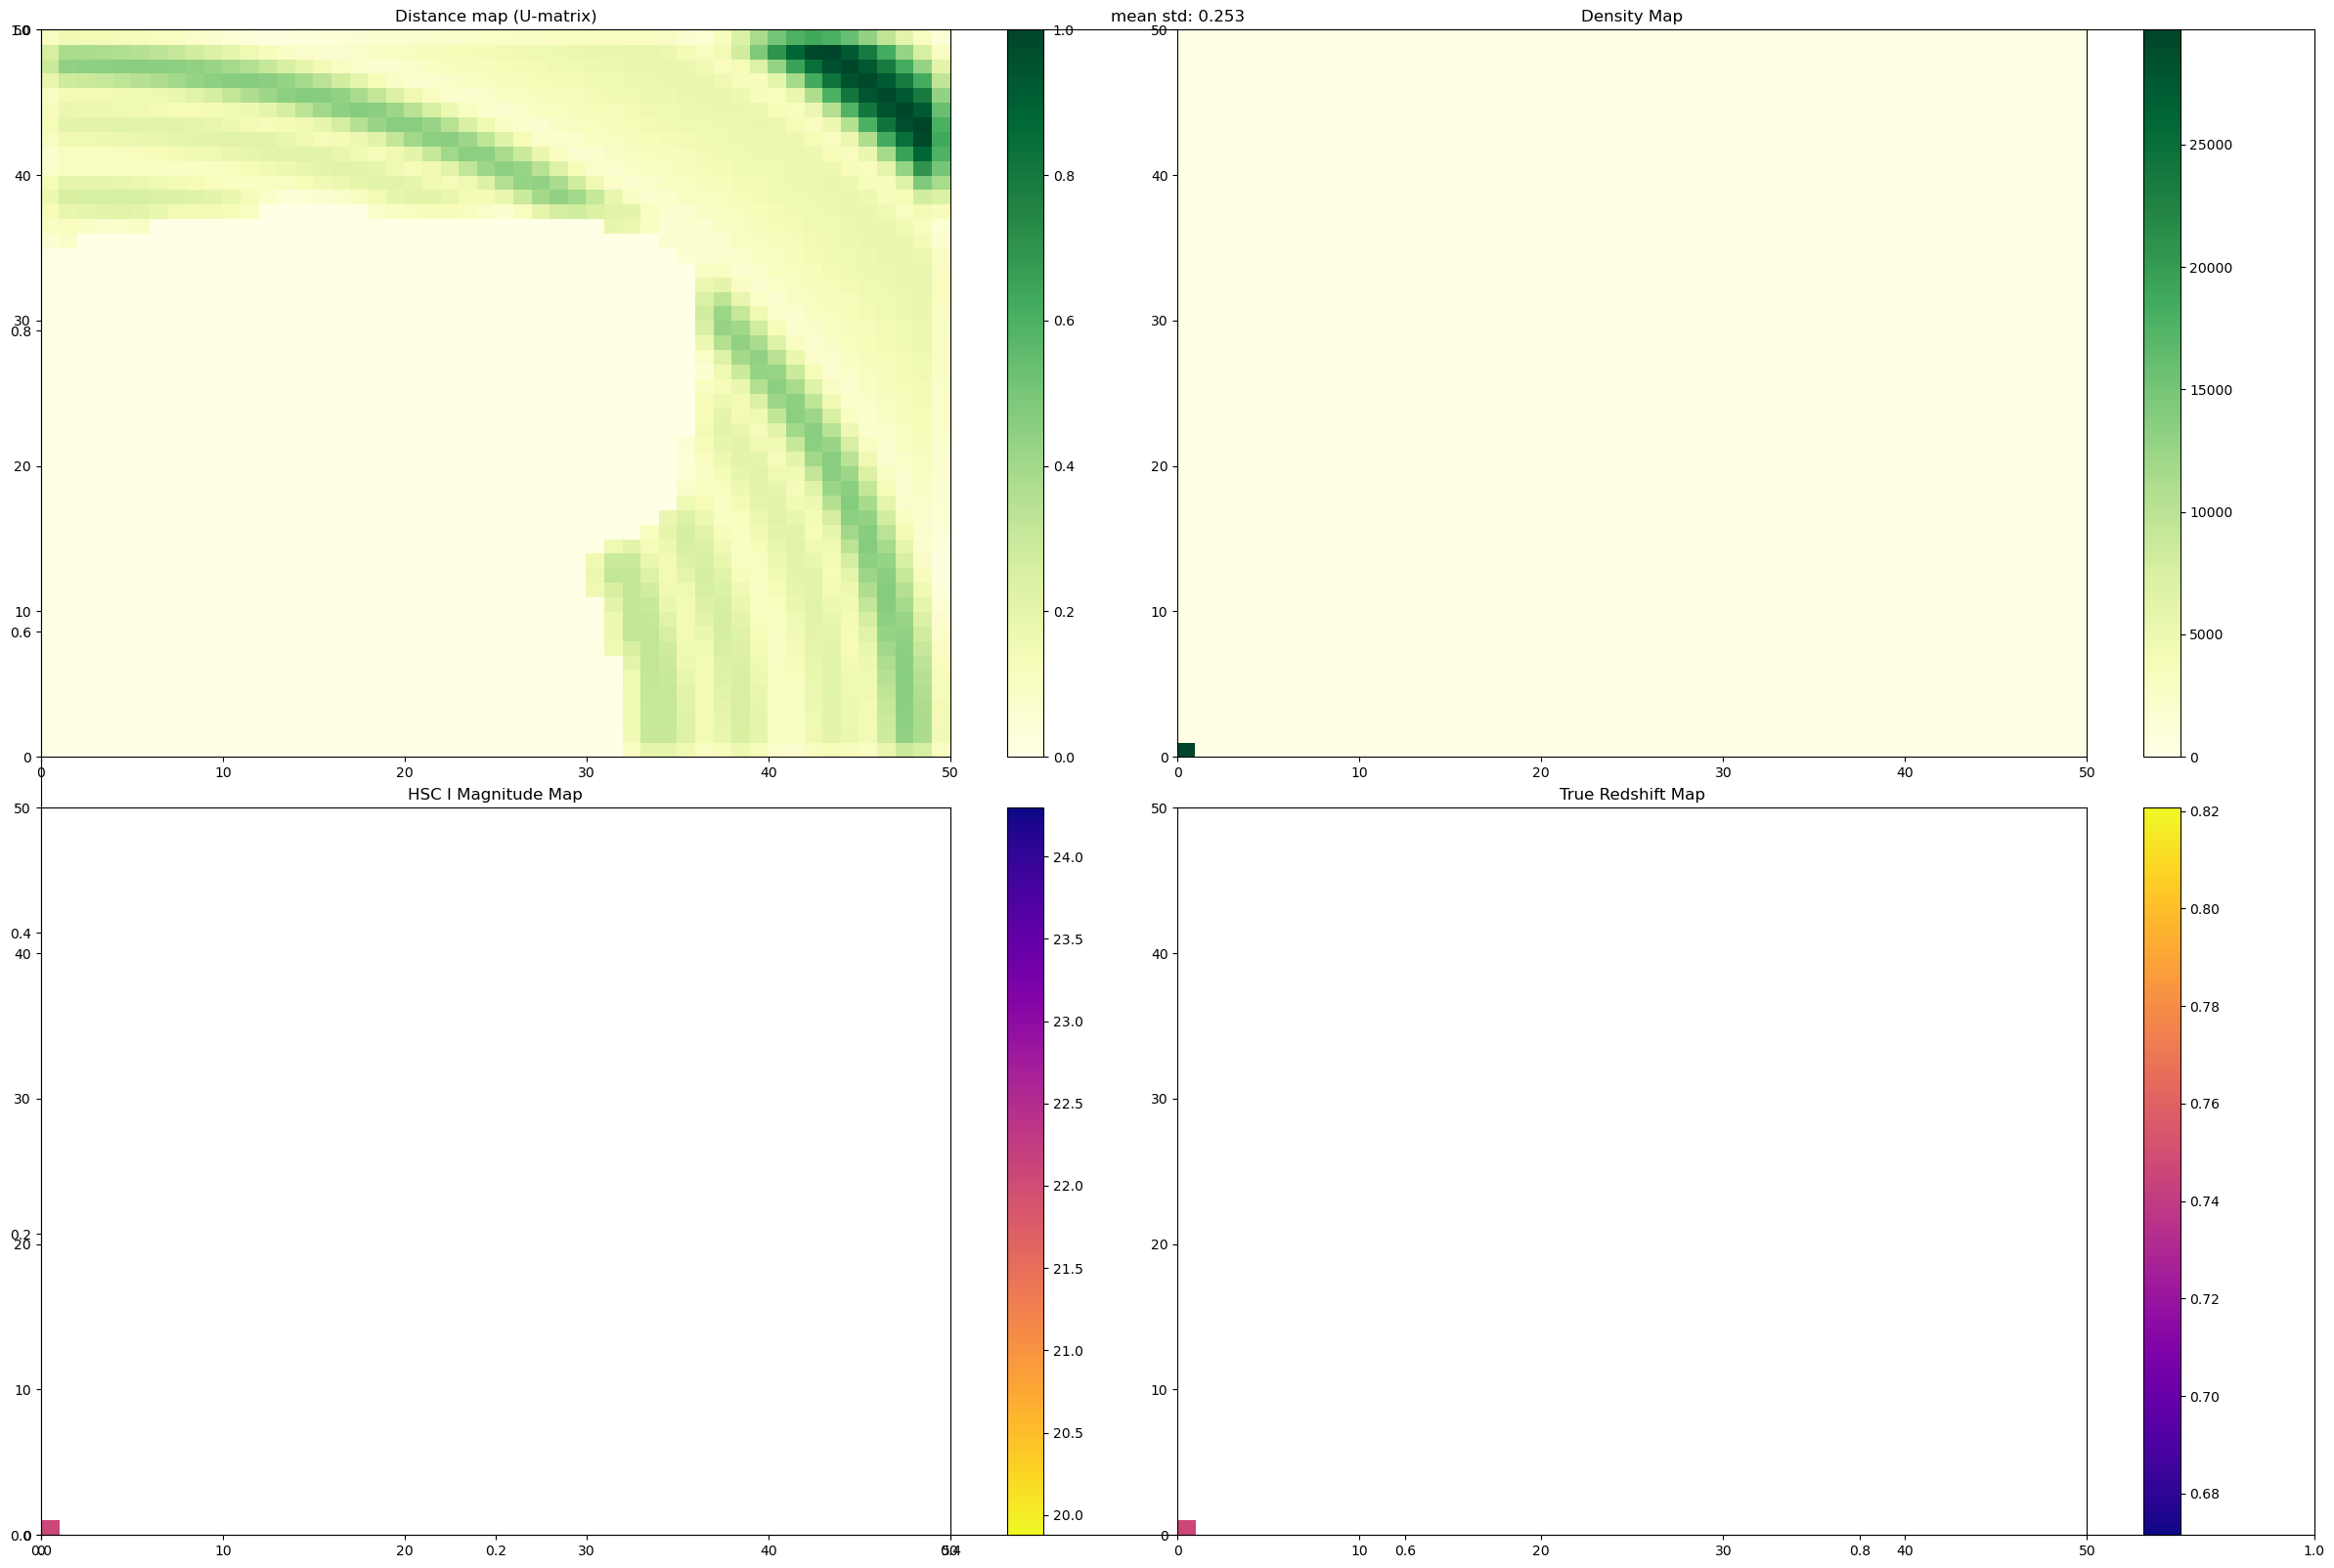

Data shape: (29683, 102)


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\linalg\_linalg.py:2772: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\linalg\_linalg.py:2773: RuntimeWarning: overflow encountered in reduce
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))
D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\minisom.py:301: RuntimeWarning: overflow encountered in divide
  return linalg.norm(subtract(x, w) / err, axis = -1)
D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\minisom.py:350: RuntimeWarning: invalid value encountered in add
  self._weights += einsum('ij, ijk->ijk', g, x-self._weights)


Start making diagrams...
[50, 20, 8]
29683.0
Topological error: 0.10484115486979079
Quantization error: nan
Average redshift std: 0.2528298019621747


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


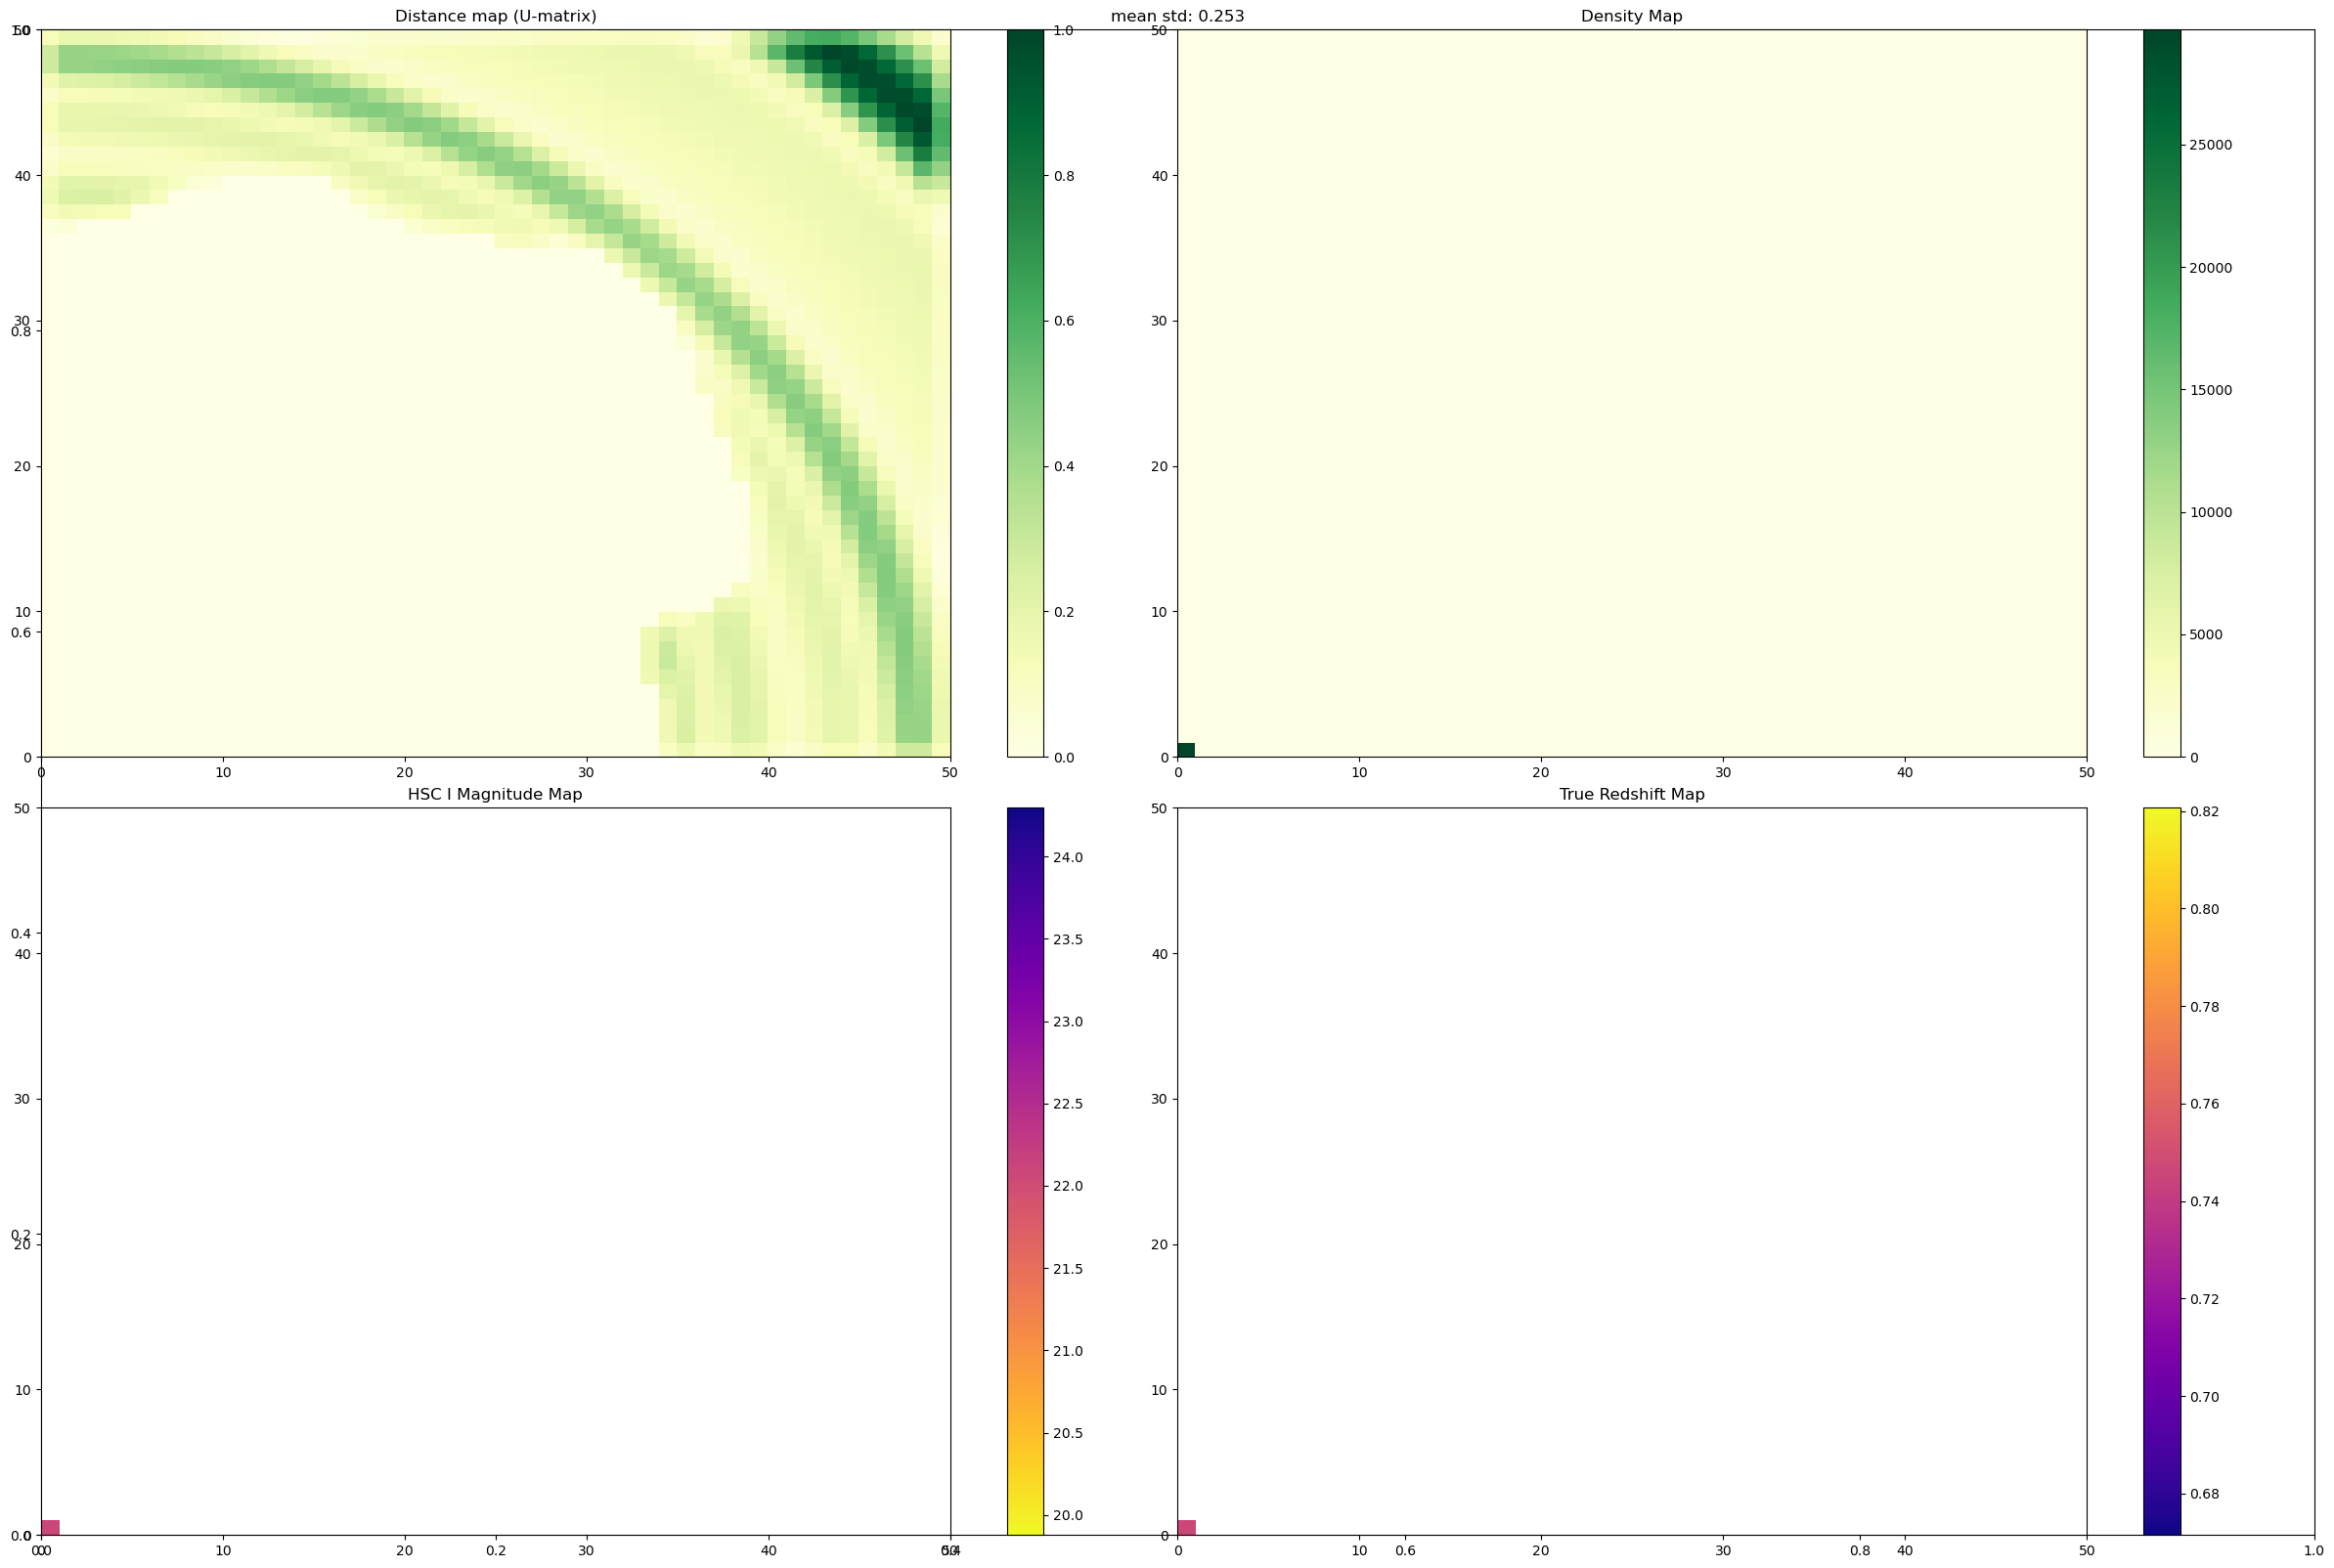

Data shape: (29683, 102)


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\linalg\_linalg.py:2773: RuntimeWarning: overflow encountered in reduce
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))
D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\numpy\linalg\_linalg.py:2772: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\minisom.py:301: RuntimeWarning: overflow encountered in divide
  return linalg.norm(subtract(x, w) / err, axis = -1)
D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\minisom.py:350: RuntimeWarning: invalid value encountered in add
  self._weights += einsum('ij, ijk->ijk', g, x-self._weights)


Start making diagrams...
[50, 20, 9]
29683.0
Topological error: 0.5975474177138429
Quantization error: nan
Average redshift std: 0.2528298019621747


C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_26292\4086833953.py:63: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


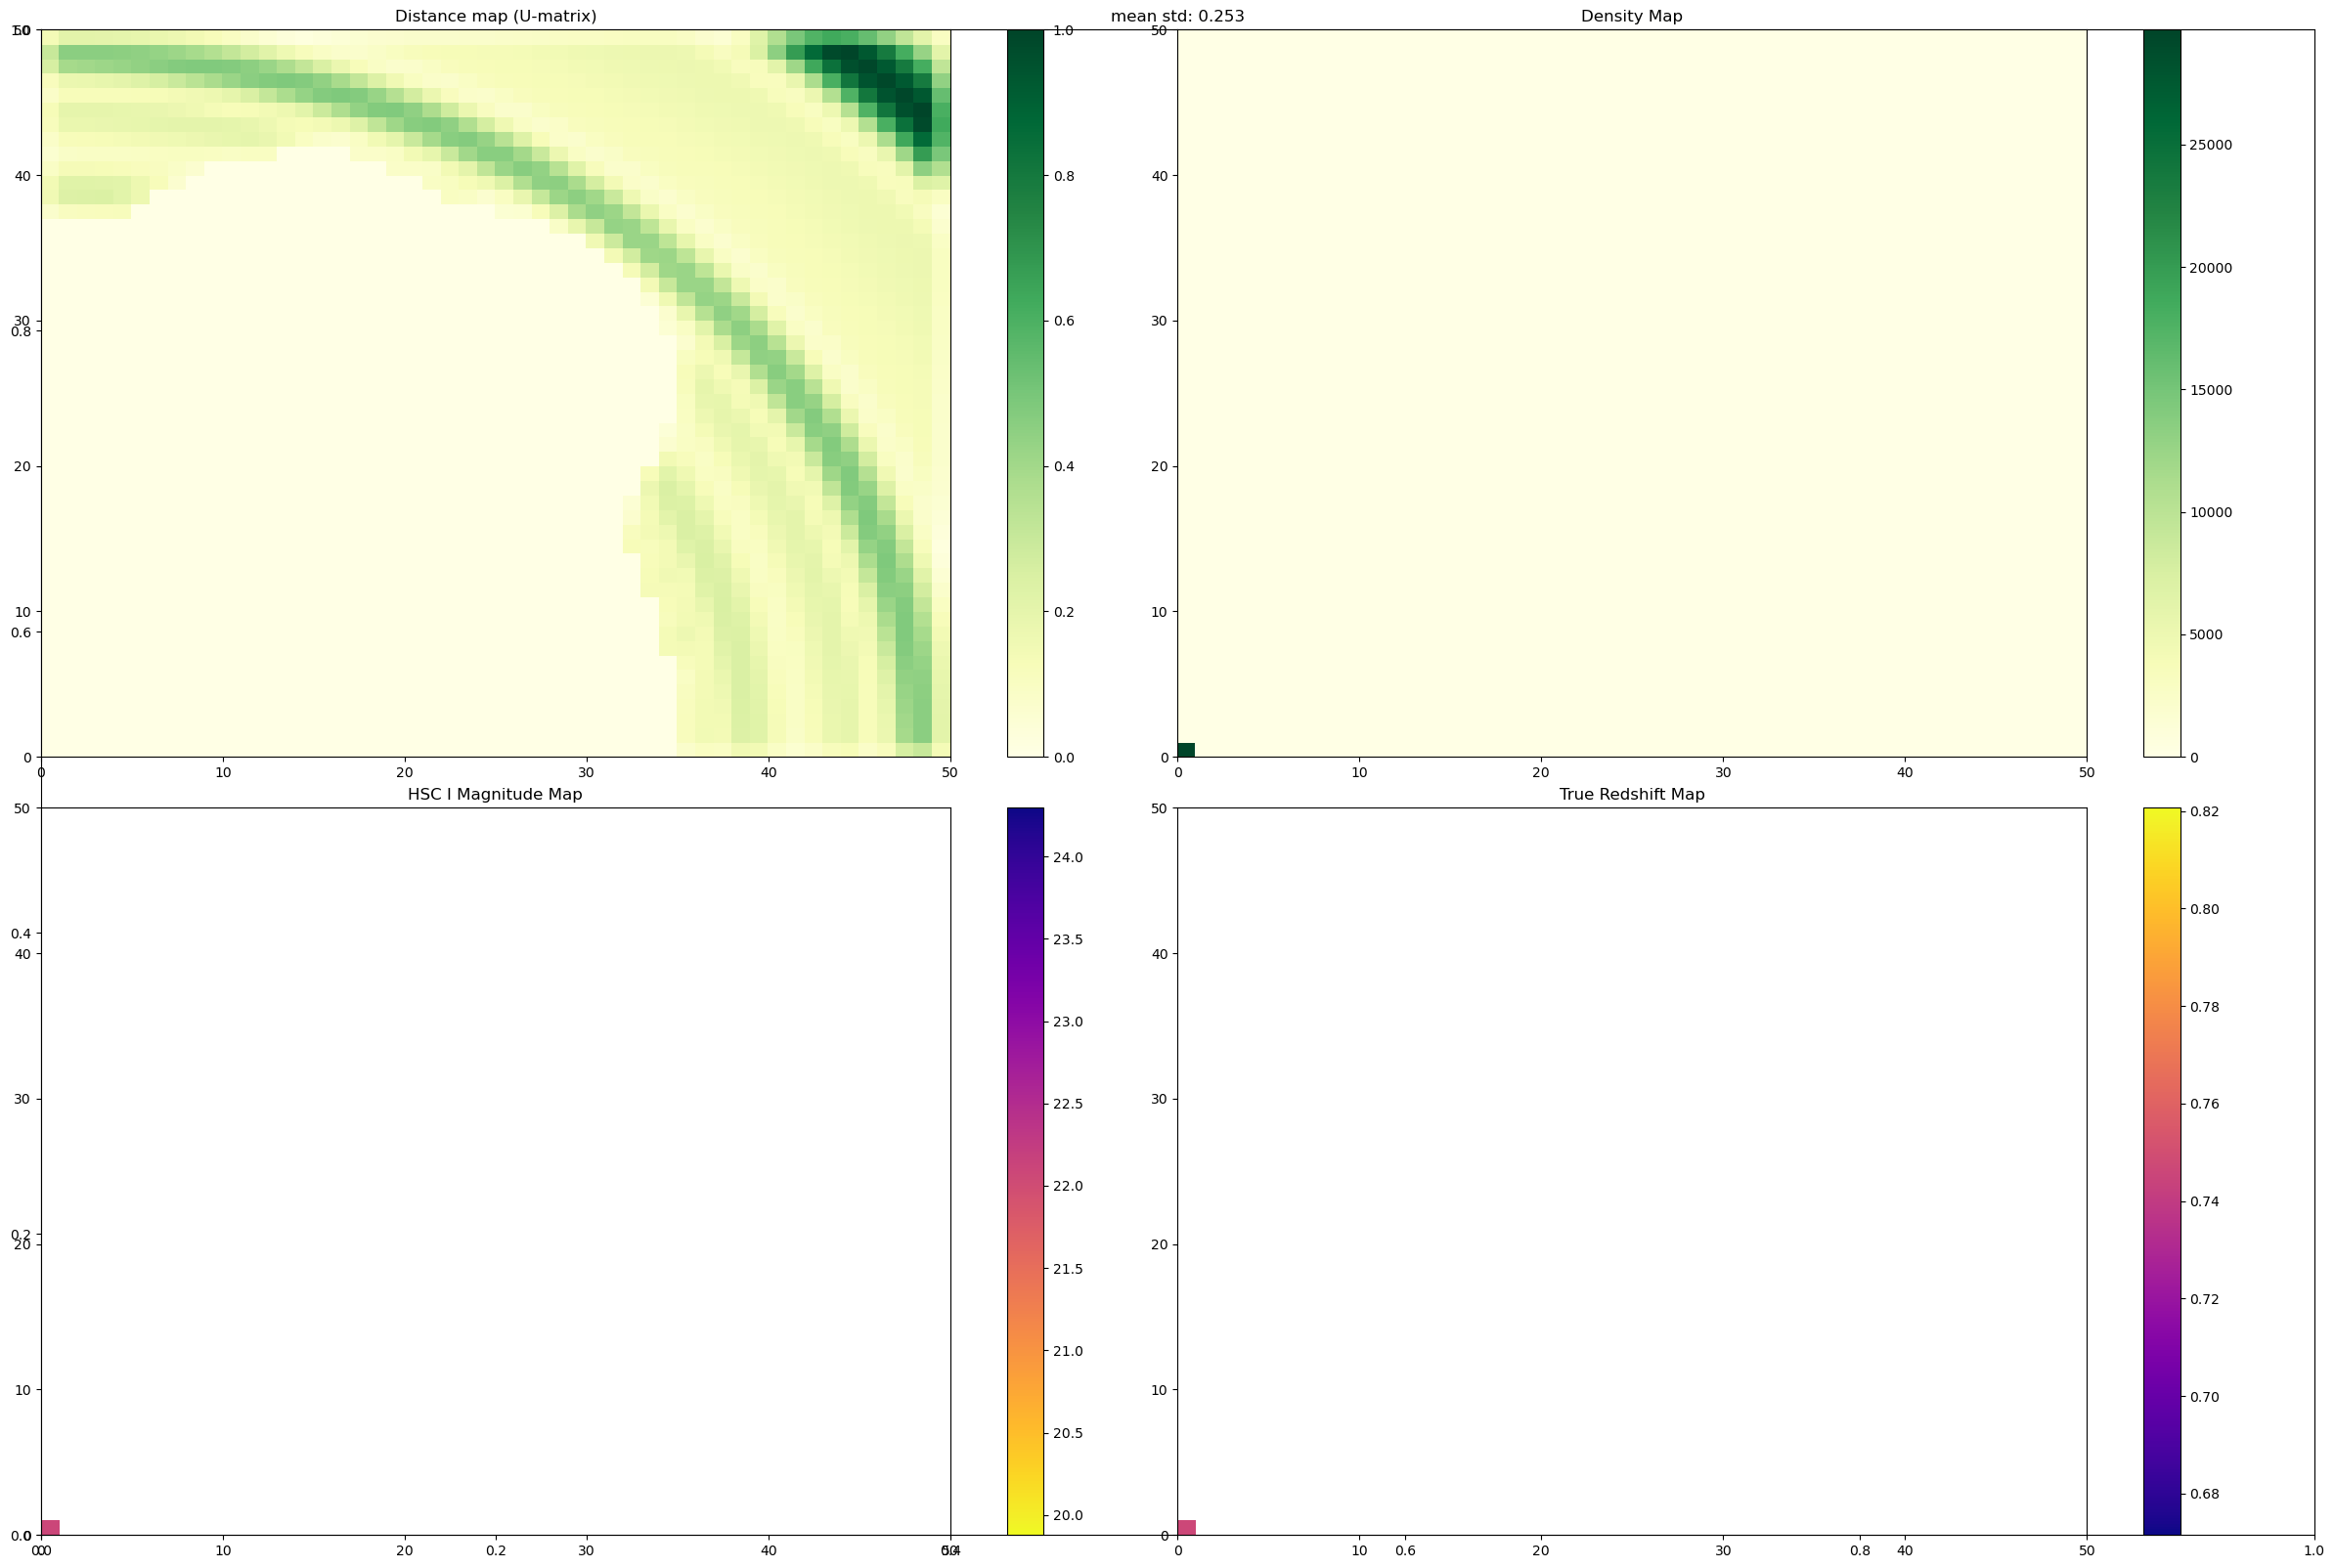

In [7]:
for i in [i / 1000  for i in range(1, 10)] + [i / 100 for i in range(1, 10)] + [i / 10 for i in range(1, 10)] + [i for i in range(1, 10)]:
    som = basic_som(data = data, data_type = "chi2_lup_shallow", err = err, info_data = info, dim = 50, preproc = "default", iteration = 4, sigma = 20, rate = i, b_scale  = 10, save = True, distance = "chi2_distance")

In [ ]:
# for i in [0.01, 0.1, 1, 10, 100, 1000, 10000, 10 ** 5, 10 ** 6]:
#     som = basic_som(data = data, data_type = "chi2_lup_deep", err = err, info_data = info, dim = 50, preproc = "default", iteration = 2, sigma = 0.6, rate = 0.5, b_scale  = i, save = True, distance = "chi2_distance")